# Anthropogenic GHG, Aerosols, and other species (Climate Forcers)

**README**

This code script quantifies estimates of historical (1750-2022) emissions, ERF, and change in GSAT (del_T) contributions by sector of the the following:
* GHG: 
Carbon Dioxide (CO2),
Methane (CH4),
Nitrous Oxide (N2O),
Halogenated Compounds (CFCs, HFCs, HCFCs, etc.)
* Air pollutants:
NOx,
VOC’s,
CO,
SO2,
NH3,
* Aerosols:
Organic carbon,
Black Carbon

Emissions, ERF, and change in GSAT (del_T) contributions are allocated to the following sectors:
* Power
* fossil fuel production and distribution (ffpd)
* Industry
* Transportation
* Buildings
* Waste
* Agriculture

**Code Sources:**

Estimates of individual species ERF and change in GSAT are derived following the code of [IPCC AR6 CH6 Fig.12](https://github.com/IPCC-WG1/Chapter-6_Fig12_22_24) adapted to quantify sectoral contributions, we thank the authors for providing their open-access code. 

**Data Sources:**

Final Emissions Data for major GHGs and air pollutants from [Community Emissions Data Systems (CEDS)](https://github.com/JGCRI/CEDS/blob/master/README.md) version v_2024_04_01. Emissions prior to the year 1970 for CH4 and N2O are from v_2021_04_21 fuel data with sector partitioning from v_2024_04_01 year 1970 allocation.

HC (CFC, HCFC, HFC, etc.; see publication methods Table 2) emissions data from [WMO Ozone 2022 Report](https://csl.noaa.gov/assessments/ozone/2022/),  emission data from [EDGAR - Emissions Database for Global Atmospheric Research](https://edgar.jrc.ec.europa.eu/emissions_data_and_maps), specifically EDGAR v7.0, with other species from [UNEP Ozone Depleting Substance databases](https://ozone.unep.org/countries/data-table). HC emissions sectoral fractions calculated using the EDGAR, UNFCCC AFEAS ([1](https://unfccc.int/files/methods/other_methodological_issues/interactions_with_ozone_layer/application/pdf/cfc1200.pdf) and [2](https://unfccc.int/files/methods/other_methodological_issues/interactions_with_ozone_layer/application/pdf/cfc1100.pdf)) and UNEP ODS databases. See HC Section for specific details.

Final fuel consumption data from [International Energy Agency (IEA)](https://www.iea.org/data-and-statistics/data-product/world-energy-balances) to allocate ffpd sector emissions to other sectors

In [1323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import os

%matplotlib inline


### Sector decision
Run model with ffpd as a separate sector or allocated to other sectors?

In [1324]:
# 0 with ffpd, 1 w/o ffpd (ie ffpd allocated to other sectors)
choice_ffpd = 0

## CEDS & IEA
use emissions (kt) from CEDS database (v_2024_04_01) so able to compare 1750-2022\
use final fuel consumption data from [International Energy Agency (IEA)](https://www.iea.org/data-and-statistics/data-product/world-energy-balances) to allocate ffpd sector emissions to other sectors

In [1325]:
# path = (r'C:data\CEDS_v2021-04-21_emissions') # path to CEDS data
path = (r'C:data\CEDS_v_2024_04_01_aggregate') # path to CEDS data
# latest update is 2024_04_01

In [1326]:
# file_suffix = 'global_CEDS_emissions_by_sector_2021_04_21.csv'
file_suffix = '_CEDS_global_emissions_by_sector_v2024_04_01.csv'
fl_CEDS = [os.path.join(path, file) for file in os.listdir(path) if file.endswith(file_suffix) and os.path.isfile(os.path.join(path, file))]

In [1327]:
fl_CEDS

['C:data\\CEDS_v_2024_04_01_aggregate\\BC_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\CH4_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\CO2_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\CO_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\N2O_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\NH3_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\NMVOC_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\NOx_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\OC_CEDS_global_emissions_by_sector_v2024_04_01.csv',
 'C:data\\CEDS_v_2024_04_01_aggregate\\SO2_CEDS_global_emissions_by_sector_v2024_04_01.csv']

In [1328]:
#load in CEDS data

list_df_em = []
units_dic = {}
for fn in fl_CEDS:
    _df = pd.read_csv(fn)
    u_em = _df['em'].unique()
    if len(u_em) > 1:
        print('double check, emission labels :')
        print(u_em)
    _em = u_em[0]
    u_units = _df['units'].unique()
    if len(u_units) > 1:
        print('double check, units labels :')
        print(u_units)
    _un = u_units[0]
    # _df_s = _df.drop(['em', 'sector', 'units'], axis=1).sum()
    #_df_s.index = pd.to_datetime(_df_s.index, format='X%Y').year
    # _df = pd.DataFrame(_df_s)#, columns=[_em])
    # # n = 3
    # # _df = _df.concat([[] for _ in range(n)], ignore_index=True)
    # new_cols = [f'X{i}'for i in range(2020,2023)]
    # # new_cols = [x for in in range(2020, 2023)]
    # new_data = {col: [np.nan] * len(_df) for col in new_cols}
    # _df = pd.concat([_df, pd.DataFrame(new_data)],axis=1)
    object_cols = _df.select_dtypes(include = ['object']).columns
    num_cols =  [col for col in _df.columns if col not in object_cols]
    keep_cols = _df[num_cols].columns
    _dfi = _df[num_cols].T.reset_index(drop=True)
    # _dfi.iloc[-8:,:] = _dfi.iloc[-8:,:].interpolate(method="slinear",fill_value="extrapolate",limit_direction="forward", axis=0)#, limit_area = 'inside')
    _dfi = _dfi.T
    _dfi.columns = keep_cols
    _df2 = pd.concat([_df[object_cols],_dfi], axis=1)
    units_dic[_em] = _un
    list_df_em.append(_df2)

In [1329]:
_df2

,em,sector,units,X1750,X1751,X1752,X1753,X1754,X1755,X1756,...,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022
0,SO2,1A1a_Electricity-autoproducer,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1724.978974,1932.527508,1869.355028,2258.299027,2213.408455,2332.203972,2619.737394,2467.334588,2461.681868,2649.958401
1,SO2,1A1a_Electricity-public,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,28406.589078,28621.122812,27007.382516,25271.928448,24559.471605,24591.824096,24722.387466,22747.606407,24361.146484,24723.952756
2,SO2,1A1a_Heat-production,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,7434.871972,6461.066138,5986.914710,5130.638734,4630.734635,4774.851465,4540.965428,4236.785697,4458.659758,4328.113688
3,SO2,1A1bc_Other-transformation,ktSO2,2.934066,2.934066,2.935216,2.935216,2.936366,2.937515,3.139865,...,3274.873550,3083.305550,2699.517375,2649.338138,2439.685129,2489.074647,2490.133710,2477.997712,2508.657240,2527.955369
4,SO2,1A2a_Ind-Comb-Iron-steel,ktSO2,0.000000,0.030188,0.060399,0.090599,0.120845,0.151116,0.193830,...,3531.242950,3205.653802,2638.984527,2180.816701,2076.358344,2031.149963,1991.112132,1962.025394,2103.019686,2135.328011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,SO2,5E_Other-waste-handling,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
57,SO2,6A_Other-in-total,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
58,SO2,6B_Other-not-in-total,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
59,SO2,7A_Fossil-fuel-fires,ktSO2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,326.300000,326.300000,326.300000,326.300000,326.300000,326.300000,328.345183,330.285625,332.114331,333.833433


In [1330]:
#upload IEA Energy data used to partition ffpd to other sectors Source: IEA (2023), World Energy Balances (database)
IEA = pd.read_excel(r'C:data\WorldEnergyBalancesHighlights2023.xlsx', 'TimeSeries_1971-2022')

In [1331]:
IEA.columns = IEA.iloc[0,:]
IEAw = IEA[IEA.Country == 'World']

In [1332]:
# IEAw[IEAw['Product'].str.contains('|'.join(['Crude']))]#.iloc[-5:,:]
# IEA

In [1333]:
iea = {}
iea['coal'] = IEAw[IEAw['Product'].str.contains('|'.join(['Coal']))].iloc[np.r_[4, 7:12],:]
iea['crude'] = IEAw[IEAw['Product'].str.contains('|'.join(['Crude']))].iloc[np.r_[4, 7:12],:]
iea['gas'] = IEAw[IEAw['Product'].str.contains('|'.join(['Natural gas']))].iloc[np.r_[4, 7:12],:]
iea['oil'] = IEAw[IEAw['Product'].str.contains('|'.join(['Oil']))].iloc[np.r_[4, 7:12],:]


iea_fracs = {}

for fuel in iea.keys():
    # iea[fuel]['type'] = fuel
    iea[fuel] = iea[fuel].drop(columns = '2022 Provisional')
    iea[fuel][2022] = np.nan
    iea[fuel] = iea[fuel].iloc[:,5:].rename(columns = {'NoFlow':'sector'}).reset_index(drop=True)
    iea_cols = iea[fuel].columns
    iea[fuel].columns = np.arange(len(iea[fuel].columns))
    iea[fuel].iloc[:,-8:] = iea[fuel].iloc[:,-8:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward", axis = 1)
    iea[fuel].columns = iea_cols
    sectors = [str(row.split(r'. ')[1]) for row in iea[fuel].sector]
    iea[fuel]['sectors'] = ['Energy','Industry', 'Transportation','Buildings','Waste','Agriculture']
    iea[fuel] = iea[fuel].set_index('sectors').drop(columns = 'sector')
    iea[fuel].loc['Energy'] = iea[fuel].loc['Energy'] * -1
    dupcolumns = {i: iea[fuel][1971] for i in range(1750,1971)}
    add_cols = pd.DataFrame(dupcolumns)
    # add_cols = pd.DataFrame(iea[fuel].iloc[:,0], index = iea[fuel].index, columns = [i for i in range(1750, 1971)])
    iea[fuel] = pd.concat([add_cols,iea[fuel]], axis=1)
    iea[fuel].columns = ['X' + str(x) for x in iea[fuel].columns]
    # iea_fracs = iea.copy()
    iea_fracs[fuel] = iea[fuel].div(iea[fuel].sum())

iea['og'] = iea['oil'] +iea['gas'] + iea['crude'] # combine oil and gas to match CEDS ffpd emissions sectors
iea_fracs['og'] = iea['og'].div(iea['og'].sum())

<Axes: xlabel='sectors'>

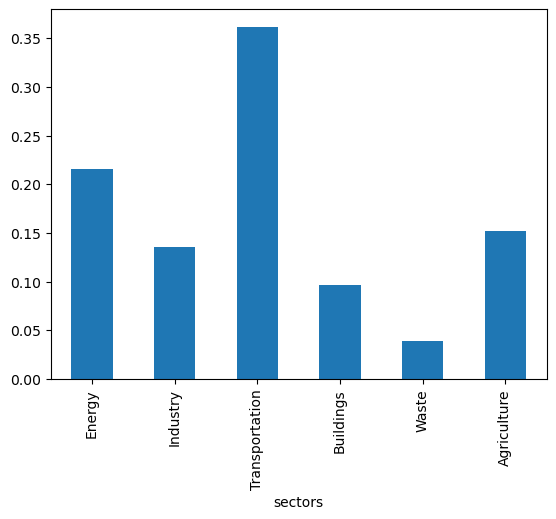

In [1334]:
iea_fracs['og'].iloc[:,-1].plot(kind = 'bar')#.loc['Power']

In [1335]:
# iea_fracs['og'] 
#iea['gas']
#iea['og'].div(iea['og'].sum())

In [1336]:
# IEAw.Product.unique()#[IEAw.Product.str.contains('fossil')]
# IEAw[IEAw.Product.str.contains('Fossil')]

In [1337]:
#Build decay functions (not used, each decay function is reassigned for the LLCFs)
ch4_lifetime = 11.8
t = np.flip(np.arange(0,52,1))
t2 = np.flip(np.arange(0,32,1))
t3 = np.flip(np.arange(0,33,1))
ch4d = np.exp(-t/ch4_lifetime)
n2o_lifetime = 109


def methd(x):
    d = x * np.exp(-t/ch4_lifetime)
    return d
    
#N2O decay function
def nitrod(x):
    d = x * np.exp(-t/n2o_lifetime)
    return d
    
# F gases decay function
def fluod(x):
    r = x[:-1]
    y = x['lifetime']
    d = r * np.exp(-t3/y)
    return d
    
# CO2 decay function
def carbd(x):
#Grasser 2017
    a0 = 0.2366
    a1 = 0.2673
    a2 = 0.2712
    a3 = 0.2249
    tc1 = 4.272
    tc2 = 33.10
    tc3 = 302.4
# AR 5
#     a0 = 0.2173
#     a1 = 0.224
#     a2 = 0.2824
#     a3 = 0.2763
#     t1 = 394.4
#     t2 = 36.54
#     t3 = 4.304
#     d = x * g*(a1*t1*(1-np.exp(-t/t1))+a2*t2*(1-np.exp(-t/t2))+a3*t3*(1-np.exp(-t/t3)))
#     d = x * g*(a1*np.exp(-t/t1)+a2*np.exp(-t/t2)+a3*np.exp(-t/t3))
    d = x*(a0 + a1 * np.exp(-t/tc1) + a2 * np.exp(-t/tc2) + a3 * np.exp(-t/tc3))
    return d

In [1338]:
#CEDS Emissions Sector partitioning
#Combustion and Process sector related emissions are seperate in data but combined here

energy = ['1A1a','7A']
ffpd = ['1A1bc','1B1','1B2','1B2b', '1B2d']
agriculture = ['3B', '3D', '3I', '3E','1A4c'] #inclusive of forestry
industry = ['1A2a','1A2b','1A2c', '1A2d', '1A2e','1A2f','1A2g', '2A1','2A2','2A6','2B','2C','2D','2H','2L','6A','6B',\
            '2B2', '2Ax','7BC','2B3','1A5']
transportation = ['1A3b', '1A3di','1A3c','1A3aii','1A3dii','1A3eii','1A3ai']
buildings = ['1A4a','1A4b']
waste = ['5A','5E','5C','5D']
# landuse = ['1A4c']


def sum_and_rename2(data):
    industry_sum = data[data.sector.str.contains('|'.join(industry))].sum().to_frame().T
    transportation_sum = data[data.sector.str.contains('|'.join(transportation))].sum().to_frame().T
#     burning_biomass_sum = data[data.sectors.isin(burning_biomass)].sum().to_frame().T
    energy_sum = data[data.sector.str.contains('|'.join(energy))].sum().to_frame().T
    ffpd_sum = data[data.sector.str.contains('|'.join(ffpd))].sum().to_frame().T
    waste_sum = data[data.sector.str.contains('|'.join(waste))].sum().to_frame().T
    agriculture_sum = data[data.sector.str.contains('|'.join(agriculture))].sum().to_frame().T
    buildings_sum = data[data.sector.str.contains('|'.join(buildings))].sum().to_frame().T
#     other_sum = data[data.sectors.isin(other)].sum().to_frame().T
    # lulucf_sum = data[data.sector.str.contains('|'.join(landuse))].sum().to_frame().T
    
    industry_sum['sectors']= 'Industry'
    transportation_sum['sectors'] = 'Transportation'
#     burning_biomass_sum['sectors'] = 'Burning'
    energy_sum['sectors'] = 'Energy'
    ffpd_sum['sectors'] = 'ffpd'
    waste_sum['sectors'] = 'Waste'
    agriculture_sum['sectors'] = 'Agriculture'
    buildings_sum['sectors'] = 'Buildings'
#     other_sum['sectors'] = 'Other'
    # lulucf_sum['sectors'] = 'LULUCF'
    
    result = pd.concat([energy_sum, ffpd_sum,waste_sum,agriculture_sum,industry_sum, transportation_sum,buildings_sum])#,lulucf_sum])
    return result


#specific ffpd
coal = ['1A1bc','1B1']
oil = ['1B2','1B2d']
gas = ['1B2','1B2d']
og = ['1B2']#,'1B2d'] # oil and gas includes all 1B2 category which is '1B2','1B2b','1B2d'

#Seperate ffpd and allocate to other sectors based on IEA consumption data
def sum_and_rename3(data):
    industry_sum = data[data.sector.str.contains('|'.join(industry))].sum().to_frame().T
    transportation_sum = data[data.sector.str.contains('|'.join(transportation))].sum().to_frame().T
#     burning_biomass_sum = data[data.sectors.isin(burning_biomass)].sum().to_frame().T
    energy_sum = data[data.sector.str.contains('|'.join(energy))].sum().to_frame().T
    
    # ffpd_sum = data[data.sector.str.contains('|'.join(ffpd))].sum().to_frame().T
    non_string_cols = data.select_dtypes(exclude = ['object']).columns
    instance_one = data.columns.get_loc(non_string_cols[0])
    instance_end = data.columns.get_loc(non_string_cols[-1])
    start = 272-(instance_end-instance_one)
    ffpd_coal = iea_fracs['coal'].iloc[:,start:].mul(data[data.sector.str.contains('|'.join(og))].iloc[:,instance_one:].sum().values, axis=1).reset_index(drop=False)
    ffpd_og = iea_fracs['og'].iloc[:,start:].mul(data[data.sector.str.contains('|'.join(coal))].iloc[:,instance_one:].sum().values, axis=1).reset_index(drop=False)
    
    waste_sum = data[data.sector.str.contains('|'.join(waste))].sum().to_frame().T
    agriculture_sum = data[data.sector.str.contains('|'.join(agriculture))].sum().to_frame().T
    buildings_sum = data[data.sector.str.contains('|'.join(buildings))].sum().to_frame().T
#     other_sum = data[data.sectors.isin(other)].sum().to_frame().T
    # lulucf_sum = data[data.sector.str.contains('|'.join(landuse))].sum().to_frame().T
    
    industry_sum['sectors']= 'Industry'
    transportation_sum['sectors'] = 'Transportation'
#     burning_biomass_sum['sectors'] = 'Burning'
    energy_sum['sectors'] = 'Energy'
    # ffpd_sum['sectors'] = 'ffpd'
    waste_sum['sectors'] = 'Waste'
    agriculture_sum['sectors'] = 'Agriculture'
    buildings_sum['sectors'] = 'Buildings'
#     other_sum['sectors'] = 'Other'
    # lulucf_sum['sectors'] = 'LULUCF'
    
    result = pd.concat([energy_sum, ffpd_coal, ffpd_og,waste_sum,agriculture_sum,industry_sum, transportation_sum,buildings_sum])#,lulucf_sum])
    return result

In [1339]:
# Unique CEDS subs-sector IDs
# set([col.split('_')[0] for col in co2c_years.sector.values])
# co2c_years.sector.values

In [1340]:
# iea_fracs['coal'].iloc[:,start:].mul(data[data.sector.str.contains('|'.join(og))].iloc[:,instance_one:].sum().values, axis=1).reset_index(drop=False)

In [1341]:
#Load Long lived climate forcers from CEDS

ch4 = list_df_em[1]
co2 = list_df_em[2]
n2o = list_df_em[4]

### Short lived Climate Forcers (SLCF)
SLCF emissions (kt) timeseries (1750-2022):
* Black Carbon (BC),
* Carbon Monoxide (CO),
* Ammonia (NH3),
* Volatile Organic Carbon (VOC),
* Nitrogen Oxides (NOx),
* Organic Carbon (OC),
* Sulfur Dioxide (SO2))


In [1342]:
#Load Short lived climate forcers from CEDS
if choice_ffpd == 0:
    bcc = sum_and_rename2(list_df_em[0]).drop(columns = {'em','sector','units'}).set_index('sectors')
    coc = sum_and_rename2(list_df_em[3]).drop(columns = {'em','sector','units'}).set_index('sectors')
    nh3c = sum_and_rename2(list_df_em[5]).drop(columns = {'em','sector','units'}).set_index('sectors')
    vocc = sum_and_rename2(list_df_em[6]).drop(columns = {'em','sector','units'}).set_index('sectors')
    noxc = sum_and_rename2(list_df_em[7]).drop(columns = {'em','sector','units'}).set_index('sectors')
    occ = sum_and_rename2(list_df_em[8]).drop(columns = {'em','sector','units'}).set_index('sectors')
    so2c = sum_and_rename2(list_df_em[9]).drop(columns = {'em','sector','units'}).set_index('sectors')

else: #SLCF WITH FFPD SEPARATED
    bcc = sum_and_rename3(list_df_em[0]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    coc = sum_and_rename3(list_df_em[3]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    nh3c = sum_and_rename3(list_df_em[5]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    vocc = sum_and_rename3(list_df_em[6]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    noxc = sum_and_rename3(list_df_em[7]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    occ = sum_and_rename3(list_df_em[8]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')
    so2c = sum_and_rename3(list_df_em[9]).drop(columns = {'em','sector','units'}).groupby(by = 'sectors', as_index=False).sum().set_index('sectors')

In [1343]:
bcc

,X1750,X1751,X1752,X1753,X1754,X1755,X1756,X1757,X1758,X1759,...,X2013,X2014,X2015,X2016,X2017,X2018,X2019,X2020,X2021,X2022
sectors,,,,,,,,,,,,,,,,,,,,,
Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,229.451953,240.161932,243.555638,280.156787,303.825041,324.175992,342.407408,363.240384,404.033374,403.067743
ffpd,0.067133,0.067273,0.067413,0.067553,0.067693,0.067833,0.067973,0.068113,0.068253,0.068393,...,608.583137,513.932947,426.64504,421.460863,413.412887,425.227888,435.42758,439.63235,445.100777,434.743208
Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,271.565345,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007
Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,284.306778,280.526555,273.498577,262.058999,277.223557,264.929857,255.505276,238.149937,238.589395,237.834528
Industry,8.764243,8.787549,8.810955,8.834262,8.857669,8.881077,8.922163,8.94566,8.969158,8.992658,...,943.520023,932.362728,906.34775,817.303365,772.125124,749.053528,721.600988,704.254529,701.652557,702.467605
Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1358.47201,1342.816277,1317.922529,1308.410337,1323.921889,1321.469381,1258.401739,1101.482018,1133.088513,1125.070703
Buildings,511.264724,512.522781,513.781557,515.036997,516.293156,517.548005,519.156042,520.408186,521.65902,522.908546,...,2438.735393,2420.913983,2391.460445,2349.234117,2356.942414,2269.394165,2213.929842,2180.026925,2160.710616,2152.063083


In [1344]:
# import pandas as pd
# from pandas.api.types import is_string_dtype
# from pandas.api.types import is_numeric_dtype


In [1345]:
# bcc.drop(columns = 'sectors')
# years = [x.strip('X') for x in bcc.drop(columns = 'sectors').columns]
# bcc.reindex(bcc.columns.tolist() + ['X2020','X2021', 'X2022'], axis=1).drop(columns = 'sectors').T.reset_index(drop=True)

In [1346]:
#Generate DataFrame of SLCFs for current year (2022)
ceds_slcf_tot = {}
bc_aggc = bcc
ceds_slcf_tot['bc']=bc_aggc.iloc[:,-1]

co_aggc = coc
ceds_slcf_tot['co']=co_aggc.iloc[:,-1]

nh3_aggc = nh3c
ceds_slcf_tot['nh3']=nh3_aggc.iloc[:,-1]

voc_aggc = vocc
ceds_slcf_tot['voc']=voc_aggc.iloc[:,-1]

nox_aggc = noxc
ceds_slcf_tot['nox']=nox_aggc.iloc[:,-1]

oc_aggc = occ
ceds_slcf_tot['oc']=oc_aggc.iloc[:,-1]

so2_aggc = so2c
ceds_slcf_tot['so2']=so2_aggc.iloc[:,-1]

ceds_df_slcf_tot = pd.concat(ceds_slcf_tot, axis=1).reset_index(drop=True)  # ['CO2'].loc[1752]
ceds_df_slcf_tot.columns


Index(['bc', 'co', 'nh3', 'voc', 'nox', 'oc', 'so2'], dtype='object')

In [1347]:
ceds_df_slcf_tot

,bc,co,nh3,voc,nox,oc,so2
0,403.067743,12309.864058,254.396189,1908.761473,21914.712912,1280.578906,32035.858278
1,434.743208,46539.601672,1070.013506,32559.187666,3756.400061,240.545877,6748.900214
2,278.45007,17056.656213,9025.85012,2792.91071,2463.537414,1762.982702,235.232941
3,237.834528,6915.025657,49446.321386,12518.97377,8760.703883,212.46156,716.546447
4,702.467605,89960.650805,994.146114,44428.22561,16700.951072,1655.579676,23986.430555
5,1125.070703,80936.164262,474.415009,17761.024282,55420.548821,618.622392,6498.356578
6,2152.063083,171013.069137,2739.492867,22008.825443,4380.271166,7206.671038,3245.635698


In [1348]:
# Generate DataFrame of SLCF for all years
years = [x.strip('X') for x in bcc.columns]
ceds_df_slcf_all = {'bc':bc_aggc,'co':co_aggc,'nh3':nh3_aggc,'voc':voc_aggc,'nox':nox_aggc,'oc':oc_aggc,'so2':so2_aggc}

for k, df in ceds_df_slcf_all.items():
    # ceds_df_slcf_all[k] = df.set_index('sectors')#.iloc[:,:-1]
    ceds_df_slcf_all[k].columns = years
    ceds_df_slcf_all[k] = ceds_df_slcf_all[k].reset_index()
    ceds_df_slcf_all[k]['total'] = ceds_df_slcf_all[k]['2022']


In [1349]:
ceds_df_slcf_all#['bc'].sum()

{'bc':           sectors        1750        1751        1752        1753        1754  \
 0          Energy         0.0         0.0         0.0         0.0         0.0   
 1            ffpd    0.067133    0.067273    0.067413    0.067553    0.067693   
 2           Waste         0.0         0.0         0.0         0.0         0.0   
 3     Agriculture         0.0         0.0         0.0         0.0         0.0   
 4        Industry    8.764243    8.787549    8.810955    8.834262    8.857669   
 5  Transportation         0.0         0.0         0.0         0.0         0.0   
 6       Buildings  511.264724  512.522781  513.781557  515.036997  516.293156   
 
          1755        1756        1757       1758  ...         2014  \
 0         0.0         0.0         0.0        0.0  ...   240.161932   
 1    0.067833    0.067973    0.068113   0.068253  ...   513.932947   
 2         0.0         0.0         0.0        0.0  ...    278.45007   
 3         0.0         0.0         0.0        0.0  .

# Calculate decayed and yearly cumulative emissions 

## Carbon Dioxide (CO2)
CO2 emissions (kt) timeseries (1750-2022)

In [1350]:
#co2

In [1351]:
# Generate Dataframe of CO2 emissions prior to calculating cumulative decayed emissions
co2c_years = co2.iloc[:,3:]
years = [int(col.split('X')[1]) for col in co2c_years.columns if col.startswith('X')]
co2c_years.columns = years
co2c_years['sector'] = co2.sector

co2c_years_pre = sum_and_rename2(co2c_years).drop(columns = 'sector').set_index('sectors')#.rename(columns={'sector','sectors'})
co2c_years_pre#.sum()

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,12988908.847302,13057247.765065,12788075.606014,12788694.490239,13106106.935999,13480946.348199,13359648.307235,12878264.77148,13925956.93673,13842420.169978
ffpd,1737.192919,1738.163545,1739.712198,1740.682825,1742.231478,1743.780131,1846.483431,1848.032084,1849.580737,1851.12939,...,2436582.728042,2369699.39939,2448243.025233,2373778.957924,2444750.024006,2513366.103899,2635938.333247,2721625.354621,2842145.007517,2849452.397426
Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,46988.132156,48756.600877,49380.560374,49995.255929,50596.899667,51189.006659,51767.987113,52334.941051,52890.277543,53432.850636
Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,426611.053715,427187.212185,428888.330899,429228.255893,444376.146991,441913.173088,429366.229773,414440.90336,423411.536295,422060.614066
Industry,3285.289053,3286.228321,3288.455665,3289.395302,3291.62375,3293.852934,3521.753628,3524.048693,3526.344495,3528.641032,...,8594197.69882,8807563.713363,8629635.413984,8541483.920359,8456521.906614,8504767.993746,8565282.017645,8520018.811358,8739647.008643,8585460.536549
Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7353643.491348,7466173.912481,7699576.803981,7858780.772125,8054816.70769,8240182.164339,8266947.79364,7089063.301601,7625919.131373,7795914.81478
Buildings,3816.34391,3815.404641,3815.960069,3815.020433,3815.574756,3816.128344,4077.99544,4078.483146,4078.970117,4079.456351,...,2640332.178338,2597126.153285,2630483.117932,2664014.91657,2721157.379573,2750204.543123,2734702.430537,2677052.970958,2724905.965203,2677022.823315


In [1352]:
# Generate Dataframe of CO2 emissions with ffpd allocated to other sectors prior to calculating cumulative decayed emissions
co2c_years_pre_noffpd = sum_and_rename3(co2.drop(columns = ['em','units'])).groupby(by = 'sectors', as_index= False).sum().drop(columns = 'sector').set_index('sectors')
years = [int(col.split('X')[1]) for col in co2c_years_pre_noffpd.columns if col.startswith('X')]
co2c_years_pre_noffpd.columns = years
co2c_years_pre_noffpd#.sum()

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Agriculture,221.977277,222.101303,222.299189,222.423215,222.621101,222.818987,235.942341,236.140227,236.338113,236.535999,...,726118.383557,724253.07536,734042.524174,724821.957352,754557.408581,756844.80785,762610.553649,783562.532214,806154.791068,803561.79661
Buildings,4016.354662,4015.527146,4016.260877,4015.432993,4016.16562,4016.897511,4290.589295,4291.255305,4291.920578,4292.585116,...,2847929.894093,2793269.899129,2833058.013773,2861577.962386,2926457.978932,2964147.473891,2956358.068421,2925234.648097,2975524.644847,2920695.796305
Energy,271.67189,271.823682,272.065869,272.21766,272.459847,272.702034,288.763348,289.005535,289.247722,289.489909,...,13695588.86956,13744686.290937,13492403.070677,13474753.970145,13810076.867494,14208108.612874,14127548.942919,13667974.985731,14750079.388212,14667039.958467
Industry,3695.595873,3696.764394,3699.357513,3700.526401,3703.120625,3705.715585,3957.873726,3960.534567,3963.196144,3965.858457,...,8950989.732294,9156113.346284,8982934.888824,8879141.472403,8798966.255354,8856878.922176,8940331.941402,8925922.539589,9157330.810563,8998776.423332
Transportation,522.939315,523.231498,523.697682,523.989866,524.45605,524.922234,555.838543,556.304727,556.770911,557.237095,...,8131604.794882,8224032.826403,8497719.709603,8633791.901579,8854119.670508,9059324.872286,9115181.673758,7904013.195879,8495520.119893,8685043.537964
Waste,110.286864,110.348485,110.446803,110.508423,110.606741,110.705058,117.225246,117.323564,117.421881,117.520198,...,135032.455336,131399.318534,134124.651365,131889.305174,134147.819672,137264.643977,141621.919043,146093.152919,150266.108721,150646.694071


In [1353]:
#Define decay function to use for CO2
t = np.arange(1750,2023,1)
def decay(t):
    a0 = 0.2366
    a1 = 0.2673
    a2 = 0.2712
    a3 = 0.2249
    tc1 = 4.272
    tc2 = 33.10
    tc3 = 302.4
    return a0 + a1 * np.exp(-t/tc1) + a2 * np.exp(-t/tc2) + a3 * np.exp(-t/tc3)

In [1354]:
import warnings
warnings.filterwarnings('ignore') #ignoring RunTime Warning 

#set up DataFrame to run decay and choose w/ffpd or w/o ffpd


# Run code to generate cumulative decayed emissions

if choice_ffpd == 0:
    co2_decay_use = co2c_years_pre
else:
    co2_decay_use = co2c_years_pre_noffpd
    
cum_emiss = pd.DataFrame(index = co2_decay_use.index)
for year in co2_decay_use.columns[0:]:
    """
    
   Description:
    Decay function is applying the decay to each year and calculating the cumulative emissions for each year
    such that for the third year in the timeseries (1752) which is the decayed emissions for 1750 and 1751 + emissions in 1752: 
    cumulative emissions (1752) = (((co2_decay_use.iloc[:,1] + (co2_decay_use.iloc[:,0] * decay)))*decay)+ co2_decay_use.iloc[:,2]
     
    """
    cum_emiss[f'{year}'] =  co2_decay_use.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )

cum_emiss['sector'] = co2_decay_use.index


co2_hist_decayc = cum_emiss.set_index('sector') # for ffpd separated verison
co2_hist_decayc 

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sector,,,,,,,,,,,,,,,,,,,,,
Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.493764e+08,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08
ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,14521.264471,...,7.202186e+07,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07
Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.450119e+05,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05
Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329934e+07,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07
Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,27557.871692,...,2.461809e+08,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08
Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.742855e+08,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08
Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,31928.859256,...,1.008350e+08,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08


Text(0.5, 1.0, 'CO2 Cumulative Historical Emissions')

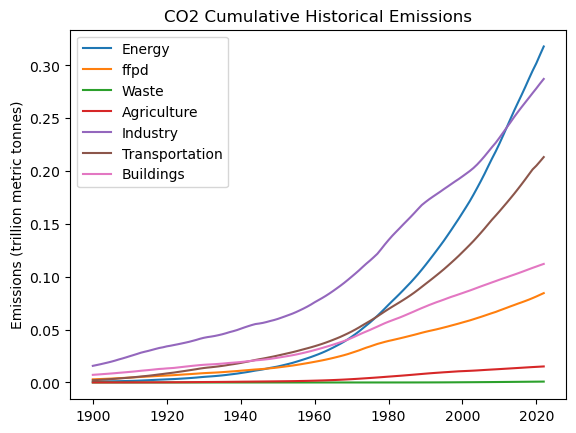

In [1355]:
# historical cumulative decayed sectoral emissions for each year in time series 
co2_hist_decayc.T.iloc[150:,:].div(1e9).plot()

plt.ylabel('Emissions (trillion metric tonnes)')

plt.legend(loc='upper left')

plt.title('CO2 Cumulative Historical Emissions')



<Axes: xlabel='sector'>

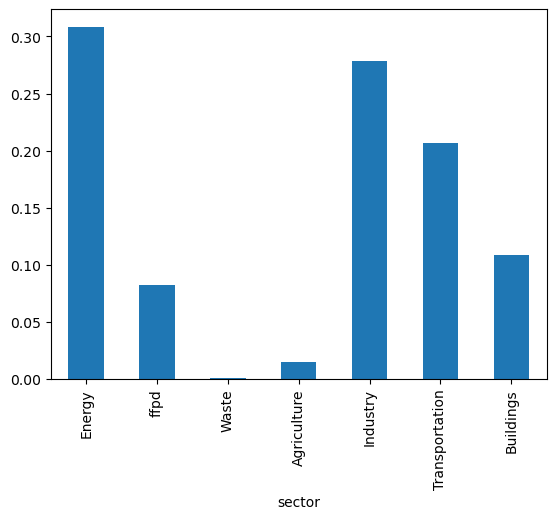

In [1356]:
# Bar Chart of Sectoral fraction contributions to emissions
(co2_hist_decayc.iloc[:,-1]/co2_hist_decayc.iloc[:,-1].sum(axis=0)).plot(kind = 'bar')

### CHECK
make sure decay model is correct

In [1357]:
#Original Equation that calculates the remaining CO2 for the present year (2022)
t = np.flip(np.arange(0,273,1))
carbon_decayedc = co2c_years.drop(columns = 'sector').apply(lambda x: carbd(x), axis=1)
carbon_decayedc['total'] = carbon_decayedc.sum(axis=1)
carbon_decayedc['sector'] = co2c_years.sector
# Sectoral fraction contributions to emissions
carbon_decayed_fractionc = carbon_decayedc.iloc[:,0:-1].div(carbon_decayedc.total, axis=0)

In [1358]:
# CHECK: if the cumulative decay emission (2022) match the simple decay sum, than good
carbon_decayedc.sum()['total'], co2_hist_decayc.iloc[:,-1].sum() #difference is negligible

(1031193494.2552786, 1031193494.2552791)

In [1359]:
 co2_hist_decayc

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sector,,,,,,,,,,,,,,,,,,,,,
Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.493764e+08,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08
ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,14521.264471,...,7.202186e+07,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07
Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.450119e+05,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05
Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329934e+07,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07
Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,27557.871692,...,2.461809e+08,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08
Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.742855e+08,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08
Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,31928.859256,...,1.008350e+08,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08


## Nitrous Oxide (N2O)
N2O emissions (kt) timeseries (1970-2022), CEDS v2021_04_21 has data in the fuel file from (1750-2019), so data for those years is used (1750-1969) and sectors are allocated backward using 1969 allocation

In [1360]:
#Try cumulative decay emissions for 1970-2022 timeseries data

# t = np.flip(np.arange(0,53,1))
def decay(t):
    return np.exp(-t/109)

n2oc_years = n2o.iloc[:,3:]
years = [int(col.split('X')[1]) for col in n2oc_years.columns if col.startswith('X')]
n2oc_years.columns = years
n2oc_years['sector'] = n2o.sector

# Generate Dataframe of N2O emissions prior to calculating cumulative decayed emissions
n2oc_years_pre = sum_and_rename2(n2oc_years).drop(columns = 'sector').set_index('sectors')
n2oc_years_pre#.sum()#.index

#Generate Dataframe of N2O emissions prior to calculating cumulative decayed emissions for 1970-2022 timeseries data w/o ffpd
n2oc_years_pre_noffpd = sum_and_rename3(n2o).groupby(by = 'sectors').sum().drop(columns = ['em','sector','units'])
years = [int(col.split('X')[1]) for col in n2oc_years_pre_noffpd.columns if col.startswith('X')]
n2oc_years_pre_noffpd.columns = years

# Run code to generate cumulative decayed emissions

cum_emiss = pd.DataFrame(index = n2oc_years_pre.index)
cum_emiss_noffpd = pd.DataFrame(index = n2oc_years_pre_noffpd.index)
for year in n2oc_years_pre.columns[0:]:
    #with ffpd
    cum_emiss[f'{year}'] =  n2oc_years_pre.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )
    #ffpd separated and allocated to other sectors
    cum_emiss_noffpd[f'{year}'] =  n2oc_years_pre_noffpd.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )


n2o_hist_decayc = cum_emiss# sum_and_rename2(cum_emiss).set_index('sectors').drop(columns = 'sector').T

In [1361]:
#CHECK to make sure sum of cumulative decay emissions from inclusive ffpd and partitioned ffpd are same
n2o_hist_decayc.sum()[-1], cum_emiss.sum()[-1]

(353886.1009621947, 353886.1009621947)

### Concatenate past emissions (1750-1969) to current sector allocated data (1970-2022)

In [1362]:
#load in CEDS historic emissions from fuel csv (v_2021_04_21)
n2o_cf= pd.read_csv(r'C:data\CEDS_v2021-04-21_emissions\N2O_global_CEDS_emissions_by_fuel_2021_04_21.csv')
n2o_cf = n2o_cf.groupby(by = 'em', as_index = False).sum().drop(columns = ['em','fuel','units'])

# Extrapolation code below not necessary because using (1750-1969) data
# n2o_cf[['X2020','X2021','X2022']] = np.nan
years = [int(col.split('X')[1]) for col in n2o_cf.columns if col.startswith('X')]
n2o_cf.columns = years
# n2o_cf.iloc[:,-8:] = n2o_cf.iloc[:,-8:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward", axis = 1)

In [1363]:
n2o_cf

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,365.305298,366.263846,367.222257,368.180415,369.138435,370.096259,371.064068,372.021505,372.978745,373.93579,...,9089.432786,9184.790563,9132.789298,9400.076436,9554.073397,9583.58638,9577.935584,9610.59056,9692.574706,9719.044243


In [1364]:
# Combine v_2021_04_21 emissions(1750-1969) with v_2024_04_01 emissions (1970-2022)

if choice_ffpd == 0:
    n2o_decay_use = n2oc_years_pre # with (n2oc_years_pre) or w/o ffpd (n2oc_years_pre_noffpd)
else:
    n2o_decay_use = n2oc_years_pre_noffpd

n2o_jp = pd.concat([n2o_cf.iloc[:, 0:220] * x for x in (n2o_decay_use.iloc[:,0]/n2o_decay_use.iloc[:,0].sum())], ignore_index=True).rename_axis(None, axis=1)#.set_index(n2oc_years_pre.index)
n2occ = pd.concat([n2o_jp, n2o_decay_use.reset_index(drop=True)], axis=1)
n2occ

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,3.058430,3.066455,3.074479,3.082501,3.090522,3.098541,3.106644,3.114660,3.122674,3.130686,...,330.223633,336.630817,329.72187,364.632617,372.72233,384.260537,375.645057,364.813424,398.211942,397.3359
1,0.740990,0.742934,0.744878,0.746822,0.748765,0.750708,0.752671,0.754613,0.756555,0.758496,...,22.728184,21.424018,21.701496,20.520131,20.846447,20.746186,21.40896,20.126673,20.215696,20.251264
2,13.412177,13.447370,13.482558,13.517737,13.552910,13.588077,13.623610,13.658762,13.693907,13.729045,...,542.487077,552.315445,560.590067,570.485949,579.791402,587.109848,591.441528,595.175282,601.103233,608.290274
3,213.673871,214.234543,214.795136,215.355580,215.915943,216.476193,217.042282,217.602305,218.162213,218.722006,...,6793.198626,6876.898133,7208.239623,7178.751432,7026.454371,7078.123943,7065.830271,7141.280317,7160.615061,7167.510821
4,108.004028,108.287426,108.570784,108.854068,109.137310,109.420495,109.706632,109.989702,110.272714,110.555668,...,1561.489137,1604.710077,1630.866157,1637.458216,1649.42239,1683.62907,1692.717749,1704.842246,1758.93416,1781.30796
5,15.691294,15.732468,15.773635,15.814792,15.855942,15.897085,15.938656,15.979782,16.020899,16.062008,...,378.252554,374.912646,366.862726,354.374169,362.068026,368.715652,381.765166,333.308668,355.698535,362.730535
6,10.724509,10.752650,10.780787,10.808916,10.837041,10.865161,10.893574,10.921682,10.949784,10.977881,...,202.307185,202.981311,202.054504,197.797548,198.085499,195.683947,193.027917,190.181529,190.545529,190.727328


In [1365]:
# Generate cumulative decayed emissions for each year (1750-2022)
t = np.flip(np.arange(0,273,1))
def decay(t):
    return np.exp(-t/109)
    
cum_emiss = pd.DataFrame(index = n2occ.index)
for year in n2occ.columns[0:]:
    """
    
   Description:
    Decay function is applying the decay to each year and calculating the cumulative emissions for each year
    (same as for CO2, but with associated decay function)
     
    """
    cum_emiss[f'{year}'] =  n2occ.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )

cum_emiss['sector'] = n2o_decay_use.index
n2o_hist_decaycl =cum_emiss.set_index('sector')#.drop(columns = 'sector')


In [1366]:
# scratch code
# sum(n2ocy[:n2ocy.index.get_loc(1871)][::-1]*[decay(j) for j in range(1, n2ocy.index.get_loc(1871)+1)])
# ((( n2ocy.iloc[:,1] + ( n2ocy.iloc[:,0] * np.exp(-1/109))))*np.exp(-1/109))+ n2ocy.iloc[:,2] # how the decay function is working for N2O
#((( n2occ.iloc[:,1] + ( n2occ.iloc[:,0] * np.exp(-1/109))))*np.exp(-1/109))+ n2occ.iloc[:,2] # how the decay function is working for N2O

### CHECK
make sure decay model is correct

In [1367]:
#Original Equation that calculates the remaining N2O for the present year (2022)
t = np.flip(np.arange(0,273,1))
def nitrod2(x):
    d = x * np.exp(-t/109)
    return d

n2o_decayedc = n2occ.reset_index(drop=True).apply(lambda x: nitrod(x), axis=1)
n2o_decayedc['total'] =n2o_decayedc.sum(axis=1)
n2o_decayedc['sector'] = n2oc_years_pre.index
n2o_decayed_fractionc = n2o_decayedc.iloc[:,0:-1].div(n2o_decayedc.total, axis=0)


In [1368]:
# CHECK: if the cumulative decay emission (2022) match the simple decay sum, than good
n2o_decayedc.sum()['total'], n2o_hist_decaycy.iloc[:,-1].sum() #difference is negligible

(444888.9500241908, 444888.95002419135)

Text(0.5, 1.0, 'N2O Cumulative Historical Emissions')

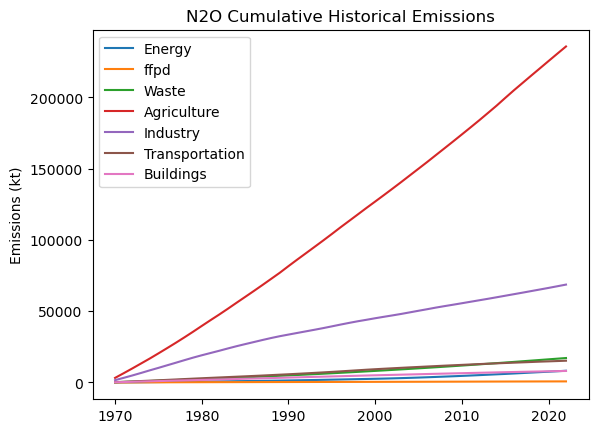

In [1369]:
# historical cumulative decayed sectoral emissions for each year in time series 

n2o_hist_decayc.T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('N2O Cumulative Historical Emissions')

Text(0.5, 1.0, 'N2O Cumulative Historical Emissions')

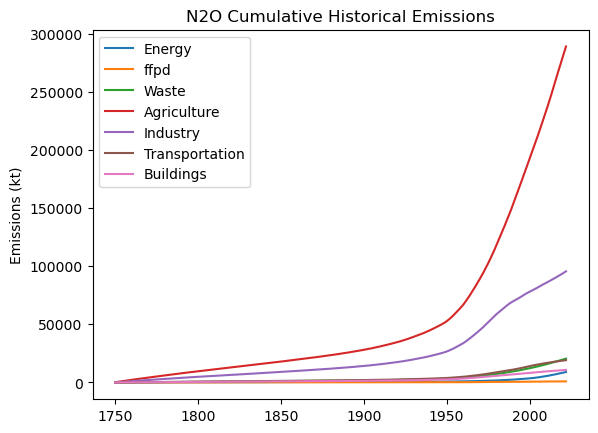

In [1370]:
# historical cumulative decayed sectoral emissions for each year in time series - full time series 
n2o_hist_decaycl.T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('N2O Cumulative Historical Emissions')

<Axes: xlabel='sector'>

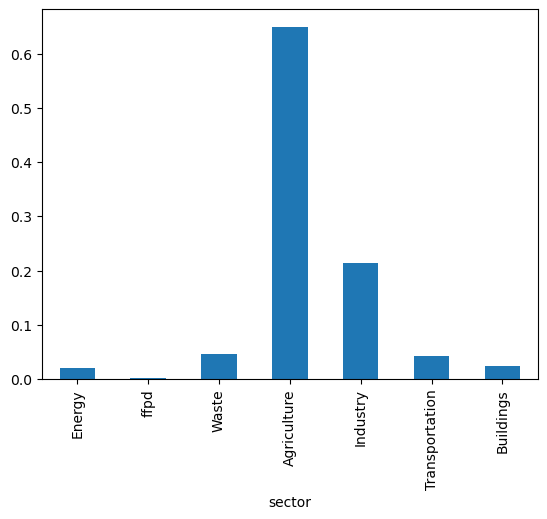

In [1371]:
# Bar Chart of Sectoral fraction contributions to emissions
(n2o_hist_decaycl.T.iloc[-1,:]/n2o_hist_decaycl.T.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

Text(0.5, 1.0, 'N2O Historical Emissions')

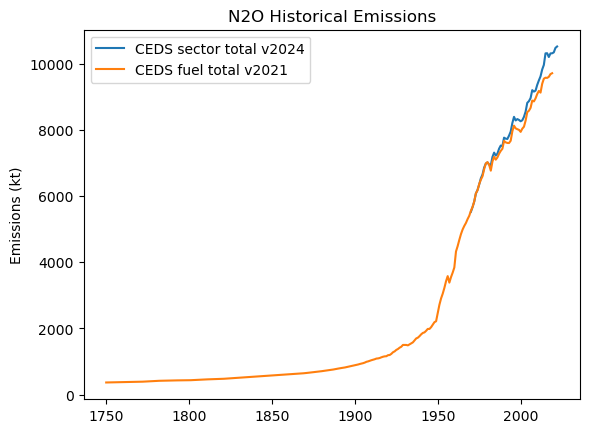

In [1372]:
# Raw emissions time series with sectoral emissions CEDS v2024 and fuel emissions CEDS v2021
sum_and_rename2(pd.read_csv(fl_CEDS[4])).drop(columns = {'em','sector','units'}).set_index('sectors').T.sum()
n2o_ceds = sum_and_rename2(pd.read_csv(fl_CEDS[4])).drop(columns = {'em','sector','units'}).set_index('sectors')
years = [int(col.split('X')[1]) for col in n2o_ceds.columns if col.startswith('X')]
n2o_ceds.columns = years


plt.plot(np.arange(1970,2023,1),n2o_ceds.T.sum(axis=1),  label = 'CEDS sector total v2024')
plt.plot(np.arange(1750,2020,1),n2o_cf.T.sum(axis=1),  label = 'CEDS fuel total v2021')
plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('N2O Historical Emissions')

## Methane (CH4)
CH4 emissions (kt) timeseries (1970-2022), CEDS v2021_04_21 has data in the fuel file from (1750-2019), so data for those years is used (1750-1969) and sectors are allocated backward using 1969 allocation

In [1373]:
#Try cumulative decay emissions for 1970-2022 timeseries data
ch4c_years = ch4.iloc[:,3:]
years = [int(col.split('X')[1]) for col in ch4c_years.columns if col.startswith('X')]
ch4c_years.columns = years
ch4c_years['sector'] = ch4.sector

# Generate Dataframe of CH4 emissions prior to calculating cumulative decayed emissions
ch4_ceds = sum_and_rename2(pd.read_csv(fl_CEDS[1])).drop(columns = {'em','sector','units'}).set_index('sectors')
ch4c_years_pre = sum_and_rename2(ch4c_years).drop(columns = 'sector').set_index('sectors')

# Generate Dataframe of CH4 emissions prior to calculating cumulative decayed emissions w/o ffpd
ch4c_years_pre_noffpd = sum_and_rename3(ch4).groupby(by = 'sectors').sum().drop(columns = ['em','sector','units'])
years = [int(col.split('X')[1]) for col in ch4c_years_pre_noffpd.columns if col.startswith('X')]
ch4c_years_pre_noffpd.columns = years

# Run code to generate cumulative decayed emissions

# t = np.flip(np.arange(0,53,1))
def decay(t):
    return np.exp(-t/11.8)

ch4c_years = ch4.iloc[:,3:]
years = [int(col.split('X')[1]) for col in ch4c_years.columns if col.startswith('X')]
ch4c_years.columns = years
ch4c_years['sectors'] = co2.sector

cum_emiss = pd.DataFrame(index = ch4c_years_pre.index)
cum_emiss_noffpd = pd.DataFrame(index = ch4c_years_pre_noffpd.index)
for year in ch4c_years_pre.columns[0:]:

    #with ffpd
    cum_emiss[f'{year}'] =  ch4c_years_pre.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )
    #ffpd separated and allocated to other sectors
    cum_emiss_noffpd[f'{year}'] =  ch4c_years_pre_noffpd.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )



ch4_hist_decayc = cum_emiss#sum_and_rename2(cum_emiss).set_index('sectors').drop(columns = 'sector').T
ch4_hist_decayc

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sectors,,,,,,,,,,,,,,,,,,,,,
Energy,311.871315,612.064647,902.096513,1179.961384,1435.591759,1677.864925,1905.471401,2116.588005,2313.112564,2501.707231,...,1.004901e+04,1.038343e+04,1.070769e+04,1.103660e+04,1.134840e+04,1.164694e+04,1.193466e+04,1.221061e+04,1.252925e+04,1.276600e+04
ffpd,111673.141216,211013.745839,305313.665617,397255.982592,479163.182430,552776.066838,623367.047497,690261.958296,752711.771991,813666.260645,...,1.498086e+06,1.513042e+06,1.525308e+06,1.534949e+06,1.544022e+06,1.553943e+06,1.562226e+06,1.562673e+06,1.564450e+06,1.568380e+06
Waste,34607.627470,68294.128597,100012.729751,129929.776299,158041.311818,184408.039061,209600.890030,233435.149703,256175.118076,277803.786783,...,7.418481e+05,7.535103e+05,7.654725e+05,7.774804e+05,7.900008e+05,8.031250e+05,8.164652e+05,8.296545e+05,8.430423e+05,8.566375e+05
Agriculture,98369.732883,190404.015448,275979.686112,356242.243934,432027.157826,503578.219901,569901.794699,631424.304777,688254.401712,740671.627498,...,1.483725e+06,1.496177e+06,1.508554e+06,1.521407e+06,1.534243e+06,1.547187e+06,1.559134e+06,1.571710e+06,1.583229e+06,1.593876e+06
Industry,494.824944,952.970478,1405.581014,1843.377417,2227.640359,2576.158546,2919.016609,3234.988878,3535.869805,3834.629639,...,1.160265e+04,1.201125e+04,1.235908e+04,1.268159e+04,1.305320e+04,1.346332e+04,1.383376e+04,1.415415e+04,1.451746e+04,1.478926e+04
Transportation,697.416314,1379.006467,2057.461975,2733.967700,3355.792047,3962.825538,4559.919546,5145.976328,5736.441986,6297.879988,...,1.601000e+04,1.622291e+04,1.643994e+04,1.662602e+04,1.678951e+04,1.694171e+04,1.707558e+04,1.705504e+04,1.707965e+04,1.706311e+04
Buildings,6933.689778,13461.240439,19620.180760,25400.111935,30816.611454,35998.059267,40869.430388,45461.492441,49841.971327,54037.430253,...,1.246114e+05,1.247468e+05,1.248333e+05,1.248379e+05,1.248806e+05,1.248191e+05,1.247813e+05,1.245759e+05,1.244955e+05,1.242344e+05


In [1374]:
#CHECK to make sure sum of cumulative decay emissions from inclusive ffpd and partitioned ffpd are same
ch4_hist_decayc.sum()[-1], cum_emiss_noffpd.sum()[-1]

(4187746.178542782, 4187746.178542782)

### Concatenate past emissions (1750-1969) to current sector allocated data (1970-2022)

In [1375]:
#Initial Attempt to extend ch4 and n2o CEDS emissions so timeseries is 1750-2019 like co2 & slcfs
ch4_yy = pd.read_excel(r'C:data\TotalHistoricalCH4N2OforBlake.xlsx', 'CH4')
emiss_tot_j = pd.read_csv(r'C:data\EMISSIONS_ANNUAL_1830-2021.csv')

#load in CEDS historic emissions from fuel csv (v_2021_04_21)
ch4_cf= pd.read_csv(r'C:data\CEDS_v2021-04-21_emissions\CH4_global_CEDS_emissions_by_fuel_2021_04_21.csv')

# Extrapolation code below not necessary because using (1750-1969) data
ch4_cf = ch4_cf.groupby(by = 'em', as_index = False).sum().drop(columns = ['em','fuel','units'])
# ch4_cf[['X2020','X2021','X2022']] = np.nan
years = [int(col.split('X')[1]) for col in ch4_cf.columns if col.startswith('X')]
ch4_cf.columns = years
# ch4_cf.iloc[:,-8:] = ch4_cf.iloc[:,-8:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward", axis = 1)
ch4_cf

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,24842.621574,24909.216935,24975.81612,25042.377053,25108.94181,25175.489354,25245.701525,25312.214629,25378.710518,25445.189193,...,351942.402122,354921.897235,356663.161614,358425.932442,360332.847766,359770.677166,357309.033465,357485.146366,360716.548043,362144.405847


In [1376]:
# Combine v_2021_04_21 emissions(1750-1969) with v_2024_04_01 emissions (1970-2022)

if choice_ffpd == 0:
    ch4_decay_use = ch4c_years_pre # with (ch4c_years_pre) or w/o ffpd (ch4c_years_pre_noffpd)
else:
    ch4_decay_use = ch4c_years_pre_noffpd


ch4_jp = pd.concat([ch4_cf.iloc[:, 0:220] * x for x in (ch4_decay_use.iloc[:,0]/ch4_decay_use.iloc[:,0].sum())], ignore_index=True).rename_axis(None, axis=1)#.set_index(n2oc_years_pre.index)
ch4cc = pd.concat([ch4_jp, ch4_decay_use.reset_index(drop=True)], axis=1)


In [1377]:
# Generate cumulative decayed emissions for each year (1750-2022)

# t = np.flip(np.arange(0,190,1))
def decay(t):
    return np.exp(-t/11.8)
    
cum_emiss = pd.DataFrame(index =ch4cc.index)
for year in ch4cc.columns[0:]:
    """
    
   Description:
    Decay function is applying the decay to each year and calculating the cumulative emissions for each year
    (same as for CO2, but with associated decay function)
     
    """
    cum_emiss[f'{year}'] =  ch4cc.apply(
        lambda row: row[year] + sum(
            row[:row.index.get_loc(year)][::-1]*[decay(j) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )
    

cum_emiss['sector'] = ch4_decay_use.index
ch4_hist_decaycl =cum_emiss.set_index('sector')#.drop(columns = 'sector')
ch4_hist_decaycl


,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
sector,,,,,,,,,,,,,,,,,,,,,
Energy,30.612640,58.819938,84.817343,108.784372,130.886005,151.273792,170.091506,187.462164,203.503325,218.322993,...,1.011545e+04,1.044447e+04,1.076377e+04,1.108813e+04,1.139573e+04,1.169043e+04,1.197461e+04,1.224732e+04,1.256298e+04,1.279699e+04
ffpd,10961.603299,21061.915324,30370.921265,38952.901160,46866.930591,54167.275721,60905.417943,67125.406401,72869.335652,78175.879894,...,1.521875e+06,1.534899e+06,1.545389e+06,1.553398e+06,1.560972e+06,1.569516e+06,1.576534e+06,1.575818e+06,1.576526e+06,1.579475e+06
Waste,3397.012740,6527.110381,9411.981409,12071.546278,14524.112574,16786.497441,18874.655016,20802.236180,22582.286079,24226.789889,...,7.492205e+05,7.602837e+05,7.716955e+05,7.831977e+05,7.952536e+05,8.079510e+05,8.208990e+05,8.337280e+05,8.467849e+05,8.600760e+05
Agriculture,9655.768404,18552.849520,26752.891337,34312.516334,41283.762533,47714.431471,53649.871660,59128.884756,64188.550670,68862.936417,...,1.504680e+06,1.515430e+06,1.526242e+06,1.537658e+06,1.549174e+06,1.560904e+06,1.571737e+06,1.583289e+06,1.593867e+06,1.603650e+06
Industry,48.570987,93.325583,134.573893,172.600743,207.667896,240.015807,269.872591,297.433430,322.884845,346.398202,...,1.170806e+04,1.210809e+04,1.244806e+04,1.276334e+04,1.312830e+04,1.353232e+04,1.389716e+04,1.421240e+04,1.457098e+04,1.483842e+04
Transportation,68.456935,131.534971,189.671175,243.266988,292.691346,338.283148,380.363905,419.208710,455.080451,488.220654,...,1.615857e+04,1.635941e+04,1.656534e+04,1.674123e+04,1.689536e+04,1.703897e+04,1.716494e+04,1.713713e+04,1.715507e+04,1.713240e+04
Buildings,680.596569,1307.716299,1885.704512,2418.552300,2909.927616,3363.199798,3781.565282,4167.759043,4524.394695,4853.873486,...,1.260885e+05,1.261039e+05,1.260801e+05,1.259834e+05,1.259330e+05,1.257860e+05,1.256697e+05,1.253920e+05,1.252453e+05,1.249233e+05


### CHECK
make sure decay model is correct

In [1378]:
#Original Equation that calculates the remaining N2O for the present year (2022)
t = np.flip(np.arange(0,273,1))
def methd(x):
    d = x * np.exp(-t/11.8)
    return d

ch4_decayedc = ch4cc.reset_index(drop=True).apply(lambda x: methd(x), axis=1)
ch4_decayedc['total'] =ch4_decayedc.sum(axis=1)
ch4_decayedc['sector'] = ch4c_years_pre.index
ch4_decayed_fractionc = ch4_decayedc.iloc[:,0:-2].div(ch4_decayedc.total, axis=0)
# ch4_decayedc

In [1379]:
# CHECK: if the cumulative decay emission (2022) match the simple decay sum, than good
ch4_decayedc.sum()['total'], ch4_hist_decaycl.iloc[:,-1].sum() #difference is negligible

(4212892.091239141, 4212892.091239141)

Text(0.5, 1.0, 'CH4 Historical Emissions')

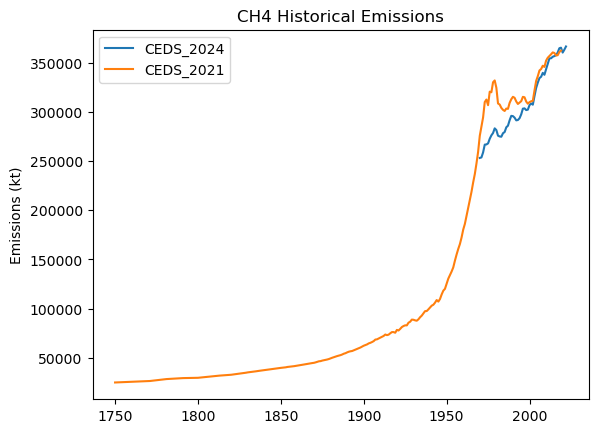

In [1380]:
# Raw emissions time series with sectoral emissions CEDS v2024 and fuel emissions CEDS v2021
plt.plot(np.arange(1970,2023,1),ch4c_years_pre.T.sum(axis=1),  label = 'CEDS_2024')
# # plt.plot(np.arange(1970,2020,1),n2o.iloc[:,3:].T.sum(axis=1),  label = 'CEDSi')
# plt.plot(np.arange(1830,2022,1), ch4_j2-50000, label = 'Jones et al 2023') # actual, not adjusted
# plt.plot(np.arange(1850,2040,10), ch4_yy.iloc[0,4:]*1000, label = 'YY')
plt.plot(np.arange(1750,2020,1),ch4_cf.T.sum(axis=1),  label = 'CEDS_2021')
plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('CH4 Historical Emissions')

Text(0.5, 1.0, 'CH4 Historical Emissions')

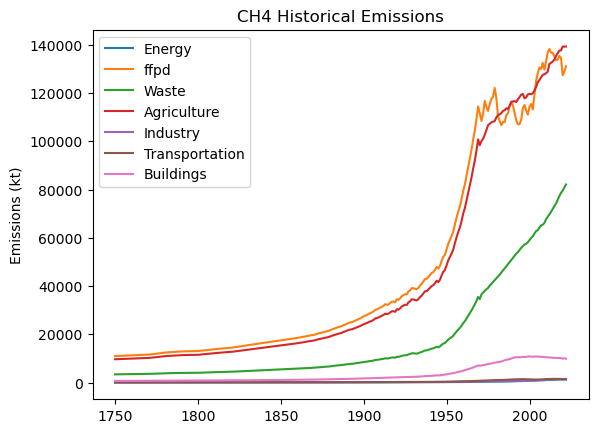

In [1381]:
# historical cumulative decayed sectoral emissions for each year in time series - full time series
ch4cc.set_index(ch4_decay_use.index).T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('CH4 Historical Emissions')

Text(0.5, 1.0, 'ch4 Cumulative Historical Emissions')

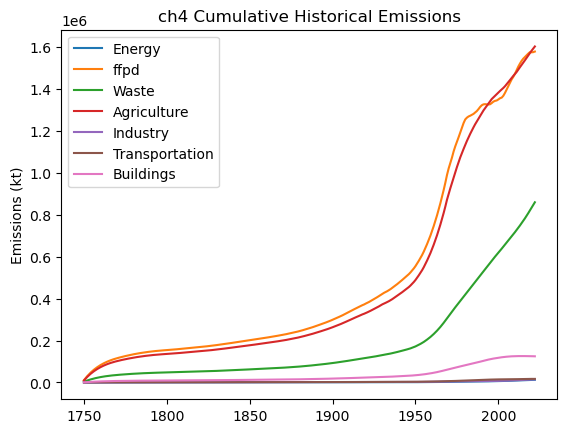

In [1382]:
# historical cumulative decayed sectoral emissions for each year in time series 
ch4_hist_decaycl.T.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

plt.title('ch4 Cumulative Historical Emissions')

<Axes: xlabel='sector'>

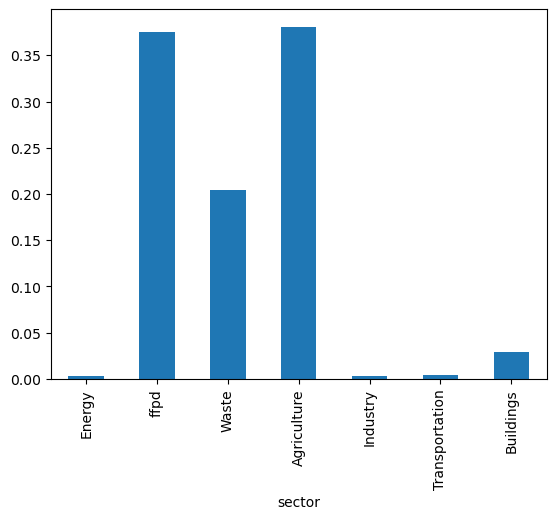

In [1383]:
# Bar Chart of Sectoral fraction contributions to emissions (1750-2022)
(ch4_hist_decaycl.T.iloc[-1,:]/ch4_hist_decaycl.T.iloc[-1,:].sum(axis=0)).plot(kind = 'bar')

<Axes: xlabel='sectors'>

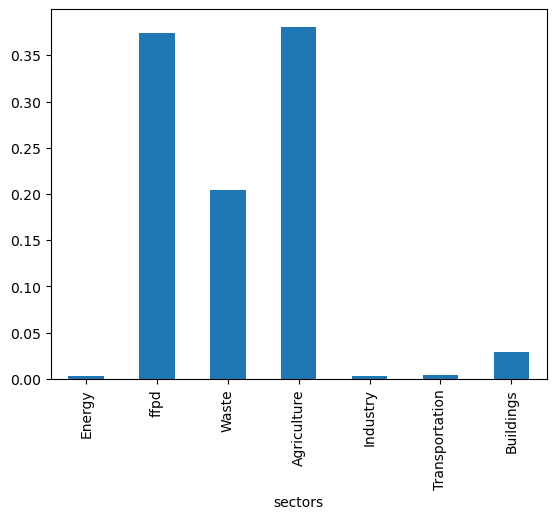

In [1384]:
# Bar Chart of Sectoral fraction contributions to emissions (1970-2022)
(ch4_hist_decayc.iloc[:,-1]/ch4_hist_decayc.iloc[:,-1].sum(axis=0)).plot(kind = 'bar')

In [1385]:
#Above charts are similar but not identical
print('Sectoral fraction contributions to emissions (1750-2022)', ch4_hist_decaycl.T.iloc[-1,:]/ch4_hist_decaycl.T.iloc[-1,:].sum(axis=0))
print()
print('Sectoral fraction contributions to emissions (1970-2022)',ch4_hist_decayc.iloc[:,-1]/ch4_hist_decayc.iloc[:,-1].sum(axis=0))


Sectoral fraction contributions to emissions (1750-2022) sector
Energy            0.003038
ffpd              0.374915
Waste             0.204153
Agriculture       0.380653
Industry          0.003522
Transportation    0.004067
Buildings         0.029653
Name: 2022, dtype: float64

Sectoral fraction contributions to emissions (1970-2022) sectors
Energy            0.003048
ffpd              0.374516
Waste             0.204558
Agriculture       0.380605
Industry          0.003532
Transportation    0.004075
Buildings         0.029666
Name: 2022, dtype: float64


## Very-SLCF
Generate DataFrame of yearly emissions with no decay function as lifetimes of SLCF or < 1 year

Text(0.5, 1.0, 'SLCF Historical Emissions')

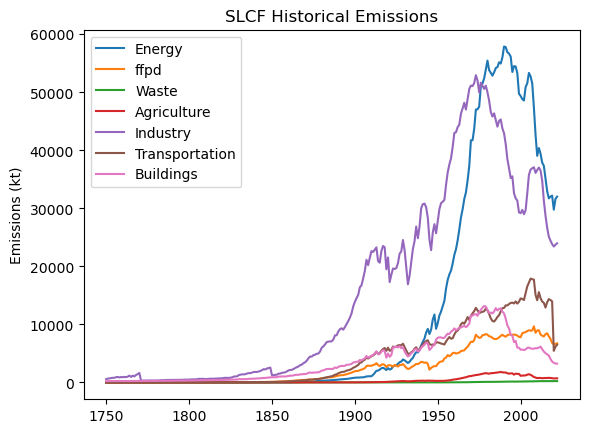

In [1386]:
# Plot SLCF Emission time series, change slcf to species of interest
slcf = so2c.T
slcf.plot()

plt.ylabel('Emissions (kt)')

plt.legend(loc='upper left')

# plt.set_xticklabels([int(col.split('X')[1]) for col in slcf.columns if col.startswith('X')])

plt.title('SLCF Historical Emissions')

In [1387]:
# co2c_years_pre
# n2oc_years_pre
# ch4c_years_pre

## Halogenated Compounds (HC)
### aka F-Gas
Data from EDGAR, UNEP, WMO 2022 Report. Utilize AFEAS (2003) and EDGAR for partitioning.

In [1388]:
# Load in Long Lived Halogenated Compounds Climate Forcers

f_gas = pd.read_excel(r'C:data\EDGAR_F-gases_1990-2021\EDGAR_F-gases_1990-2021.xlsx', 'IPCC 2006') # IPCC 2006 sectoR id (1990-2021)
f_gas2 = pd.read_excel(r'C:data\EDGAR_F-gases_1990-2021\EDGAR_F-gases_1990-2021.xlsx', 'IPCC 1996') # IPCC 1996 sectoR id (1990-2021)
f_gas_ar5 = pd.read_excel(r'C:data\EDGAR_AR5_F-gases_1990_2022\EDGAR_AR5_F-gases_1990_2022.xlsx', 'IPCC 2006') # does not include specific substance, only GWP 100
lts = pd.read_excel(r'C:data\lifetimes.xlsx')
lts = lts.rename(columns = {'compound':'Substance'})
ods = pd.read_csv(r'C:data\ozone-depleting-substance-consumption.csv')

In [1389]:
# IPCC 2006 sector id (1990-2021)
fg = f_gas.rename(columns=f_gas.iloc[9]).drop(f_gas.index[0:10]).reset_index(drop=True)
f_sectorfb = fg.groupby(by = ['ipcc_code_2006_for_standard_report_name','fossil_bio','Substance']).sum().reset_index()
f_sectorf = f_sectorfb[f_sectorfb.fossil_bio == 'fossil']
f_sectorb = f_sectorfb[f_sectorfb.fossil_bio == 'bio']

# IPCC 1996 sectoR id (1990-2021)
fg2 = f_gas2.rename(columns=f_gas2.iloc[9]).drop(f_gas2.index[0:10]).reset_index(drop=True)
f_sectorfb2 = fg2.groupby(by = ['ipcc_code_1996_for_standard_report_name','fossil_bio','Substance']).sum().reset_index()
f_sectorf2 = f_sectorfb2[f_sectorfb2.fossil_bio == 'fossil']
f_sectorb2 = f_sectorfb2[f_sectorfb2.fossil_bio == 'bio']

In [1390]:
fg['ipcc_code_2006_for_standard_report_name'].unique(), fg2['ipcc_code_1996_for_standard_report_name'].unique()

(array(['Product Uses as Substitutes for Ozone Depleting Substances',
        'Other Product Manufacture and Use', 'Metal Industry',
        'Chemical Industry', 'Electronics Industry'], dtype=object),
 array(['Commerical refrigeration', 'Aerosols', 'Closed cell foam',
        'Other F-gas use', 'Production of metals', 'Electrical Equipment',
        'Production of halocarbons and SF6',
        'Semiconductor/Electronics Manufacture', 'Domestic refrigeration',
        'Industrial refrigeration', 'Transport refrigeration',
        'Mobile Air Conditioning', 'Stationary Air Conditioning',
        'Fire Extinguishers', 'Solvents', 'Other ODS', 'Open cell foam',
        'F-gas as Solvent'], dtype=object))

In [1391]:
fg.ipcc_code_2006_for_standard_report.unique()
fg.Substance.unique()

array(['HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HCFC-141b', 'HCFC-142b',
       'C2F6', 'CF4', 'SF6', 'C3F8', 'C4F10', 'HFC-23', 'c-C4F8',
       'HFC-134', 'HFC-143', 'HFC-236fa', 'HFC-41', 'HFC-43-10-mee',
       'NF3', 'C5F12', 'C6F14'], dtype=object)

In [1392]:
fg2.ipcc_code_1996_for_standard_report.unique()
fg2.Substance.unique() # matches the 2006 for both name and emissions total per year

array(['HFC-125', 'HFC-134a', 'HFC-143a', 'HFC-152a', 'HFC-227ea',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HCFC-141b', 'HCFC-142b',
       'C2F6', 'CF4', 'SF6', 'C3F8', 'C4F10', 'HFC-23', 'c-C4F8',
       'HFC-134', 'HFC-143', 'HFC-236fa', 'HFC-41', 'HFC-43-10-mee',
       'NF3', 'C5F12', 'C6F14'], dtype=object)

In [1393]:
f_hcfc = f_sectorfb[f_sectorfb.Substance.isin(['HCFC-141b', 'HCFC-142b'])]
f_hcfc = f_hcfc.T.iloc[8:,0:].rename(columns = {32:'HCFC-141b', 33:'HCFC-142b'})
# f_hcfc.head()

In [1394]:
# load in data from WMO 2022 report shared by Luke Western, Bristol UK
import glob
import os
import pandas as pd

# the path to your csv file directory
wmo_path = 'data\WMO2022_AGAGE\WMO2022_AGAGE'
# make wmo ods dataframe 
wmo_ods = pd.DataFrame()
# initialize vaiables to track overall min and max years
min_year = float('inf')
max_year = float('-inf')
# iterate through folders in main folder
for compound_folder in os.listdir(wmo_path):
    compounds_folder_path  = os.path.join(wmo_path, compound_folder)

    #check if in directory
    if os.path.isdir(compounds_folder_path):
        output_folder_path = os.path.join(compounds_folder_path, 'outputs')

        #check if 'output' folder exists
        if os.path.exists(output_folder_path):
            #iterate through csv files in the 'output' folder
            for csv_file in os.listdir(output_folder_path):
                if csv_file.endswith('.csv'):
                    csv_file_path = os.path.join(output_folder_path, csv_file)

                    df = pd.read_csv(csv_file_path, skiprows = range (0,12))
                    compound_name = f"{compound_folder}_"
                    # min and max years
                    min_year = df['Year'].min()
                    max_year = df['Year'].max()

                    df.columns = [f"{compound_name}{col}" for col in df.columns]
                    df.set_index(f"{compound_name}Year", inplace = True)
                    #concatenate on common column
                    wmo_ods = pd.concat([wmo_ods, df.iloc[:,2:]], axis=1)

#create common index
com_ind = range (1970, 2021) #ignore any emissions after 2020. These were not published in the ozone assessment and were only preliminary when the files were made.
wmo_ods = wmo_ods.reindex(com_ind)
wmo_ods.columns = [col.split('_')[0] for col in wmo_ods.columns]
wmo_ods.columns = [f"{col}_sigma" if i % 2 != 0 else col for i, col in enumerate (wmo_ods.columns)] # add 'sigma' to the uncertainty (+/-) ['%' is the modulo operator]

# compounds in WMO report (1970-2020) not allocated to emitted sector
set([cols.split('_')[0] for cols in wmo_ods.columns])
# wmo_ods

import scipy
wmo_odsi = wmo_ods.copy()
add_rows = pd.DataFrame({col: [np.nan] * 2 for col in wmo_odsi.columns}, index = range(2021,2023)) #add rows to fill by linear extrapolation
wmo_odsi = pd.concat([wmo_odsi, add_rows])
# wmo_odsi = wmo_odsi.append(add_rows, ignore_index=False)
wmo_odsi.iloc[-8:,:] =wmo_odsi.iloc[-8:,:].interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
wmo_odsi.tail()

,CFC-11,CFC-11_sigma,CFC-113,CFC-113_sigma,CFC-114,CFC-114_sigma,CFC-115,CFC-115_sigma,CFC-12,CFC-12_sigma,...,HFC-236fa,HFC-236fa_sigma,HFC-245fa,HFC-245fa_sigma,HFC-32,HFC-32_sigma,HFC-365mfc,HFC-365mfc_sigma,HFC-4310mee,HFC-4310mee_sigma
2018,74.060985,10.234326,6.952877,5.803309,3.051586,0.926767,1.879363,0.546697,37.319438,20.992701,...,0.379875,0.082227,13.280821,2.041578,57.640280,5.159396,4.447337,0.926870,1.057672,0.316254
2019,50.146834,10.647507,5.961434,5.912160,2.630665,0.888081,1.619408,0.533886,17.235582,21.440230,...,0.384798,0.084202,13.617145,2.183559,65.469685,6.094375,4.373375,0.934955,1.214175,0.337358
2020,48.357969,10.043098,6.851856,5.991660,2.551198,0.882699,1.025666,0.556907,26.740262,21.479277,...,0.386032,0.085597,13.682335,2.297485,70.156393,7.016625,4.315673,0.961070,1.160374,0.335953
2021,46.569104,9.438689,7.742279,6.071160,2.471731,0.877317,0.431924,0.579928,36.244943,21.518325,...,0.387267,0.086992,13.747525,2.411410,74.843102,7.938874,4.257970,0.987185,1.106573,0.334547
2022,44.780239,8.834279,8.632702,6.150660,2.392264,0.871936,-0.161818,0.602949,45.749623,21.557373,...,0.388501,0.088387,13.812715,2.525336,79.529811,8.861124,4.200268,1.013299,1.052772,0.333142


In [1395]:
# ODS EMISSIONS FROM UNEP ARE IN TONNE ODP UNITS ODP = Tonne emission * ozone depleting potential

odp = {'Substance':['CFC-11', 'CFC-12','CFC-13','CFC-112','CFC-112a','CFC-113','HCFC-22',\
                     'HCFC-141b', 'HCFC-142b','Halon-1211', 'Halon-1301','Halon-2402',\
                    'TCA','MB','CTC'],'odp':[1,0.75,0.3,0.98,0.86,0.82,0.038,0.102,0.057,\
                                             0.32,0.313,0.332,0.12,0.57,0.87]}
odp = pd.DataFrame(data = odp)
ODS = ods[ods.Entity == 'World'].drop(columns = ['Entity','Code'])
ODS = ODS.rename(columns={ODS.columns[1]: 'TCA', ODS.columns[2]: 'MB', ODS.columns[3]: 'HCFC', ODS.columns[4]:\
                          'CTC',ODS.columns[5]: 'Halon',ODS.columns[6]: 'CFC'}).reset_index().drop(columns='index')
# ods.rename(columns={ods.columns[3:8]: 'TCA'})
ODS['Year'] ='Y_' + ODS['Year'].astype(str)
ODS['sector'] = 'Refridgeration/AC/Foam'
ODS = ODS.iloc[:,:] # we want 1990-2021 that matches w/ the EDGAR f-gas data

#represent the CFC emissions by the 3 main CFCs (by concentration) 0.55/0.35/0.10
ODS['CFC-12'] = ODS.CFC * 0.55
ODS['CFC-11'] = ODS.CFC * 0.35
ODS['CFC-113'] = ODS.CFC * 0.1

#represent the halon emissions by the 3 main halon (by emissions) 0.60/0.30/0.10
ODS['Halon-1211'] = ODS.Halon * 0.6
ODS['Halon-1301'] = ODS.Halon * 0.3
ODS['Halon-2402'] = ODS.Halon * 0.1

#reasonable to assume total HCFC-22 emissions = HCFC total - (HCFC-141b + HCFC-142b)?
matches = dict(zip(odp['Substance'], odp['odp']))

# need to convert emissions of HCFC-141b & 142b to ODP tonnes to extract HCFC-22
f_hcfcb = f_hcfc.copy()*1000
for col in f_hcfcb.columns:
    if col in matches:
        f_hcfcb[col] *= matches[col]

# ODS['HCFC-22'] = ODS.HCFC - (f_hcfcb['HCFC-141b']+f_hcfcb['HCFC-142b']).values

# divide out odp to get emissions in tons
for col in ODS.columns:
    if col in matches:
        ODS[col] /= matches[col]
ODS.head()
ODS = ODS.T
ODS.columns = ODS.iloc[0,:]

ODS = ODS.drop(['Year', 'sector'])
ODS = ODS.rename_axis(None, axis=1)
# years = [int(col.split('_')[1]) for col in ODS.columns if col.startswith('Y_')]
# ODS.columns = years
# ODS.head()
ODS['Y_2022'] = pd.Series(dtype='int')
og_columns = ODS.columns
ODS = ODS.T.reset_index(drop=True).apply(pd.to_numeric)
# ODS['CFC-12']/odp.iloc[1,1]
ODSi = ODS.copy()
ODSi.iloc[-8:,:] = ODSi.iloc[-8:,:].interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")
ODS = ODS.T
ODSi = ODSi.T
ODS.columns = og_columns
ODSi.columns = og_columns

In [1396]:
ODSi

,Y_1986,Y_1989,Y_1990,Y_1991,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,Y_1997,...,Y_2013,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022
TCA,3.833333e+01,5.472283e+05,139616.666667,298943.333333,472397.500000,317365.000000,118464.166667,128799.158333,24140.000000,19125.000000,...,-212.500000,-50.833333,-186.666667,-261.666667,-390.000000,-343.333333,-313.333333,-269.166667,-180.833333,-92.500000
MB,2.157895e+01,2.243860e+02,747.543860,67833.859649,6353.508772,9300.526316,38308.421053,65522.105263,61651.403509,66799.298246,...,2534.385965,1121.754386,566.315789,994.386053,366.315789,-0.701754,20.701760,-25.614035,424.736842,875.087719
HCFC,2.340000e+01,1.433570e+04,4636.800300,6968.000000,14613.101000,19307.900000,25047.000000,33001.700000,29207.300000,30324.100000,...,31999.530000,31897.770000,26399.140000,25718.970000,25186.430000,24272.630000,23568.900000,13086.870000,16232.840000,19378.810000
CTC,6.011494e+01,4.018287e+05,69787.241379,48806.783908,107080.000000,147144.367816,39855.747126,-12424.255172,1771.954023,-30422.875862,...,-2612.413563,-209.885046,-2126.436782,-3327.816092,-3594.827586,-2743.792989,-418.390805,-2346.091954,1518.735632,5383.563218
Halon,2.178938e+05,1.867935e+05,162598.500000,152481.700000,122431.800000,85682.500000,35372.000000,46065.098000,46161.098000,50282.700000,...,-67.300000,-154.099990,-316.800000,-311.800000,-48.600000,-22.800000,-282.700000,-653.399960,-268.600000,116.199960
CFC,1.084638e+06,1.041673e+06,732449.200000,615878.700000,566976.600000,489382.300000,358946.780000,285589.780000,177772.200000,175267.900000,...,-1848.700000,-1399.700000,-1493.000000,-1539.800000,-1607.800000,-1154.600000,-1609.900000,-807.000000,-847.900000,-888.800000
CFC-12,7.954016e+05,7.638937e+05,537129.413333,451644.380000,415782.840000,358880.353333,263227.638667,209432.505333,130366.280000,128529.793333,...,-1355.713333,-1026.446667,-1094.866667,-1129.186667,-1179.053333,-846.706667,-1180.593333,-591.800000,-621.793333,-651.786667
CFC-11,3.796235e+05,3.645856e+05,256357.220000,215557.545000,198441.810000,171283.805000,125631.373000,99956.423000,62220.270000,61343.765000,...,-647.045000,-489.895000,-522.550000,-538.930000,-562.730000,-404.110000,-563.465000,-282.450000,-296.765000,-311.080000
CFC-113,1.322730e+05,1.270333e+05,89323.073171,75107.158537,69143.487805,59680.768293,43773.997561,34828.021951,21679.536585,21374.134146,...,-225.451220,-170.695122,-182.073171,-187.780488,-196.073171,-140.804878,-196.329268,-98.414634,-103.402439,-108.390244
Halon-1211,4.085509e+05,3.502378e+05,304872.187500,285903.187500,229559.625000,160654.687500,66322.500000,86372.058750,86552.058750,94280.062500,...,-126.187500,-288.937481,-594.000000,-584.625000,-91.125000,-42.750000,-530.062500,-1225.124925,-503.625000,217.874925


In [1397]:
f_sector = f_sectorfb
fd = pd.concat([f_sector.iloc[0:,0:3],f_sector.iloc[0:,8:41]], axis=1).rename(columns = {'ipcc_code_2006_for_standard_report_name':'sectors'})
f_sector2 = f_sectorfb2
fd2 = pd.concat([f_sector2.iloc[0:,0:3],f_sector2.iloc[0:,8:41]], axis=1).rename(columns = {'ipcc_code_1996_for_standard_report_name':'sectors'})

In [1398]:
# Extrapolate EDGAR F-gas emissions to 2022
fd['Y_2022'] = np.nan
fdi = fd.copy().T.reset_index(drop=True)
fdi.iloc[-8:,:] = fdi.iloc[-8:,:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
# wmo_odsi = wmo_ods.interpolate(method='polynomial', order=2, fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
fdi = fdi.T
fdi.columns = fd.columns
fdi

fd2['Y_2022'] = np.nan
fdi2 = fd2.copy().T.reset_index(drop=True)
fdi2.iloc[-8:,:] = fdi2.iloc[-8:,:].astype(float).interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
# wmo_odsi = wmo_ods.interpolate(method='polynomial', order=2, fill_value="extrapolate",limit_direction="forward")#, limit_direction="both") #defualt direction is forward
fdi2 = fdi2.T
fdi2.columns = fd.columns
fdi2

,sectors,fossil_bio,Substance,Y_1990,Y_1991,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,...,Y_2013,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022
0,Aerosols,fossil,HFC-134a,0.001367,0.002653,0.15753,0.643113,1.784154,8.587345,10.990198,...,15.923371,16.582881,16.805114,15.446567,14.219954,12.341481,11.898244,10.71547,9.916429,9.117389
1,Aerosols,fossil,HFC-152a,0.011408,1.250612,2.499048,3.683931,4.972305,6.387459,7.839154,...,28.766403,30.34744,31.732051,32.808588,34.198822,35.312753,37.019846,38.402006,39.932972,41.463939
2,Aerosols,fossil,HFC-227ea,0,0,0,0.0,0.000016,0.015414,0.064784,...,2.051082,2.148564,2.24223,2.35144,2.45067,2.580218,2.677873,2.785115,2.899825,3.014534
3,Closed cell foam,fossil,HFC-134a,0,0,0.256216,0.289906,0.298375,0.422005,0.436728,...,5.701914,6.098397,6.54977,6.798449,6.751864,6.872923,6.918941,6.960063,7.011093,7.062123
4,Closed cell foam,fossil,HFC-227ea,0,0,0,0,0,0.000032,0.000025,...,0.059413,0.071053,0.08848,0.098745,0.106024,0.115586,0.114302,0.119488,0.125365,0.131243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,Stationary Air Conditioning,fossil,HFC-32,0.000708,0.000957,0.001073,0.001212,0.001357,0.002385,0.005949,...,10.641908,12.711697,14.833001,17.35405,20.207372,23.236536,25.958297,28.826379,32.046775,35.26717
102,Transport refrigeration,fossil,HFC-125,0,0,0,0.004102,0.012323,0.026937,0.045701,...,0.939713,1.027086,1.093037,1.164637,1.226268,1.286183,1.366682,1.43403,1.508381,1.582732
103,Transport refrigeration,fossil,HFC-134a,0.000016,0.000042,0.000231,0.008805,0.023015,0.061912,0.126734,...,1.343734,1.418013,1.446441,1.509053,1.537455,1.566045,1.613833,1.648759,1.691228,1.733697
104,Transport refrigeration,fossil,HFC-143a,0,0,0,0.004847,0.013906,0.030848,0.04933,...,1.028784,1.108918,1.165471,1.232412,1.28913,1.335541,1.397362,1.452345,1.515652,1.57896


In [1399]:
#assign sector to compound based on main use in the literature
ODS2 = ODSi.copy()#.drop(columns = 'sector').T
# ODS2.columns = ODS2.iloc[0]
ODS2 = ODS2.reset_index().rename_axis(None, axis=1).rename(columns = {'index':'Substance'})
ODS2.iloc[:,1:] = ODS2.iloc[:,1:]/1000 # tonnes to kt
ODS2['sectors'] = 'Refridgeration/Foam/AC'
ODS2 = ODS2.iloc[[0,1,3,6,7,8,9,10,11],:]

# ODS2.mask(ODS2 < 0, 0)
#assign sector to compound based on main use in the literature
ODS2[ODS2.iloc[:,1:-1] <0] = 0
ODS2['sectors'] = ['Electronics Industry', 'Chemical Industry', 'Chemical Industry', '','','Electronics Industry',\
                   'Electronics Industry', 'Chemical Industry', 'Chemical Industry']
ODS2

,Substance,Y_1986,Y_1989,Y_1990,Y_1991,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,...,Y_2014,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,sectors
0,TCA,0.038333,547.228333,139.616667,298.943333,472.397500,317.365000,118.464167,128.799158,24.140000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,Electronics Industry
1,MB,0.021579,0.224386,0.747544,67.833860,6.353509,9.300526,38.308421,65.522105,61.651404,...,1.121754,0.566316,0.994386,0.366316,0.0,0.020702,0.0,0.424737,0.875088,Chemical Industry
3,CTC,0.060115,401.828736,69.787241,48.806784,107.080000,147.144368,39.855747,0.000000,1.771954,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.518736,5.383563,Chemical Industry
6,CFC-12,795.401567,763.893680,537.129413,451.644380,415.782840,358.880353,263.227639,209.432505,130.366280,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,
7,CFC-11,379.623475,364.585620,256.357220,215.557545,198.441810,171.283805,125.631373,99.956423,62.220270,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,
8,CFC-113,132.272988,127.033317,89.323073,75.107159,69.143488,59.680768,43.773998,34.828022,21.679537,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,Electronics Industry
9,Halon-1211,408.550875,350.237812,304.872187,285.903188,229.559625,160.654687,66.322500,86.372059,86.552059,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.217875,Electronics Industry
10,Halon-1301,208.843898,179.035304,155.845208,146.148594,117.346773,82.123802,33.902875,44.151851,44.243864,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.111374,Chemical Industry
11,Halon-2402,65.630663,56.263102,48.975452,45.928223,36.877048,25.807982,10.654217,13.875030,13.903945,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.035000,Chemical Industry


In [1400]:
# fd5.iloc[20:40,:]
# fd5[fd5.Substance == 'HFC-125']
# fdi2[fdi2.Substance == 'HFC-365mfc']

In [1401]:
fdi2.sectors.unique()

array(['Aerosols', 'Closed cell foam', 'Commerical refrigeration',
       'Domestic refrigeration', 'Electrical Equipment',
       'F-gas as Solvent', 'Fire Extinguishers',
       'Industrial refrigeration', 'Mobile Air Conditioning',
       'Open cell foam', 'Other F-gas use', 'Other ODS',
       'Production of halocarbons and SF6', 'Production of metals',
       'Semiconductor/Electronics Manufacture', 'Solvents',
       'Stationary Air Conditioning', 'Transport refrigeration'],
      dtype=object)

In [1402]:
#Re-label to get matching sectors for the different f-gas inventories
def label_HC(row):
   if row['Substance'] in (["CFC-11","CFC-115", "CFC-12", "CFC-13", "HCFC-22", 'HFC-365mfc','HCFC-141b','HFC-245fa','HFC-125']):
      return 'Refridgeration/Foam/AC'
   if row['Substance'] in (["CFC-113","CFC-114"]):
      return 'Electronics Industry'
   return row['sectors']

def label_fgas_to_ceds(row):
   if row['sectors'] in (['Aerosols', 'F-gas as Solvent','Other F-gas use', 'Other ODS','Production of halocarbons and SF6', 'Production of metals',\
                         'Semiconductor/Electronics Manufacture','Solvents','Electrical Equipment','Industrial refrigeration']): #uncertain about 'Electrical Equipment'
      return 'Industry'
   if row['sectors'] in (['Closed cell foam','Commerical refrigeration','Domestic refrigeration','Fire Extinguishers','Open cell foam',\
                         'Stationary Air Conditioning']):
      return 'Buildings'
   if row['sectors'] in (['Mobile Air Conditioning','Transport refrigeration']):
      return 'Transportation'
   return row['sectors']

In [1403]:
# wmo_odsi

In [1404]:
#Preliminary assignment of sectors to WMO species, final sectoral assignment using EDGAR data
wmo_ods2 = wmo_odsi.copy()
wmo_ods2['Year'] = wmo_ods2.index
wmo_ods2['Year'] ='Y_' + wmo_ods2['Year'].astype(str)#.T.drop(columns = 2022)
wmo_ods2 = wmo_ods2.set_index(['Year']).T.reset_index().rename_axis(None, axis=1).rename(columns = {'index':'Substance'})#.drop(columns = 'Y_2022')
wmo_ods2[wmo_ods2.iloc[:,1:-1] <0] = 0
wmo_ods2['sectors'] = 'Refridgeration/Foam/AC'
# wmo_ods2.reset_index().rename(columns = {'index':'Substance'})
# wmo_ods2.set_index('Year')#.T#.reset_index().rename(columns = {'index':'Substance'})
wmo_ods2['Substance'].replace('HFC-4310mee','HFC-43-10-mee', inplace=True) # change name of compound so matches EDGAR
# wmo_ods2 = wmo_ods2.iloc[::2, :]
# [f"{col}_sigma" if i % 2 != 0 else row for i, col in enumerate (wmo_ods.columns)]
# wmo_ods2.sectors = ['Refridgeration/Foam/AC', 'Electronics Industry',]
wmo_ods2['sectors'] = wmo_ods2.apply(label_HC, axis=1)
# fd_years.apply(lambda x: fluod(x), axis=1)
wmo_ods2 = wmo_ods2.iloc[::2, :]
# wmo_ods2

In [1405]:
# fdi

In [1406]:
# Start of sector allocation to HC species using EDGAR data

fd_use = fdi2 #decide which f-gas sector to use (ie 2006 (fdi) or 1996 code (fdi2))
fd2 = pd.concat([fd_use ,ODS2])
fd3 = fd2.merge(lts, on = 'Substance',how ='left')
y = fd3['lifetime'].to_numpy()
# fd3 = fd2[fd2.Substance.str.contains('HCFC')]
# fd4 = pd.concat([fd,wmo_ods2])

#get unqiue compounds from each of the inventories (EGDAR, WMO, UNEP ODS) and combine
merged_df = pd.merge(fd_use , wmo_ods2, on = 'Substance', how = 'outer', indicator = True) 
edgar_f_keep = np.unique(merged_df[merged_df['_merge'] == 'left_only'].Substance.values)
wmo_only = np.unique(merged_df[merged_df['_merge'] == 'right_only'].Substance.values)
fd_keep = fd_use[fd_use.Substance.isin(edgar_f_keep)]#.drop(fd[fd.Substance == 'HFC-43-10-mee'].index)
fd_match = (fd_use[~fd_use.isin(fd_keep)]).dropna().reset_index(drop = True)

wmo_keep = wmo_ods2[wmo_ods2.Substance.isin(wmo_only)]
wmo_comp = wmo_ods2[~wmo_ods2.Substance.isin(wmo_only)]

fd4 = pd.concat([wmo_ods2,fd_keep])
merged_df2 = pd.merge(fd4, ODS2, on = 'Substance', how = 'outer', indicator = True)

ods_keep = np.unique(merged_df2[merged_df2['_merge'] == 'right_only'].Substance.values)
ods2_keep = ODS2[ODS2.Substance.isin(ods_keep)]

fd4 = pd.concat([fd4,ods2_keep], ignore_index=True)

fd5 = fd4.merge(lts, on = 'Substance',how ='left')
y = fd5['lifetime'].to_numpy()

In [1407]:
ods2_keep.Substance.unique()

array(['TCA', 'MB', 'CTC', 'Halon-1211', 'Halon-1301', 'Halon-2402'],
      dtype=object)

In [1408]:
# fd5

In [1409]:
### wmo_ods2
# fd5[~fd5.Substance.str.contains('sigma')]
fd5[fd5.Substance.str.contains('HFC-143')]
fd5.Substance.unique()

array(['CFC-11', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-12', 'CFC-13',
       'HCFC-141b', 'HCFC-142b', 'HCFC-22', 'HFC-125', 'HFC-134a',
       'HFC-143a', 'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa',
       'HFC-245fa', 'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee', 'SF6',
       'C6F14', 'C4F10', 'CF4', 'c-C4F8', 'C2F6', 'C3F8', 'HFC-134',
       'HFC-143', 'HFC-41', 'C5F12', 'NF3', 'TCA', 'MB', 'CTC',
       'Halon-1211', 'Halon-1301', 'Halon-2402'], dtype=object)

In [1410]:
#partition WMO emissions using the EDGAR sectoral fractions for the common compounds
df1 = fd_match.drop(columns = 'fossil_bio')
df2 = wmo_comp
df3 = pd.DataFrame()

for substance in df2['Substance'].unique():
    subset_df2 = df2[df2['Substance'] == substance]
    subset_df1 = df1[df1['Substance'] == substance]
    df1_total_emissions = subset_df1.groupby('Substance').sum()
    df1_frac = pd.DataFrame(index = subset_df1.index)

    for year in df1.columns[2:]:
        if df1_total_emissions[f'{year}'].iloc[0] == 0:
            df1_frac[f'{year}']  = subset_df1[f'{(df1_total_emissions.iloc[:,1:].iloc[0]>0).idxmax()}'] / df1_total_emissions[f'{(df1_total_emissions.iloc[:,1:].iloc[0]>0).idxmax()}'].values
        else:
            df1_frac[f'{year}']  = subset_df1[f'{year}'] / df1_total_emissions[f'{year}'].values
    #partition older years (1970-1989) based on 1990 fractions       
    years = list(range(1970,1990))
    df1_frac_exp = pd.DataFrame(index = df1_frac.index)
    for yr in years:
        df1_frac_exp[f'Y_{yr}'] = df1_frac[f'Y_{Yr}'] if f'Y_{yr}' in df1_frac.columns else df1_frac['Y_1990'].values

    df1_frac = pd.concat([df1_frac_exp, df1_frac], axis = 1)

    df2_part = df1_frac.multiply(np.array(subset_df2.filter(regex='Y_')), axis='columns')
    df2_part['Substance'] = subset_df2.Substance.iloc[0]
    df2_part['sectors'] = subset_df1.sectors
    df3 = pd.concat([df3,df2_part])



In [1411]:
# df3[((df3.Substance.str.contains('HFC-134a')) & (df3['sectors'].isin(duplicate)))]
df3.Substance.unique()

array(['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
       'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee'], dtype=object)

In [1412]:
df3.sectors.unique() 

array(['Other F-gas use', 'Commerical refrigeration',
       'Domestic refrigeration', 'Fire Extinguishers',
       'Industrial refrigeration', 'Mobile Air Conditioning', 'Other ODS',
       'Production of halocarbons and SF6',
       'Semiconductor/Electronics Manufacture', 'Solvents',
       'Stationary Air Conditioning', 'Transport refrigeration',
       'Aerosols', 'Closed cell foam', 'Open cell foam'], dtype=object)

In [1413]:
fdi2.sectors.unique()

array(['Aerosols', 'Closed cell foam', 'Commerical refrigeration',
       'Domestic refrigeration', 'Electrical Equipment',
       'F-gas as Solvent', 'Fire Extinguishers',
       'Industrial refrigeration', 'Mobile Air Conditioning',
       'Open cell foam', 'Other F-gas use', 'Other ODS',
       'Production of halocarbons and SF6', 'Production of metals',
       'Semiconductor/Electronics Manufacture', 'Solvents',
       'Stationary Air Conditioning', 'Transport refrigeration'],
      dtype=object)

In [1414]:
#load AFEAS data (1931-2000) from https://unfccc.int/gcse?q=afeas
af_cfc12 = pd.read_excel(r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Emerging Carbon Technologies\Research Analyst - Blake\anthro_emissions_mitgation\data\afeas_cfc_12.xlsx')
af_cfc11 = pd.read_excel(r'C:\Users\bwalkowiak\OneDrive - Environmental Defense Fund - edf.org\Emerging Carbon Technologies\Research Analyst - Blake\anthro_emissions_mitgation\data\afeas_cfc_11.xlsx')

In [1415]:
af_cfc12

,Year,Production_annual,Released_annual,Production_total,Released_total,Unreleased_total,Sales_ref_h,Released_ref_h,Unreleased_ref_h,Sales_ref_nh,...,Unnamed: 1250,Unnamed: 1251,Unnamed: 1252,Unnamed: 1253,Unnamed: 1254,Unnamed: 1255,Unnamed: 1256,Unnamed: 1257,Unnamed: 1258,Unnamed: 1259
0,1931,0.5,0.1,0.5,0.1,0.5,0,0,0,0.5,...,41.8,4857.7,4753.6,104.1,546.6,546.3,0.2,6150.3,6147.9,2.4


In [1416]:
#Retrieve fractions from AFEAS data of CFC-11 and CFC-12
af_cfc11['Substance'] = 'CFC-11'
af_cfc12['Substance'] = 'CFC-12'


def frac_cfc(df):
    cols_per_yr = 18
    subset_dfs = []
    df2 = df.iloc[:,:-1].copy()
    # df2 = df.copy()
    for i in range(0, len(df2.columns), 18):
        subset_df = df2.iloc[:,i:i + 18]
        subset_df.columns = range(subset_df.columns.size)
        subset_dfs.append(subset_df)
    
    cfc = pd.concat(subset_dfs, axis = 0,ignore_index = True)
    cfc.columns = ['Year','Production_annual', 'Released_annual', 'Production_total', 'Released_total', 'Unreleased_total', 'Sales_ref_h',\
                       'Released_ref_h', 'Unreleased_ref_h', 'Sales_ref_nh', 'Released_ref_nh', 'Unreleased_ref_nh', 'Sales_foam_closed',\
                       'Released_foam_closed','Unreleased_foam_closed', 'Sales_foam_open', 'Released_foam_open', 'Unreleased_foam_open']
     # Annual,Total, Refrigeration HERMETIC, Refrigeration NON Hermetic, Blowing Agents Closed Cell Foam, Open Cell Foam Aerosols & Others
    # cfc_12 =  [f"{col}_sigma" if i % 2 != 0 else col for i, col in enumerate (wmo_ods.columns)] # '%' is the modulo operator calc the remainder
    
    #fractions of each use-case from total released
    cfc['ref_h_frac'] = cfc.Released_ref_h / cfc.Released_total # Refrigeration HERMETIC
    cfc['ref_nh_frac'] = cfc.Released_ref_nh / cfc.Released_total # Refrigeration NON Hermetic
    cfc['fc_frac'] = cfc.Released_foam_closed / cfc.Released_total # Closed foam
    cfc['fo_frac'] = cfc.Released_foam_open / cfc.Released_total # Open foam
    #check
    cfc['frac_check'] = cfc.iloc[:,-4:].sum(axis=1)
    
    cfc_2 = cfc.copy()
    cfc_2  = cfc_2.iloc[:, [0] + list(range(-5,-1))]
    cfc_2['Year'] ='Y_' + cfc_2['Year'].astype(str)#.T.drop(columns = 2022)
    cfc_2  = cfc_2.set_index(['Year']).T.reset_index().rename_axis(None, axis=1).rename(columns = {'index':'sectors'})#.drop(columns = 'Y_2022')
    cfc_2['Substance'] = [df.iloc[:,-1].values[0]] * 4
    return cfc_2

In [1417]:
cfc_12_2 = frac_cfc(af_cfc12)
cfc_11_2 = frac_cfc(af_cfc11)
cfc_2 = pd.concat([cfc_11_2, cfc_12_2])

In [1418]:
cfc_2

,sectors,Y_1931,Y_1932,Y_1933,Y_1934,Y_1935,Y_1936,Y_1937,Y_1938,Y_1939,...,Y_1992,Y_1993,Y_1994,Y_1995,Y_1996,Y_1997,Y_1998,Y_1999,Y_2000,Substance
0,ref_h_frac,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,CFC-11
1,ref_nh_frac,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000,1.00,...,0.076750,0.078294,0.080307,0.082085,0.083528,0.084699,0.085615,0.086259,0.086643,CFC-11
2,fc_frac,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00,...,0.175553,0.186129,0.189413,0.192840,0.196183,0.199477,0.202745,0.205936,0.209067,CFC-11
3,fo_frac,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.00,...,0.747697,0.735563,0.730280,0.725076,0.720289,0.715823,0.711640,0.707805,0.704290,CFC-11
0,ref_h_frac,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.00,...,0.008100,0.008474,0.008872,0.009283,0.009718,0.010172,0.010640,0.011123,0.011604,CFC-12
1,ref_nh_frac,0.0,1.0,1.0,1.0,0.875,0.923077,0.904762,0.909091,0.92,...,0.357703,0.367990,0.377614,0.386333,0.393892,0.400062,0.404791,0.408159,0.410423,CFC-12
2,fc_frac,0.0,0.0,0.0,0.0,0.000,0.000000,0.000000,0.000000,0.00,...,0.050613,0.050487,0.050008,0.049351,0.048689,0.048140,0.047712,0.047392,0.047167,CFC-12
3,fo_frac,0.0,0.0,0.0,0.0,0.125,0.076923,0.095238,0.090909,0.08,...,0.583594,0.573049,0.563496,0.555024,0.547692,0.541617,0.536858,0.533326,0.530806,CFC-12


In [1419]:
#partition WMO emissions using the AFEAS sectoral fractions, for common compounds
df1 = cfc_2
df2 = fd5
df4 = pd.DataFrame()

for substance in df1['Substance'].unique():
    subset_df2 = df2[df2['Substance'] == substance]
    subset_df1 = df1[df1['Substance'] == substance]
    # df1_total_emissions = subset_df1.groupby('Substance').sum()
    # df1_frac = pd.DataFrame(index = subset_df1.index)
    df1_frac = subset_df1 

    years = list(range(1970,2023))
    df1_frac_exp = pd.DataFrame(index = df1_frac.index)
    for yr in years:
        df1_frac_exp[f'Y_{yr}'] = df1_frac[f'Y_{yr}'] if f'Y_{yr}' in df1_frac.columns else df1_frac['Y_2000'].values

    df1_frac = pd.concat([df1_frac.iloc[:,0],df1_frac_exp], axis = 1)

    df2_part = df1_frac_exp.multiply(np.array(subset_df2.filter(regex='Y_')), axis='columns')
    df2_part['Substance'] = subset_df2.Substance.iloc[0]
    df2_part['sectors'] = subset_df1.sectors
    df4 = pd.concat([df4,df2_part])

In [1420]:
df2['Substance'].unique()
df4

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,Substance,sectors
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CFC-11,ref_h_frac
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.933725,15.713662,...,5.663011,5.815266,6.51969,6.416846,4.344859,4.189867,4.034875,3.879882,CFC-11,ref_nh_frac
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.831126,20.414997,...,13.66475,14.032138,15.731901,15.483743,10.484072,10.110078,9.736085,9.362091,CFC-11,fc_frac
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.871533,249.837299,...,46.032717,47.270347,52.996374,52.160396,35.317903,34.058024,32.798145,31.538265,CFC-11,fo_frac
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.233249,2.0824,...,0.392943,0.347865,0.574019,0.433055,0.200002,0.310294,0.420587,0.530879,CFC-12,ref_h_frac
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.028039,105.88472,...,13.898019,12.303658,20.302507,15.316752,7.073877,10.974816,14.875754,18.776692,CFC-12,ref_nh_frac
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.634403,7.793115,...,1.597208,1.413979,2.333234,1.760254,0.812954,1.261263,1.709573,2.157882,CFC-12,fc_frac
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,338.775599,302.922067,...,17.97451,15.9125,26.257527,19.809378,9.148748,14.193889,19.239029,24.284169,CFC-12,fo_frac


In [1421]:
#Reassign sector of CFC-11 and CFC-12 partitioned emissions

duplicated  = ["ref_h_frac"] # all use in commerical buildings
duplicated2  = ["ref_nh_frac"] # unsure about fraciton allocation so 33.33/33.33/33.33 buildings/transportation/industry
duplicated3  = ['fc_frac'] # closed cell foam use in buildings
duplicated4  = ['fo_frac'] # unsure about fraciton allocation so 50/50 aerosol and open cell foam used in industry and in buildings
df_1 = df4[df4['sectors'].isin(duplicated)].assign(sectors = 'Refridgeration/Foam/AC')
df_2 = df4[df4['sectors'].isin(duplicated2)].assign(sectors = 'Refridgeration/Foam/AC')
df_3 = df4[df4['sectors'].isin(duplicated2)].assign(sectors = 'Other Transportation')
df_32 = df4[df4['sectors'].isin(duplicated2)].assign(sectors = 'Other Product Manufacture and Use')
df_4 = df4[df4['sectors'].isin(duplicated3)].assign(sectors = 'Refridgeration/Foam/AC')
df_42 = df4[df4['sectors'].isin(duplicated3)].assign(sectors = 'Buildings')
df_5 = df4[df4['sectors'].isin(duplicated4)].assign(sectors = 'Other Product Manufacture and Use')
# df = df4.append(df1, ignore_index=True)
# df4
df_2.iloc[:, 0:-2] = df_2.iloc[:, 0:-2]*0.3333
df_3.iloc[:, 0:-2] = df_3.iloc[:, 0:-2]*0.3333
df_32.iloc[:, 0:-2] = df_32.iloc[:, 0:-2]*0.3333

df_4.iloc[:, 0:-2] = df_4.iloc[:, 0:-2]*0.5
df_42.iloc[:, 0:-2] = df_42.iloc[:, 0:-2]*0.5

df_6 = pd.concat([df_1, df_2, df_3, df_32, df_4,df_42, df_5])
# df_6

In [1422]:
dfs_list = [df3, fd_keep,  wmo_keep[~wmo_keep.Substance.isin(['CFC-11', 'CFC-12'])], ods2_keep, df_6]
fgas_dfs = pd.concat(dfs_list)
fd6 = fgas_dfs.merge(lts, on = 'Substance',how ='left')
# fd5['sectors'] = fd5.apply(label_HC, axis=1)
# fd6[fd6.Substance.str.contains('HFC-134a')]
# fd5
# fd6


In [1423]:
# scratch code for data QC
#fd6.groupby(by = 'Substance').sum().iloc[0:10]#.describe()
#lts[lts.lifetime <1].Substance
# fd6.groupby(by = 'Substance').sum()#.iloc[-5,-4]
# (fd6.groupby(by = 'Substance').sum().iloc[-5,-4]/fd6.groupby(by = 'Substance').sum().iloc[:,-4].sum())*100

In [1424]:
fd6[fd6.Substance =='HCFC-22']

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,Substance,sectors,fossil_bio,lifetime
110,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.763645,108.886006,...,371.169587,371.962571,364.774006,347.528445,330.282884,313.037323,HCFC-22,Refridgeration/Foam/AC,NaN,11.9


In [1425]:
 fd_keep.Substance.unique()

array(['SF6', 'C6F14', 'C4F10', 'CF4', 'c-C4F8', 'C2F6', 'C3F8',
       'HFC-134', 'HFC-143', 'HFC-41', 'C5F12', 'NF3'], dtype=object)

In [1426]:
[df3.Substance.unique(),fd_keep.Substance.unique(), wmo_keep[~wmo_keep.Substance.isin(['CFC-11', 'CFC-12'])].Substance.unique(), ods2_keep.Substance.unique(), df_6.Substance.unique()]

[array(['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
        'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
        'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee'], dtype=object),
 array(['SF6', 'C6F14', 'C4F10', 'CF4', 'c-C4F8', 'C2F6', 'C3F8',
        'HFC-134', 'HFC-143', 'HFC-41', 'C5F12', 'NF3'], dtype=object),
 array(['CFC-113', 'CFC-114', 'CFC-115', 'CFC-13', 'HCFC-22'], dtype=object),
 array(['TCA', 'MB', 'CTC', 'Halon-1211', 'Halon-1301', 'Halon-2402'],
       dtype=object),
 array(['CFC-11', 'CFC-12'], dtype=object)]

In [1427]:
fdi2.Substance.unique()

array(['HFC-134a', 'HFC-152a', 'HFC-227ea', 'HFC-245fa', 'HFC-365mfc',
       'HFC-125', 'HFC-143a', 'HFC-236fa', 'HFC-32', 'SF6', 'C6F14',
       'C4F10', 'CF4', 'HFC-23', 'c-C4F8', 'C2F6', 'C3F8', 'HCFC-141b',
       'HCFC-142b', 'HFC-134', 'HFC-143', 'HFC-41', 'HFC-43-10-mee',
       'C5F12', 'NF3'], dtype=object)

In [1428]:
fd6.Substance.unique()

array(['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
       'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee', 'SF6', 'C6F14', 'C4F10',
       'CF4', 'c-C4F8', 'C2F6', 'C3F8', 'HFC-134', 'HFC-143', 'HFC-41',
       'C5F12', 'NF3', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-13',
       'HCFC-22', 'TCA', 'MB', 'CTC', 'Halon-1211', 'Halon-1301',
       'Halon-2402', 'CFC-11', 'CFC-12'], dtype=object)

In [1429]:
# Only use CFC, HCFC, HFC species to generate ERFs; just as IPCC AR6 CH6 calculations
ipcc_hc_list = ['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
       'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee','HFC-134', 'HFC-143', 'HFC-41',
       'CFC-113', 'CFC-114', 'CFC-115', 'CFC-13','HCFC-22', 'CFC-11', 'CFC-12']

In [1430]:
fd7 = fd6[fd6.Substance.isin(ipcc_hc_list)].reset_index(drop=True)
fd7

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,Substance,sectors,fossil_bio,lifetime
0,NaN,NaN,NaN,1.077846,0.90502,0.809338,0.796251,0.851309,0.835142,0.815302,...,54.988309,55.448099,58.418502,58.054826,57.691151,57.327475,HCFC-141b,Other F-gas use,NaN,9.4
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.155373,2.226139,...,23.523162,22.863196,21.284738,18.810217,16.335695,13.861174,HCFC-142b,Other F-gas use,NaN,18.0
2,NaN,NaN,NaN,0.01936,0.013277,0.025267,0.010268,0.005127,0.016653,0.0,...,46.568879,48.580006,51.194339,53.036364,54.719229,56.424954,HFC-125,Commerical refrigeration,NaN,30.0
3,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.060259,0.060573,0.061387,0.061211,0.060718,0.060302,HFC-125,Domestic refrigeration,NaN,30.0
4,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.33646,0.362713,0.37949,0.396799,0.412552,0.428409,HFC-125,Fire Extinguishers,NaN,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.817202,3.896558,...,1.166617,0.880127,0.406477,0.630632,0.854786,1.078941,CFC-12,Refridgeration/Foam/AC,NaN,112.0
92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.915563,10.207498,...,7.865951,7.741871,5.242036,5.055039,4.868042,4.681046,CFC-11,Buildings,NaN,52.0
93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.817202,3.896558,...,1.166617,0.880127,0.406477,0.630632,0.854786,1.078941,CFC-12,Buildings,NaN,112.0
94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.871533,249.837299,...,52.996374,52.160396,35.317903,34.058024,32.798145,31.538265,CFC-11,Other Product Manufacture and Use,NaN,52.0


In [1431]:
# F gases decay function
def fluod(x):
    r = x[:-1]
    y = x['lifetime']
    
    d = r * np.exp(-tf/y)
    return d
    
tf = np.arange(0,53,1)

industry = ['Cement production','Chemical Industry', 'Glass Production','Manufacturing Industries and Construction',\
            'Metal Industry','Non-Energy Products from Fuels and Solvent Use','Lime production',\
            'Other Product Manufacture and Use','Electronics Industry',\
            'Product Uses as Substitutes for Ozone Depleting Substances','Other Process Uses of Carbonates', 'Industry',\
            'Aerosols', 'F-gas as Solvent','Other F-gas use', 'Other ODS','Production of halocarbons and SF6', 'Production of metals',\
            'Semiconductor/Electronics Manufacture','Solvents','Electrical Equipment','Industrial refrigeration']
transportation = ['Civil Aviation','Other Transportation','Railways','Road Transportation no resuspension','Water-borne Navigation',\
                 'Road Transportation resuspension', 'Transportation','Mobile Air Conditioning','Transport refrigeration']
burning_biomass = ['Emissions from biomass burning']
power = ['Fossil fuel fires', 'Main Activity Electricity and Heat Production']
fossil_production_distribution = ['Solid Fuels','Petroleum Refining - Manufacture of Solid Fuels and Other Energy Industries',\
                                 'Oil and Natural Gas']
waste = ['Incineration and Open Burning of Waste','Biological Treatment of Solid Waste','Solid Waste Disposal',\
        'Wastewater Treatment and Discharge']
agriculture = ['Liming', 'Urea application','Enteric Fermentation','Manure Management','Rice cultivations','Direct N2O Emissions from managed soils',\
              'Indirect N2O Emissions from managed soils','Indirect N2O Emissions from manure management']
buildings = ['Residential and other sectors', 'Refridgeration/Foam/AC', 'Buildings','Closed cell foam','Commerical refrigeration',\
             'Domestic refrigeration','Fire Extinguishers','Open cell foam',\
             'Stationary Air Conditioning']
other = ['Non-Specified','Indirect N2O emissions from the atmospheric deposition of nitrogen in NOx and NH3','Other']
landuse = ['LULUCF']


def sum_and_rename(data):
    industry_sum = data[data.sectors.isin(industry)].sum().to_frame().T
    transportation_sum = data[data.sectors.isin(transportation)].sum().to_frame().T
    burning_biomass_sum = data[data.sectors.isin(burning_biomass)].sum().to_frame().T
    power_sum = data[data.sectors.isin(power)].sum().to_frame().T
    ffpd_sum = data[data.sectors.isin(fossil_production_distribution)].sum().to_frame().T
    waste_sum = data[data.sectors.isin(waste)].sum().to_frame().T
    agriculture_sum = data[data.sectors.isin(agriculture)].sum().to_frame().T
    buildings_sum = data[data.sectors.isin(buildings)].sum().to_frame().T
    other_sum = data[data.sectors.isin(other)].sum().to_frame().T
    lulucf_sum = data[data.sectors.isin(landuse)].sum().to_frame().T
    
    industry_sum['sectors']= 'Industry'
    transportation_sum['sectors'] = 'Transportation'
    burning_biomass_sum['sectors'] = 'Burning'
    power_sum['sectors'] = 'Power'
    ffpd_sum['sectors'] = 'ffpd'
    waste_sum['sectors'] = 'Waste'
    agriculture_sum['sectors'] = 'Agriculture'
    buildings_sum['sectors'] = 'Buildings'
    other_sum['sectors'] = 'Other'
    lulucf_sum['sectors'] = 'LULUCF'
    
    result = pd.concat([industry_sum, transportation_sum, burning_biomass_sum,power_sum, ffpd_sum,waste_sum,\
                       agriculture_sum,buildings_sum,other_sum,lulucf_sum])
    return result

In [1432]:
# sum_and_rename(fd5[fd5.sectors.str.contains('Product')].iloc[:,0:-2].drop(columns = 'Substance')).plot()

In [1433]:
# fd_years 

In [1434]:
# Calculate decayed emissions for each year for HC species

fd_years = fd7.drop(columns = ['Substance','sectors', 'fossil_bio']).iloc[0:,:]
fluoro_decayed = fd_years.apply(lambda x: fluod(x), axis=1)
fluoro_decayed['total'] = fluoro_decayed.sum(axis=1)
fluoro_decayed_fraction = fluoro_decayed.iloc[:,0:-1].div(fluoro_decayed.total, axis=0)

fluoro_decayed_fraction['compound'] = fd7['Substance'] #.sum(axis=1)
fluoro_decayed_fraction['sector'] = fd7['sectors'] #.sum(axis=1) 

fluoro_decayed['compounds'] = fd7['Substance'] 
fluoro_decayed['sectors'] = fd7['sectors']
fluoro_decayed.set_index('sectors')

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2015,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,total,compounds
sectors,,,,,,,,,,,,,,,,,,,,,
Other F-gas use,NaN,NaN,NaN,0.783343,0.591360,0.475469,0.420572,0.404275,0.356573,0.312972,...,0.514261,0.451204,0.370508,0.335902,0.318182,0.284290,0.253998,0.226925,45.579981,HCFC-141b
Other F-gas use,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.381983,1.350221,...,2.087445,1.888360,1.727844,1.588614,1.399015,1.169554,0.960808,0.771208,143.411831,HCFC-142b
Commerical refrigeration,NaN,NaN,NaN,0.017517,0.011619,0.021388,0.008407,0.004060,0.012755,0.000000,...,8.650891,9.043893,9.720780,9.808134,9.997106,10.017275,9.996302,9.969976,161.325351,HFC-125
Domestic refrigeration,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012235,0.012296,0.012578,0.012229,0.011988,0.011561,0.011092,0.010655,0.248552,HFC-125
Fire Extinguishers,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.061540,0.064817,0.070233,0.073230,0.074106,0.074946,0.075366,0.075697,1.040270,HFC-125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Refridgeration/Foam/AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.554054,3.595692,...,0.534365,0.468859,0.766796,0.573349,0.262441,0.403547,0.542124,0.678205,147.243591,CFC-12
Buildings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.501642,8.585250,...,2.875676,2.896745,3.185780,3.075805,2.042965,1.932563,1.825625,1.722060,283.370545,CFC-11
Buildings,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.554054,3.595692,...,0.534365,0.468859,0.766796,0.573349,0.262441,0.403547,0.542124,0.678205,147.243591,CFC-12


In [1435]:
#Allocate decayed emissions to sectors
f_agg_decay = sum_and_rename(fluoro_decayed)
f_agg_decay_fraction =f_agg_decay.iloc[:,0:-2].div(f_agg_decay.total, axis=0)
f_agg_decay_fraction.index = f_agg_decay.sectors

f_gas_sectors_sum = fluoro_decayed.groupby(by = 'sectors').sum()
f_agg_decay

,Y_1970,Y_1971,Y_1972,Y_1973,Y_1974,Y_1975,Y_1976,Y_1977,Y_1978,Y_1979,...,Y_2016,Y_2017,Y_2018,Y_2019,Y_2020,Y_2021,Y_2022,total,compounds,sectors
0,0.0,0.0,0.0,1.869935,1.236102,4.172916,4.038603,4.131605,605.549569,549.45331,...,56.075333,69.080723,63.536962,46.628925,49.296307,51.956913,54.593295,12157.988033,HCFC-141bHCFC-142bHFC-125HFC-125HFC-125HFC-125...,Industry
0,0.0,0.0,0.0,0.049908,0.036261,0.02963,0.026607,0.024546,39.957897,36.983472,...,7.320581,8.966563,7.520281,5.221174,5.788427,6.358294,6.937043,1076.469268,HFC-125HFC-125HFC-134aHFC-134aHFC-143aHFC-143a...,Transportation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Burning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Power
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,ffpd
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Waste
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Agriculture
0,0.0,0.0,0.0,3.602639,3.225318,3.364398,2.90401,2.711307,127.14506,123.976065,...,48.99647,53.782003,51.517903,46.306619,46.038777,45.780352,45.534329,3792.034653,HFC-125HFC-125HFC-125HFC-125HFC-134aHFC-134aHF...,Buildings
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,LULUCF


In [1436]:
# Calculate Cumulative Decayed Emissions for HC
# if the HC species lifetime <1 do NOT apply decay function

lv = list(fd_years.lifetime.values)
def decay(t, lv):
    return np.exp(-t/lv)

fd_fix_try = fd_years.iloc[:,:-1]
fd_fix_try.columns = np.arange(1970,2023,1)
fd_fix_try = fd_fix_try.fillna(0)
    
cum_emiss = pd.DataFrame(index =fd_fix_try.index)
for year in fd_fix_try.columns[0:]:
    cum_emiss[f'{year}'] =  fd_fix_try.apply(
        lambda row, lv = lv: row[year] if lv[row.name] < 1 else row[year] + sum( # if the HC species lifetime <1 leave as is
            row[:row.index.get_loc(year)][::-1]*[decay(j, lv[row.name]) for j in range(1, row.index.get_loc(year)+1)])
        , axis=1
    )

cum_emiss['sectors'] = fd7.sectors
cum_emiss = cum_emiss.set_index('sectors').reset_index(drop=False)
fd_cumu_r = cum_emiss
fd_cumu_r['Substance'] = fd7.Substance
fd_cumu = sum_and_rename(cum_emiss.set_index('sectors').reset_index(drop=False))
fd_cumu

,sectors,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Substance
0,Industry,0.0,0.0,0.0,5.854338,9.387836,15.129647,20.018382,24.443462,696.584288,...,12009.854451,12005.643646,12000.728801,12012.728015,12013.578235,11983.762102,11953.142185,11923.245077,11894.807711,HCFC-141bHCFC-142bHFC-125HFC-125HFC-125HFC-125...
0,Transportation,0.0,0.0,0.0,0.061835,0.105824,0.140877,0.172009,0.20062,43.536556,...,1609.048378,1638.474727,1666.851089,1696.81129,1720.646904,1737.899753,1753.091231,1766.465382,1778.433909,HFC-125HFC-125HFC-134aHFC-134aHFC-143aHFC-143a...
0,Burning,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Power,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,ffpd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,Buildings,0.0,0.0,0.0,4.372634,8.10607,11.873109,15.071906,18.012065,202.89709,...,7105.819175,7326.654746,7569.387677,7829.043817,8089.969283,8336.738777,8564.224504,8774.143257,8968.071047,HFC-125HFC-125HFC-125HFC-125HFC-134aHFC-134aHF...
0,Other,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
0,LULUCF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [1437]:
# f_sector_allocations = fd_cumu_r[['sectors', 'Substance']]#.groupby(by = 'Substance').sum().sum()
# f_sector_allocations[f_sector_allocations.Substance =='CFC-11']

In [1438]:
fd7.Substance.unique()

array(['HCFC-141b', 'HCFC-142b', 'HFC-125', 'HFC-134a', 'HFC-143a',
       'HFC-152a', 'HFC-227ea', 'HFC-23', 'HFC-236fa', 'HFC-245fa',
       'HFC-32', 'HFC-365mfc', 'HFC-43-10-mee', 'HFC-134', 'HFC-143',
       'HFC-41', 'CFC-113', 'CFC-114', 'CFC-115', 'CFC-13', 'HCFC-22',
       'CFC-11', 'CFC-12'], dtype=object)

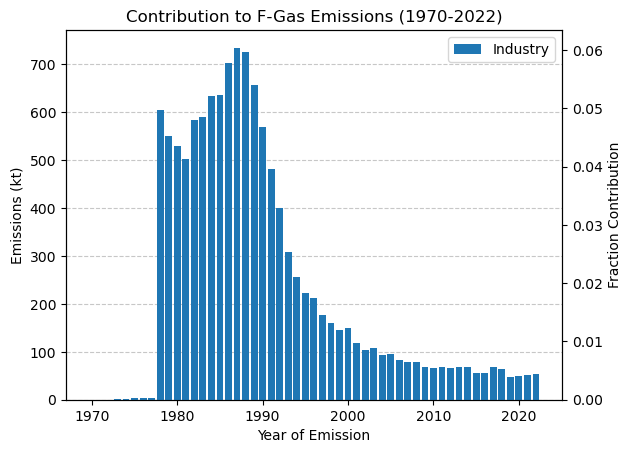

In [1439]:
# Bar chart of sector contributions to annual decayed emissions for the HC time series
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),f_agg_decay.iloc[0,0:-3].values, label  = 'Industry')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to F-Gas Emissions (1970-2022)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),f_agg_decay_fraction.iloc[0,0:-1].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

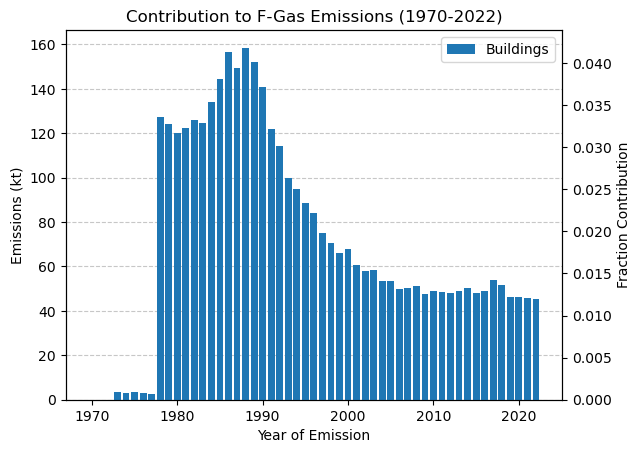

In [1440]:
# Bar chart of sector contributions to annual decayed emissions for the HC time series
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),f_agg_decay.iloc[7,0:-3].values, label  = 'Buildings')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to F-Gas Emissions (1970-2022)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),f_agg_decay_fraction.iloc[7,0:-1].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

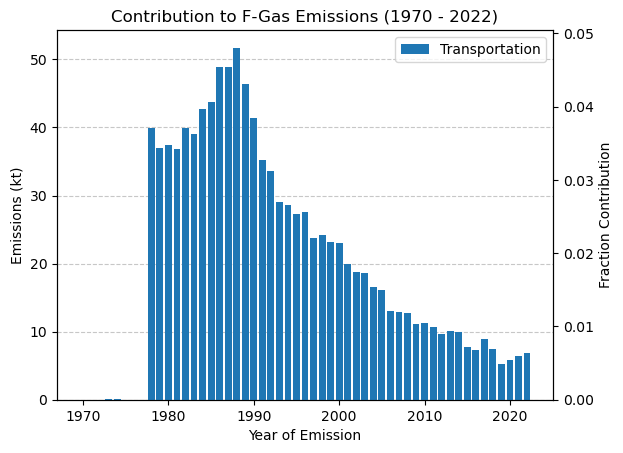

In [1441]:
# Bar chart of sector contributions to annual decayed emissions for the HC time series
fig,ax1 = plt.subplots()
ax1.grid(True, axis = 'y', linestyle ='--', alpha = 0.7)
bar1 = ax1.bar(np.arange(1970,2023,1),f_agg_decay.iloc[1,0:-3].values, label  = 'Transportation')
ax1.set_xlabel('Year of Emission')
ax1.set_ylabel('Emissions (kt)')
ax1.set_title('Contribution to F-Gas Emissions (1970 - 2022)')
ax2 = ax1.twinx()
bar2 = ax2.bar(np.arange(1970,2023,1),f_agg_decay_fraction.iloc[1,0:-1].values) #, label  = 'Emissions (kt)')
ax2.set_ylabel('Fraction Contribution')
ax1.legend()
tick_positions = [0,250, 500, 750, 1000, 1250]
# ax1.set_yticks(tick_positions)
# ax2.set_yticks(tick_positions)
plt.show()

In [1442]:
# Look at aggregate decyaed emissions
f_agg_decay2 = sum_and_rename(fluoro_decayed).rename(columns={'sectors':'sector'}).drop(columns = 'compounds')
years = [int(col.split('Y_')[1]) for col in f_agg_decay2.columns if col.startswith('Y')] + ['total', 'sector']
f_agg_decay2.columns = years
f_agg_decay2

,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,2015,2016,2017,2018,2019,2020,2021,2022,total,sector
0,0.0,0.0,0.0,1.869935,1.236102,4.172916,4.038603,4.131605,605.549569,549.45331,...,56.150055,56.075333,69.080723,63.536962,46.628925,49.296307,51.956913,54.593295,12157.988033,Industry
0,0.0,0.0,0.0,0.049908,0.036261,0.02963,0.026607,0.024546,39.957897,36.983472,...,7.819808,7.320581,8.966563,7.520281,5.221174,5.788427,6.358294,6.937043,1076.469268,Transportation
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Burning
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Power
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ffpd
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Waste
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Agriculture
0,0.0,0.0,0.0,3.602639,3.225318,3.364398,2.90401,2.711307,127.14506,123.976065,...,47.941044,48.99647,53.782003,51.517903,46.306619,46.038777,45.780352,45.534329,3792.034653,Buildings
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Other
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,LULUCF


In [1443]:
# Generate DataFrame of Raw f-gas emissions to save
hc_years_pre = fd6.iloc[:,:-4]
years = [int(col.split('Y_')[1]) for col in hc_years_pre.columns if col.startswith('Y_')]
hc_years_pre.columns = years
hc_years_pre = pd.concat([fd6.iloc[:,-3],hc_years_pre], axis=1)
hc_years_pre = sum_and_rename(hc_years_pre)#.reset_index(drop=True)
hc_years_pre 

,sectors,1970,1971,1972,1973,1974,1975,1976,1977,1978,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Industry,0,0,0,5.854338,5.661352,9.091101,9.038665,9.000246,676.850199,...,278.367423,281.968326,261.746627,264.147876,283.205108,274.610413,246.839303,248.464548,252.542184,259.382831
0,Transportation,0,0,0,0.061835,0.048253,0.042348,0.040843,0.040469,43.349766,...,87.610042,89.203627,86.45342,87.493767,91.118437,86.966878,82.039319,81.376564,80.736656,80.305359
0,Burning,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Power,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,ffpd,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Waste,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Agriculture,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,Buildings,0,0,0,4.372634,4.016002,4.251187,3.850885,3.732119,185.79705,...,607.902448,635.067447,643.689422,680.289036,713.773784,732.665665,736.668773,734.984519,732.892908,730.565629
0,Other,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,LULUCF,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Store and Save
Generate DataFrame of LLCF and SLCF for model runs (ie w/ and w/o ffpd)

In [1444]:
#Generate single DataFrame of pre decay LLCFs
cf_tot_pre = {}
cf_tot_pre['co2'] = co2c_years_pre.reset_index()
cf_tot_pre['ch4'] = ch4c_years_pre.reset_index()
cf_tot_pre['n2o'] = n2oc_years_pre.reset_index()
cf_tot_pre['hc'] = hc_years_pre.reset_index(drop=True)

df_cf_tot_pre = pd.concat(cf_tot_pre, axis=1)  # ['CO2'].loc[1752]


cf_tot_pre2 = {}
cf_tot_pre2['co2'] = co2c_years_pre_noffpd.reset_index()
cf_tot_pre2['ch4'] = ch4c_years_pre_noffpd.reset_index()
cf_tot_pre2['n2o'] = n2oc_years_pre_noffpd.reset_index()
cf_tot_pre2['hc'] = hc_years_pre.reset_index(drop=True)

df_cf_tot_pre2 = pd.concat(cf_tot_pre2, axis=1)  # ['CO2'].loc[1752]


In [1445]:
#generate dataframe of cumulative decayed LLCF

cf_tot = {}

add_cols = pd.DataFrame(0, index = f_agg_decay2.index, columns = [i for i in range(1750, 1970)])
# f_agg_decay3 = pd.concat([add_cols,f_agg_decay2], axis=1).set_index('sector').reindex(co2_hist_decayc2.reset_index()['sector'])
f_agg_decay3 = pd.concat([add_cols,fd_cumu], axis=1).set_index('sectors').reindex(co2_hist_decayc.reset_index()['sector'])


cf_tot['co2'] = co2_hist_decayc.reset_index()
cf_tot['ch4'] = ch4_hist_decaycl.reset_index()
cf_tot['n2o'] = n2o_hist_decaycl.reset_index()
cf_tot['hc'] = f_agg_decay3.iloc[:, list(range(0,273)) + [-1]].reset_index(drop=False).fillna(0)#.reindex(["Z", "C", "A"])

df_cf_tot = pd.concat(cf_tot, axis=1)  # ['CO2'].loc[1752]
df_cf_tot['co2']



,sector,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.493764e+08,2.572120e+08,2.646491e+08,2.719906e+08,2.795631e+08,2.874112e+08,2.950249e+08,3.020649e+08,3.101004e+08,3.179339e+08
1,ffpd,1737.192919,3363.134274,4898.986710,6360.497388,7761.270621,9111.646442,10521.028263,11888.318861,13219.999576,...,7.202186e+07,7.326943e+07,7.458225e+07,7.580359e+07,7.708573e+07,7.842250e+07,7.986490e+07,8.137016e+07,8.297067e+07,8.454892e+07
2,Waste,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,5.450119e+05,5.777861e+05,6.104490e+05,6.430511e+05,6.756276e+05,7.082084e+05,7.408128e+05,7.734556e+05,8.061474e+05,8.388944e+05
3,Agriculture,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.329934e+07,1.351205e+07,1.372474e+07,1.393609e+07,1.416105e+07,1.438115e+07,1.458675e+07,1.477648e+07,1.497522e+07,1.517191e+07
4,Industry,3285.289053,6359.288596,9262.273166,12023.863059,14670.022800,17220.328878,19916.070200,22529.544279,25073.426166,...,2.461809e+08,2.511883e+08,2.559275e+08,2.605123e+08,2.649597e+08,2.694137e+08,2.738871e+08,2.782734e+08,2.828441e+08,2.872136e+08
5,Transportation,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.742855e+08,1.785521e+08,1.829908e+08,1.875194e+08,1.921730e+08,1.969373e+08,2.016510e+08,2.051177e+08,2.091364e+08,2.132984e+08
6,Buildings,3816.343910,7385.213774,10753.523929,13955.790610,17022.260107,19975.744598,23095.760192,26118.596714,29059.018902,...,1.008350e+08,1.020408e+08,1.032749e+08,1.045351e+08,1.058436e+08,1.071694e+08,1.084673e+08,1.096977e+08,1.109708e+08,1.121878e+08


In [1446]:
df_cf_tot['co2'].sum()

sector    EnergyffpdWasteAgricultureIndustryTransportati...
1750                                            8838.825882
1751                                           17107.636643
1752                                           24914.783806
1753                                           32340.151057
                                ...                        
2018                                       954443448.399318
2019                                       974222808.066863
2020                                       992073866.890779
2021                                      1011803749.319266
2022                                      1031193494.255279
Length: 274, dtype: object

In [1447]:
df_cf_tot_sl = pd.concat(ceds_df_slcf_all, axis=1)

In [1448]:
df_cf_tot_sl['bc']

,sectors,1750,1751,1752,1753,1754,1755,1756,1757,1758,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,total
0,Energy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,240.161932,243.555638,280.156787,303.825041,324.175992,342.407408,363.240384,404.033374,403.067743,403.067743
1,ffpd,0.067133,0.067273,0.067413,0.067553,0.067693,0.067833,0.067973,0.068113,0.068253,...,513.932947,426.64504,421.460863,413.412887,425.227888,435.42758,439.63235,445.100777,434.743208,434.743208
2,Waste,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007,278.45007
3,Agriculture,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,280.526555,273.498577,262.058999,277.223557,264.929857,255.505276,238.149937,238.589395,237.834528,237.834528
4,Industry,8.764243,8.787549,8.810955,8.834262,8.857669,8.881077,8.922163,8.94566,8.969158,...,932.362728,906.34775,817.303365,772.125124,749.053528,721.600988,704.254529,701.652557,702.467605,702.467605
5,Transportation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1342.816277,1317.922529,1308.410337,1323.921889,1321.469381,1258.401739,1101.482018,1133.088513,1125.070703,1125.070703
6,Buildings,511.264724,512.522781,513.781557,515.036997,516.293156,517.548005,519.156042,520.408186,521.65902,...,2420.913983,2391.460445,2349.234117,2356.942414,2269.394165,2213.929842,2180.026925,2160.710616,2152.063083,2152.063083


### Save Emission Data (with ffpd and with ffpd seperated)

In [1449]:
if choice_ffpd == 0:
    newpath = r'C:data_out_final/emissions/present_day' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    newpath = r'C:data_out_final/emissions/all_years' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
    # generate files of  emissions for timeseries (- 2022) for LLCF
    
    # Content: Emissions (metric kilotons) for LLCF (1850-2019) extrapolated to 2022,
    # Other Method: Extrapolation (linear) used 2015-2019 emissions
    
    template = """\
    README: 
    Content: Emissions (metric kilotons) by sector for LLCF (1850-2022)
    
    {}"""
    
    for spec in ['co2','ch4','n2o', 'hc']:
        with open('data_out_final/emissions/present_day/'+ str(spec) +'_emissions_2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(df_cf_tot_pre[spec].to_csv(index = False)))
    
    # generate files of cumulative decayed emissions (1750-2022) for LLCF
    
    # Content: Cumulative Decayed Emissions (metric kilotons) by sector for LLCF (1850-2019) extrapolated to 2022,
    # Note: Emissions of CO2 for (1750-2019),
    # Other Method: Extrapolation (linear) used 2015-2019 emissions
    
    template = """\
    README: 
    Content: Cumulative Decayed Emissions (metric kilotons) by sector for LLCF (1850-2022)
    
    {}"""
    
    for spec in ['co2','ch4','n2o','hc']:
        with open('data_out_final/emissions/all_years/'+ str(spec) +'_decay_emission_cumulative_1750-2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(df_cf_tot[spec].to_csv(index = False)))
    
    # generate files of  emissions (1750-2022) for SLCF
    
    # Content: CEDS emissions (metric kilotons) by sector for SLCF (1750-2019) extrapolated to 2022,
    # Other Method: Extrapolation (linear) used 2015-2019 emissions
        
    template = """\
    README: 
    Content: CEDS emissions (metric kilotons) by sector for SLCF (1750-2022)
    
    {}"""
    
    for spec in ceds_df_slcf_all.keys():
        with open('data_out_final/emissions/all_years/'+ str(spec) +'_emissions_1750-2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(ceds_df_slcf_all[spec].iloc[:,:-1].to_csv(index = False)))

    #generate files of cumulative decayed emissions for present day (2022) for LLCF

    template = """\
    README: 
    Content: Cumulative Decayed Emissions (metric kilotons) for LLCF (1850-2019) extrapolated to 2022,
    Note: Emissions of CO2 for (1750-2019),
    Other Method: Extrapolation (linear) used 2015-2019 emissions
    
    {}"""
    
    for spec in ['co2','ch4','n2o','hc']:
        with open('data_out_final/emissions/present_day/'+ str(spec) +'_decay_emission_cumulative_2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(df_cf_tot[spec].iloc[:,[0,-2]].to_csv(index = False)))
    
    #generate files of present day emissions (2022) for SLCF
    template = """\
    README: 
    Content: CEDS emissions (metric kilotons) for SLCF (1750-2019) extrapolated to 2022,
    Other Method: Extrapolation (linear) used 2015-2019 emissions
    
    {}"""
    
    for spec in ceds_df_slcf_all.keys():
        with open('data_out_final/emissions/present_day/'+ str(spec) +'_emissions_2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(ceds_df_slcf_all[spec].iloc[:,[0,-2]].to_csv(index = False)))
else:
    newpath = r'C:data_out_final/ffpd_separated/emissions/present_day' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

    newpath = r'C:data_out_final/ffpd_separated/emissions/all_years' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
    #generate files of  emissions for timeseries (- 2022) for LLCF

    # Content: Emissions (metric kilotons) for LLCF (1750-2019) extrapolated to 2022,
    # Note: ffpd separated into other sectors based on IEA final fuel consumption %
    # Other Method: Extrapolation (linear) used 2015-2019 emissions
    template = """\
    README: 
    Content: Emissions (metric kilotons) by sector for LLCF (1750-2022),
    Note: ffpd separated into other sectors based on IEA final fuel consumption %
    
    {}"""
    
    for spec in ['co2','ch4','n2o', 'hc']:
        with open('data_out_final/ffpd_sep/emissions/present_day/'+ str(spec) +'_emissions_2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(df_cf_tot_pre2[spec].to_csv(index = False)))
    
    #generate files of cumulative decayed emissions (1750-2022) for LLCF
    
    # Content: Cumulative Decayed Emissions (metric kilotons) for LLCF (1750-2019) extrapolated to 2022,
    # Note: ffpd separated into other sectors based on IEA final fuel consumption %
    # Other Method: Extrapolation (linear) used 2015-2019 emissions
    
    template = """\
    README: 
    Content: Cumulative Decayed Emissions (metric kilotons) by sector for LLCF (1750-2022) 
    Note: ffpd separated into other sectors based on IEA final fuel consumption %
    
    {}"""
    
    for spec in ['co2','ch4','n2o','hc']:
        with open('data_out_final/ffpd_sep/emissions/all_years/'+ str(spec) +'_decay_emission_cumulative_1750-2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(df_cf_tot[spec].to_csv(index = False)))
    
    #generate files of  emissions (1750-2022) for SLCF
    
    # Content: CEDS emissions (metric kilotons) for SLCF (1750-2019) extrapolated to 2022,
    # Note: ffpd separated into other sectors based on IEA final fuel consumption %
    # Other Method: Extrapolation (linear) used 2015-2019 emissions
    
    template = """\
    README: 
    Content: CEDS emissions (metric kilotons) by sector for SLCF (1750-2022)
    Note: ffpd separated into other sectors based on IEA final fuel consumption %
    
    {}"""
    
    for spec in ceds_df_slcf_all.keys():
        with open('data_out_final/ffpd_sep/emissions/all_years/'+ str(spec) +'_emissions_1750-2022.csv', 'w', newline = '') as fp:
            fp.write(template.format(ceds_df_slcf_all[spec].iloc[:,:-1].to_csv(index = False)))

# Calculate ERF of each compound
Data and Process from [IPCC AR6 CH6 Fig 12](https://github.com/IPCC-WG1/Chapter-6_Fig12_22_24)

In [1450]:
# Load Historical emission-based Effective Radiative Forcing data generated by IPCC AR6 Ch6 team
erf = pd.read_csv(r'C:data\hist_ERF_est.csv')

#Load final emission-based ERF table ilustrated in IPCC AR6 CH6 fig 6.12
erf_final = pd.read_csv(r'C:data\fig_em_based_ERF_GSAT_period_1750-2019_values_ERF.csv',skiprows=42)

In [1451]:
erf_final = erf_final.drop(10).set_index('emission_experiment')
erf_final

,CO2,N2O,HC,HFCs,CH4_lifetime,O3,Strat_H2O,Aerosol,Cloud
emission_experiment,,,,,,,,,
CO2,2.057554,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
ch4,0.017549,0.00,0.00,0.000000,0.844457,0.266736,0.05,-0.002653,0.018421
n2o,0.000000,0.21,0.00,0.000000,-0.035967,0.026124,0.00,-0.002090,0.042503
HC,0.000053,0.00,0.41,0.039772,-0.050927,-0.162033,0.00,-0.008080,-0.017419
NOx,0.000000,0.00,0.00,0.000000,-0.380025,0.137102,0.00,-0.009166,-0.014458
VOC,0.069491,0.00,0.00,0.000000,0.162462,0.202071,0.00,-0.002573,0.008884
SO2,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,-0.234228,-0.703784
OC,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,-0.072143,-0.136919
BC,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.144702,-0.037227


In [1452]:
# Load Historical emission-based Effective Radiative Forcing data decompossed into components generated by IPCC AR6 Ch6 team
erf_decomp = pd.read_csv(r'C:data\hist_ERF_est_decomp.csv')

In [1453]:
erf_decomp

,Unnamed: 0,CO2,CH4,N2O,HC,NOx,VOC,SO2,OC,BC,NH3
0,CO2,1.0,0.014691,0.000000,0.000251,-0.000000,0.157813,-0.000000,-0.000000,0.000000,-0.0
1,CH4_lifetime,0.0,0.706949,-0.149509,-0.240941,1.425737,0.368952,-0.000000,-0.000000,0.000000,-0.0
2,Strat_H2O,0.0,0.041858,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.0
3,Aerosol,0.0,-0.002221,-0.008690,-0.038229,0.034387,-0.005843,0.249706,0.345081,1.346382,1.0
4,Cloud,0.0,0.015421,0.176677,-0.082413,0.054242,0.020175,0.750294,0.654919,-0.346382,-0.0
5,O3,0.0,0.223302,0.108592,-0.766596,-0.514367,0.458903,-0.000000,-0.000000,0.000000,-0.0
6,HC,0.0,0.000000,0.000000,1.939759,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.0
7,N2O,0.0,0.000000,0.872930,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.0
8,HFCs,0.0,0.000000,0.000000,0.188168,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.0


In [1454]:
erf.index = erf.iloc[:,0]
erf.index.name = None
del erf['Unnamed: 0']

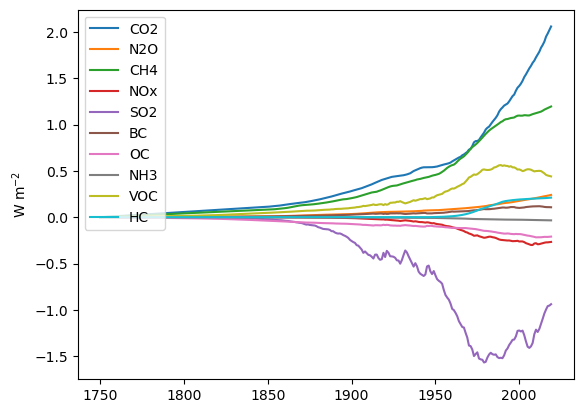

In [1455]:
erf.plot()

plt.ylabel('W m$^{-2}$')

plt.legend(loc='upper left')

In [1456]:
erf.columns = [x.lower() for x in erf.columns]
# erf

In [1457]:
# ERF in 1970, as of 1/25/24 comparing emissions from 1970-2021 (max) so ERF comparison should be erf_1970 and erf_2019 (latest erf available)
# erf_1970 = erf[erf.index == 1970].values
# erf_latest = erf.values[-1]
# erf_use = abs(erf_latest - erf_1970) #ERF change since 1970
# erf_use = pd.DataFrame(data = erf_use)
# erf_use.columns = erf.columns
# erf_use.so2 = erf_use.so2 * -1 #would some of the prev. neg. erfs be pos. if using relative values ?
erf_use = erf

### Adjust ERF for aerosol-cloud non-linearities
IPCC adjusts for non-linearities in aerosol-cloud interactions component of final ERF (ERF aci) by scaling down 12.5% of cloud component after calculating ERF and final change in GSAT -- also adjust cloud component of final GSAT by 25%. We attempt to similarly adjust the ERF, but prior to calculating change in GSAT for each species as we do not propogate the components of each species ERF through the change in GSAT calculation. Therefore, the 12.5% reduction of the cloud-related ERF is apportioned to each species time series (1750-2022)

In [1458]:
df_erf_sep = erf_final.copy()

In [1459]:
scale_down_by = 0.125
aci_tot = erf_final.sum()['Cloud']
aci_tot
df_erf_sep['Cloud'] = df_erf_sep['Cloud'] * (1 - scale_down_by)  # scale_by
df_erf_sep#.sum()

,CO2,N2O,HC,HFCs,CH4_lifetime,O3,Strat_H2O,Aerosol,Cloud
emission_experiment,,,,,,,,,
CO2,2.057554,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000
ch4,0.017549,0.00,0.00,0.000000,0.844457,0.266736,0.05,-0.002653,0.016118
n2o,0.000000,0.21,0.00,0.000000,-0.035967,0.026124,0.00,-0.002090,0.037190
HC,0.000053,0.00,0.41,0.039772,-0.050927,-0.162033,0.00,-0.008080,-0.015242
NOx,0.000000,0.00,0.00,0.000000,-0.380025,0.137102,0.00,-0.009166,-0.012651
VOC,0.069491,0.00,0.00,0.000000,0.162462,0.202071,0.00,-0.002573,0.007773
SO2,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,-0.234228,-0.615811
OC,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,-0.072143,-0.119804
BC,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.144702,-0.032574


In [1460]:
#apportion 12.5% scale according to ERF final
red_cloud_frac = df_erf_sep['Cloud'] / df_erf_sep.sum(axis=1) #reduced cloud fraction
ori_cloud_frac = erf_final['Cloud'] / erf_final.sum(axis=1) #original cloud fraction
ori_cloud_frac - red_cloud_frac

emission_experiment
CO2    0.000000
ch4    0.001902
n2o    0.018593
HC    -0.011037
NOx    0.006456
VOC    0.002477
SO2    0.025843
OC     0.030769
BC    -0.055876
NH3    0.000000
dtype: float64

In [1461]:
erf

,co2,n2o,ch4,nox,so2,bc,oc,nh3,voc,hc
1750,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000
1751,0.001126,0.000078,0.000824,-0.000001,-0.000055,0.000024,-0.000125,-0.000005,0.000174,0.000000
1752,0.002252,0.000155,0.001647,-0.000002,-0.000095,0.000049,-0.000249,-0.000010,0.000348,0.000000
1753,0.003378,0.000233,0.002471,-0.000003,-0.000130,0.000073,-0.000373,-0.000016,0.000521,0.000000
1754,0.004505,0.000310,0.003294,-0.000004,-0.000167,0.000097,-0.000497,-0.000021,0.000694,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,1.894420,0.225867,1.160556,-0.274934,-1.038115,0.111334,-0.211918,-0.032429,0.473219,0.205775
2016,1.948068,0.229055,1.169129,-0.271339,-0.995462,0.109283,-0.212355,-0.032766,0.456502,0.206995
2017,1.981696,0.232610,1.176556,-0.271009,-0.958711,0.109212,-0.212410,-0.033141,0.449865,0.208398
2018,2.019078,0.237074,1.185527,-0.269076,-0.953242,0.108447,-0.210940,-0.033449,0.444873,0.210010


In [1462]:
erf.sum(axis=1)

1750    0.000000
1751    0.002040
1752    0.004094
1753    0.006154
1754    0.008210
          ...   
2015    2.513774
2016    2.607109
2017    2.683066
2018    2.738303
2019    2.804419
Length: 270, dtype: float64

In [1463]:
# Extrapolate ERFs to 2022
new_rows = pd.DataFrame({col: [np.nan] *3 for col in erf.columns}, index = range(2020, 2023))
erf_use = pd.concat([erf,new_rows], ignore_index=False)
erf_use.iloc[-5:,:] = erf_use.iloc[-5:,:].interpolate(method="slinear", fill_value="extrapolate",limit_direction="forward")
erf_use.tail()

,co2,n2o,ch4,nox,so2,bc,oc,nh3,voc,hc
2018,2.019078,0.237074,1.185527,-0.269076,-0.953242,0.108447,-0.210940,-0.033449,0.444873,0.210010
2019,2.057554,0.240569,1.194509,-0.266546,-0.938012,0.107475,-0.209062,-0.033769,0.440334,0.211366
2020,2.096031,0.244064,1.203491,-0.264017,-0.922782,0.106503,-0.207184,-0.034089,0.435796,0.212723
2021,2.134507,0.247558,1.212473,-0.261487,-0.907551,0.105531,-0.205306,-0.034409,0.431257,0.214080
2022,2.172984,0.251053,1.221455,-0.258958,-0.892321,0.104558,-0.203428,-0.034729,0.426718,0.215437


### Calculate the erf contribution from each sector from the total compound erf
to establish the sectoral ERF time series over the whole historical period, ERF scaled according the historic sectoral emissions, i.e. following IPCC assumption of a linear relation between emissions and ERF historically. 

In [1464]:

def frac_con1(df_agent,spec_1,erf_tot):
    frac_con = df_agent[spec_1].total/df_agent[spec_1].total.sum() * erf_tot[spec_1].values[-1]
    return frac_con

def frac_con2(df_agent, spec_sl, spec_erf, erf_tot):
    frac_con = df_agent[spec_sl]/df_agent[spec_sl].sum() * erf_tot[spec_erf].values[-1]
    return frac_con
    
#calc the erf contribution from each sector to the compound erf for each year
def frac_con3(df_agent,spec_1,erf_tot):
    frac_con = (df_agent[spec_1].iloc[:,1:-1]/df_agent[spec_1].iloc[:,1:-1].sum())* pd.DataFrame(erf_tot[spec_1]).T.values
    return frac_con

def frac_con4(df_agent,spec_1,spec_2,erf_tot):
    frac_con = (df_agent[spec_1].iloc[:,1:-1]/df_agent[spec_1].iloc[:,1:-1].sum())* pd.DataFrame(erf_tot[spec_2]).T.values
    return frac_con


In [1465]:
#Generate present day (2022) ERF and time series of ERF for each sector and species
cf_tot = {}

add_cols = pd.DataFrame(0, index = f_agg_decay2.index, columns = [i for i in range(1750, 1970)])
f_agg_decay3 = pd.concat([add_cols,fd_cumu], axis=1).set_index('sectors').reindex(co2_hist_decayc.reset_index()['sector'])
f_agg_decay3['total'] = f_agg_decay3.iloc[:,-2]
f_agg_decay3 = f_agg_decay3.fillna(0)

# co2_hist_decayc2 = co2_hist_decayc.T
co2_hist_decayc['total'] = co2_hist_decayc.iloc[:,-1]
ch4_hist_decaycl['total'] = ch4_hist_decaycl.iloc[:,-1]
n2o_hist_decaycl['total'] = n2o_hist_decaycl.iloc[:,-1]
# hc_hist_decay['total'] = n2o_hist_decaycyz.iloc[:,-1

cf_tot['co2'] = co2_hist_decayc.reset_index()
cf_tot['ch4'] = ch4_hist_decaycl.reset_index()
cf_tot['n2o'] = n2o_hist_decaycl.reset_index()
cf_tot['hc'] = f_agg_decay3.iloc[:, list(range(0,273)) + [-1]].reset_index(drop=False)#.reindex(["Z", "C", "A"])

df_cf_tot = pd.concat(cf_tot, axis=1)  # ['CO2'].loc[1752]
df_cf_tot.columns

# comps = ['co2','ch4','n2o','f','bc','co','voc','so2','nox','nh3','oc']
fracs = {} # calculating erf for final year (2022)
fracs2 = {} # calculating erf for all years

#LLCF Present year (2022) ERF fractions by sector 
for spec in ['co2', 'ch4', 'n2o','hc']:
    frac_con = frac_con1(df_cf_tot,spec,erf_use)
    # print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs[spec] = frac_con

#LLCF All Years (1750 - 2022) ERF fractions by sector 
for spec in ['co2', 'ch4', 'n2o','hc']:
    frac_con = frac_con3(df_cf_tot,spec,erf_use)
    print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs2[spec] = frac_con

#SLCF Present year (2022) ERF fractions by sector 
for spec in ['bc','voc','so2','nox','nh3','oc']:
    frac_con = frac_con2(ceds_df_slcf_tot,spec, spec,erf_use)
    #frac_con = frac_con2(df_slcf_tot,spec, spec,erf_use)
    # print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs[spec] = frac_con

spec = 'co'
frac_con = frac_con2(ceds_df_slcf_tot,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
#frac_con = frac_con2(df_slcf_tot,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
# print(spec)
fracs[spec] = frac_con

#decrease erf of co and voc by half because they share ERF in IPCC, not sure if equivalent contributions tho
fracs['co'] = fracs['co']/2
fracs['voc'] = fracs['voc']/2


#SLCF All Years (1750 - 2022) ERF fractions by sector 
df_cf_tot_sl = pd.concat(ceds_df_slcf_all, axis=1)

for spec in ['bc','voc','so2','nox','nh3','oc']:
    frac_con = frac_con3(df_cf_tot_sl,spec,erf_use)
    #frac_con = frac_con2(df_slcf_tot,spec, spec,erf_use)
    print(spec)
    
#     forcing_spec.plot(label=spec)
    fracs2[spec] = frac_con

spec = 'co'
frac_con = frac_con4(df_cf_tot_sl,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
#frac_con = frac_con2(df_slcf_tot,spec,'voc',erf_use) # VOC: scale with CO emissions because these are mostly the same as in IPCC
# print(spec)
fracs2[spec] = frac_con

#decrease erf of co and voc by half because they share ERF in IPCC, not sure if equivalent contributions tho
fracs2['co'] = fracs2['co']/2
fracs2['voc'] = fracs2['voc']/2

co2
ch4
n2o
hc
bc
voc
so2
nox
nh3
oc


In [1466]:
fracs2['co2']#.sum()

,1750,1751,1752,1753,1754,1755,1756,1757,1758,1759,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.532330,0.545459,0.559700,0.579116,0.592864,0.608004,0.623091,0.638196,0.654190,0.669967
1,0.0,0.000221,0.000443,0.000664,0.000886,0.001108,0.001328,0.001548,0.001768,0.001989,...,0.153741,0.155380,0.157732,0.161399,0.163474,0.165899,0.168674,0.171917,0.175035,0.178166
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001163,0.001225,0.001291,0.001369,0.001433,0.001498,0.001565,0.001634,0.001701,0.001768
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.028389,0.028654,0.029026,0.029672,0.030031,0.030423,0.030807,0.031219,0.031592,0.031971
4,0.0,0.000419,0.000837,0.001256,0.001675,0.002094,0.002514,0.002934,0.003354,0.003774,...,0.525508,0.532685,0.541255,0.554676,0.561895,0.569931,0.578448,0.587930,0.596690,0.605231
5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.372037,0.378648,0.387003,0.399262,0.407538,0.416611,0.425886,0.433368,0.441195,0.449473
6,0.0,0.000486,0.000972,0.001458,0.001943,0.002429,0.002915,0.003401,0.003887,0.004373,...,0.215247,0.216394,0.218413,0.222574,0.224461,0.226712,0.229082,0.231767,0.234105,0.236408


In [1467]:
# df_cf_tot['co2']

In [1468]:
# Generate table (DataFrame) of present year (2022) erfs
df_spec_sector_erf = pd.concat(fracs, axis=1)  # ['CO2'].loc[1752]
df_spec_sector_erf.index =co2_hist_decayc.index # co2_agg_decay.sectors
df_spec_sector_erf = df_spec_sector_erf.T
# df_spec_sector_erf.rename('sector')
df_spec_sector_erf.index = [x.upper() for x in df_spec_sector_erf.index]
df_spec_sector_erf

sector,Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings
CO2,0.669967,0.178166,0.001768,0.031971,0.605231,0.449473,0.236408
CH4,0.00371,0.457941,0.249364,0.46495,0.004302,0.004967,0.036219
N2O,0.005071,0.000541,0.01157,0.163036,0.053933,0.010825,0.006077
HC,0.0,0.0,0.0,0.0,0.113181,0.016922,0.085333
BC,0.007901,0.008522,0.005459,0.004662,0.013771,0.022055,0.042188
VOC,0.00304,0.05185,0.004448,0.019936,0.070752,0.028284,0.035049
SO2,-0.389104,-0.081971,-0.002857,-0.008703,-0.291336,-0.078928,-0.039421
NOX,-0.050045,-0.008578,-0.005626,-0.020006,-0.038139,-0.12656,-0.010003
NH3,-0.000138,-0.000581,-0.004897,-0.026829,-0.000539,-0.000257,-0.001486
OC,-0.020074,-0.003771,-0.027636,-0.00333,-0.025952,-0.009697,-0.112968


In [1469]:
# Re-order forcer names
index_order = df_spec_sector_erf.index #[::-1].index
index_order

rename_dic_cols = {
    'co2': 'CO$_2$',
    'CO2': 'CO$_2$',
    'CH4': 'CH$_4$',
    'ch4': 'CH$_4$',
    'N2O': 'N$_2$O',
    'n2o': 'N$_2$O',
    'HC': 'CFC + HCFC + HFC',
    'HFCs': 'HFC',
    'NOx': 'NO$_x$',
    'VOC': 'NMVOC + CO',
    'SO2': 'SO$_2$',
    'OC': 'Organic carbon',
    'BC': 'Black carbon',
    'NH3': 'Ammonia'
}

In [1470]:
index_order

Index(['CO2', 'CH4', 'N2O', 'HC', 'BC', 'VOC', 'SO2', 'NOX', 'NH3', 'OC',
       'CO'],
      dtype='object')

In [1471]:
# rn_dic_cat_o = {}
# for key in rename_dic_cat.keys():
#     rn_dic_cat_o[rename_dic_cat[key]]=key
rn_dic_cols_o = {}
for key in rename_dic_cols.keys():
    rn_dic_cols_o[rename_dic_cols[key]]=key

### Generate ERF Figure by Gas-Sector

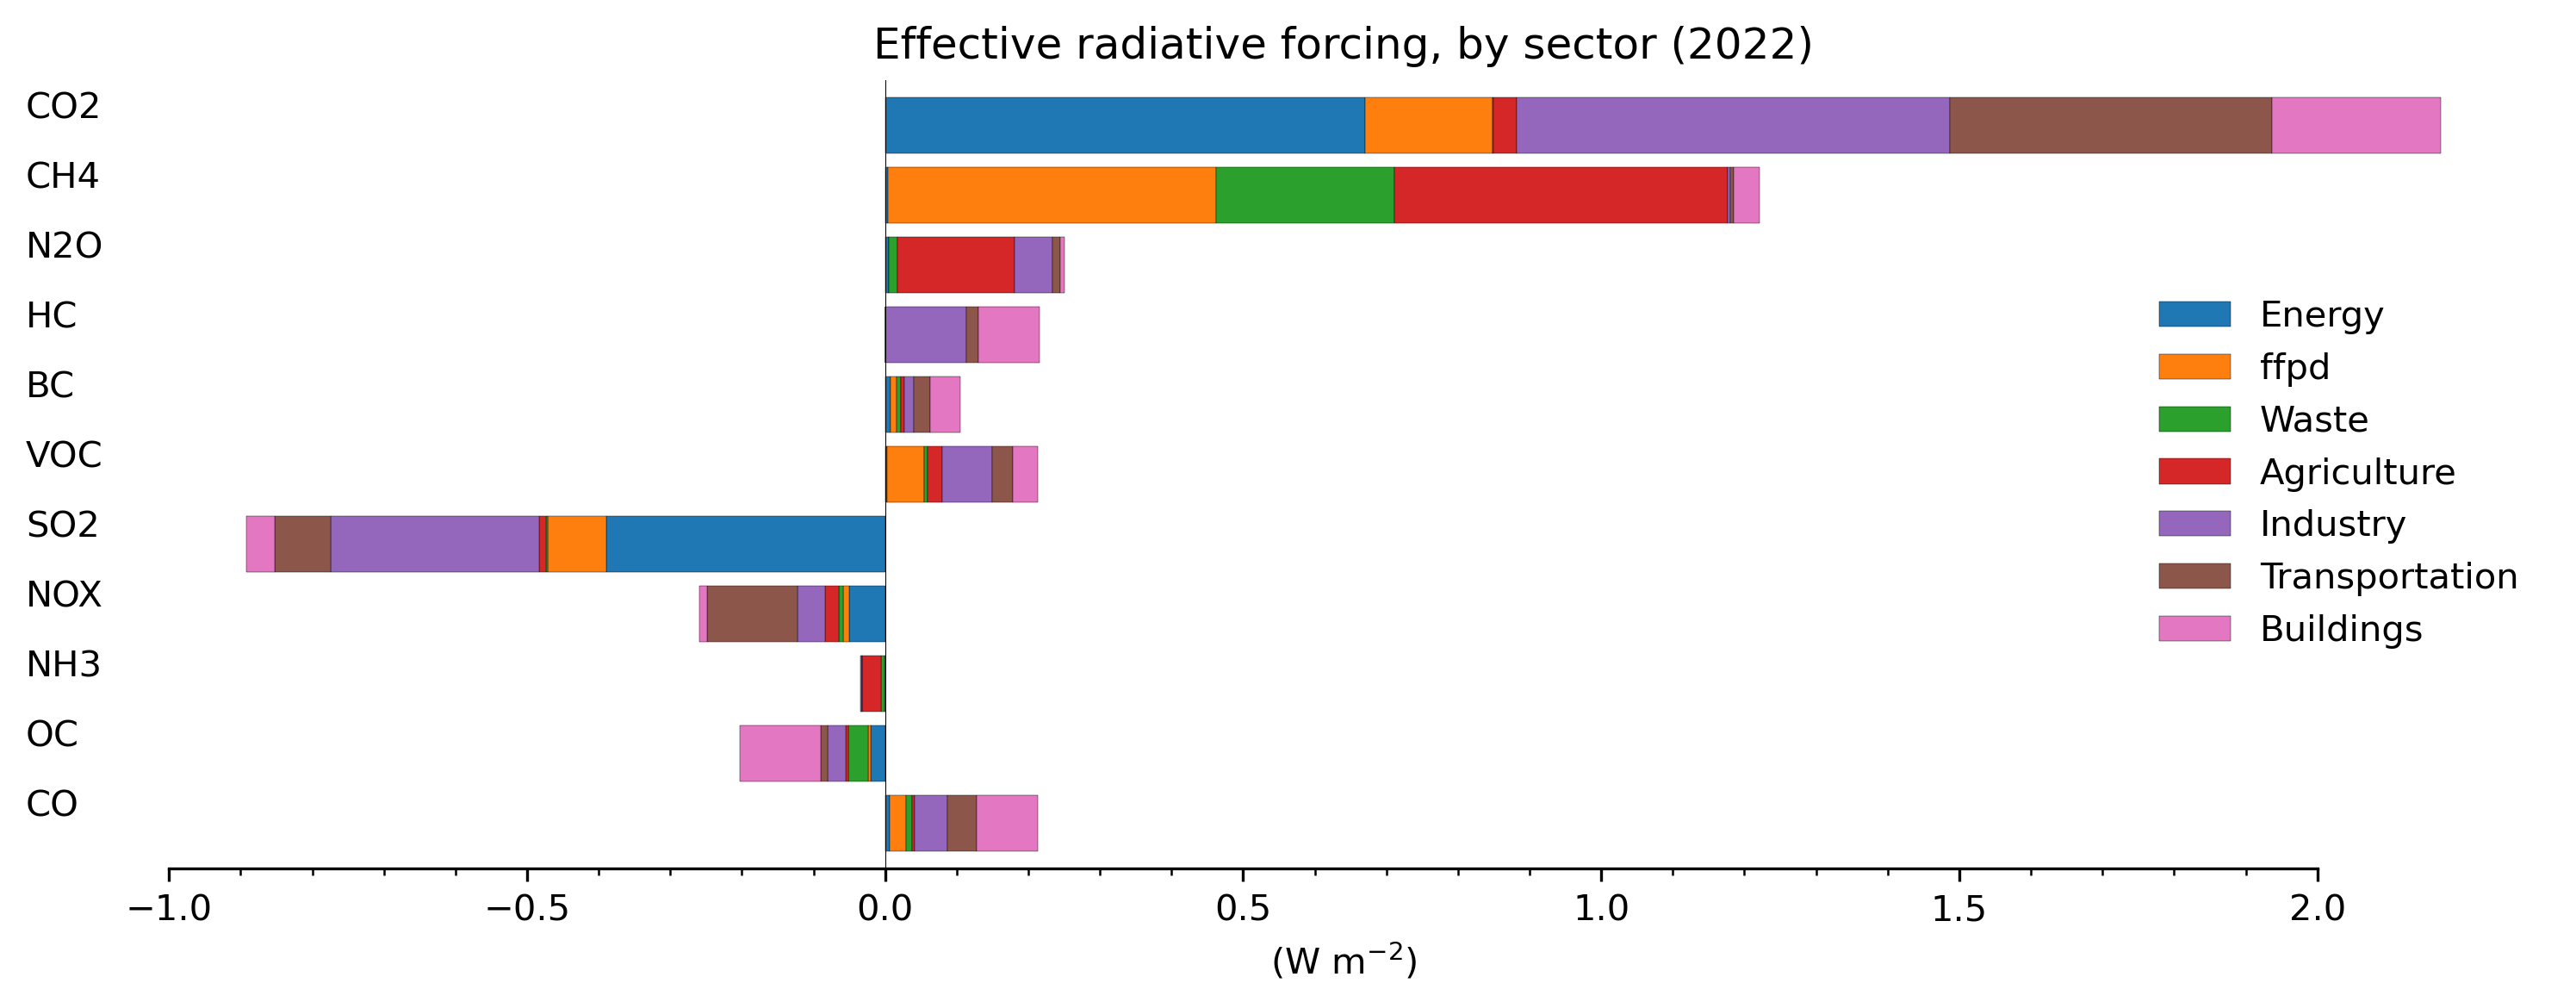

In [1472]:
# Generate Figure of erf by Gas-Sector
import seaborn as sns
ybar = np.arange(len(df_spec_sector_erf) + 1)  # , -1)
sns.set_style()

fig, axs = plt.subplots(1, 1, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}

ax = axs
ax.axvline(x=0., color='k', linewidth=0.25)

df_spec_sector_erf.plot.barh(stacked=True, ax=ax, **kws)#color=col_ls, ax=ax, **kws)
# tab_plt_erf.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = table['Total'][::-1]
# tot = tab_plt_erf.reindex(index_order).sum(axis=1)  # tab_plt

tot = df_spec_sector_erf.sum(axis=1)  # tab_plt
# xerr = df_err['95-50_period'].reindex(index_order)
y = np.arange(len(tot))
# ax.errorbar(tot, y, xerr=xerr, marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

for lab, y in zip(index_order.T, ybar):
    # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
    ax.text(-1.2, y - 0.1, lab, ha='left')  # , va='left')

# for lab, y in zip(index_order2, ybar):
#     # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
#     ax.text(-.75, y - 0.1, lab, ha='left')  # , va='left')
    
ax.set_title('Effective radiative forcing, by sector (2022)')
ax.set_xlabel(r'(W m$^{-2}$)')
# ax.set_xlim(-1.5, 2.6)
# plt.xlim(-1.6, 2.0)
# sns.despine(fig, left=True, trim=True)
ax.legend(loc='lower right', frameon=False)
ax.set_yticks([])

ax.get_legend().remove()

ax.set_xticks(np.arange(-1, 2.1, .5))
ax.set_xticks(np.arange(-1, 2, .1), minor=True)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-1., 2.)
ax.legend(loc='right', frameon=False)

ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()

# fig.savefig('ERF_Compound_Sector_1750_2022_CEDS.png')
# fig.savefig('ERF_Compound_Sector_1750_2022_CEDS_ffpd_separated.png')

<Axes: xlabel='sector'>

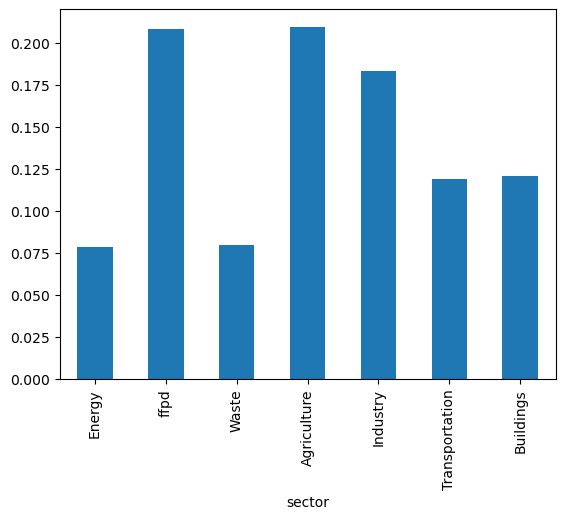

In [1473]:
# Bar chart of sectoral fraction contributions to ERF (2022)
(df_spec_sector_erf.sum(axis=0)/df_spec_sector_erf.sum(axis=0).sum()).plot(kind = 'bar')

### Generate ERF Figure by Sector-Gas

In [1474]:
# Generate table (DataFrame) of present year (2022) erfs

df_spec_sector_erf.T
erf2 = df_spec_sector_erf.T.copy()
erf2['sum'] = erf2.sum(axis=1)
erf2.loc['Total'] = erf2.sum(axis=0)
erf2

,CO2,CH4,N2O,HC,BC,VOC,SO2,NOX,NH3,OC,CO,sum
sector,,,,,,,,,,,,
Energy,0.669967,0.00371,0.005071,0.0,0.007901,0.00304,-0.389104,-0.050045,-0.000138,-0.020074,0.006184,0.236512
ffpd,0.178166,0.457941,0.000541,0.0,0.008522,0.05185,-0.081971,-0.008578,-0.000581,-0.003771,0.023379,0.625499
Waste,0.001768,0.249364,0.01157,0.0,0.005459,0.004448,-0.002857,-0.005626,-0.004897,-0.027636,0.008568,0.24016
Agriculture,0.031971,0.46495,0.163036,0.0,0.004662,0.019936,-0.008703,-0.020006,-0.026829,-0.00333,0.003474,0.629161
Industry,0.605231,0.004302,0.053933,0.113181,0.013771,0.070752,-0.291336,-0.038139,-0.000539,-0.025952,0.045191,0.550394
Transportation,0.449473,0.004967,0.010825,0.016922,0.022055,0.028284,-0.078928,-0.12656,-0.000257,-0.009697,0.040657,0.357741
Buildings,0.236408,0.036219,0.006077,0.085333,0.042188,0.035049,-0.039421,-0.010003,-0.001486,-0.112968,0.085907,0.363301
Total,2.172984,1.221455,0.251053,0.215437,0.104558,0.213359,-0.892321,-0.258958,-0.034729,-0.203428,0.213359,3.002769


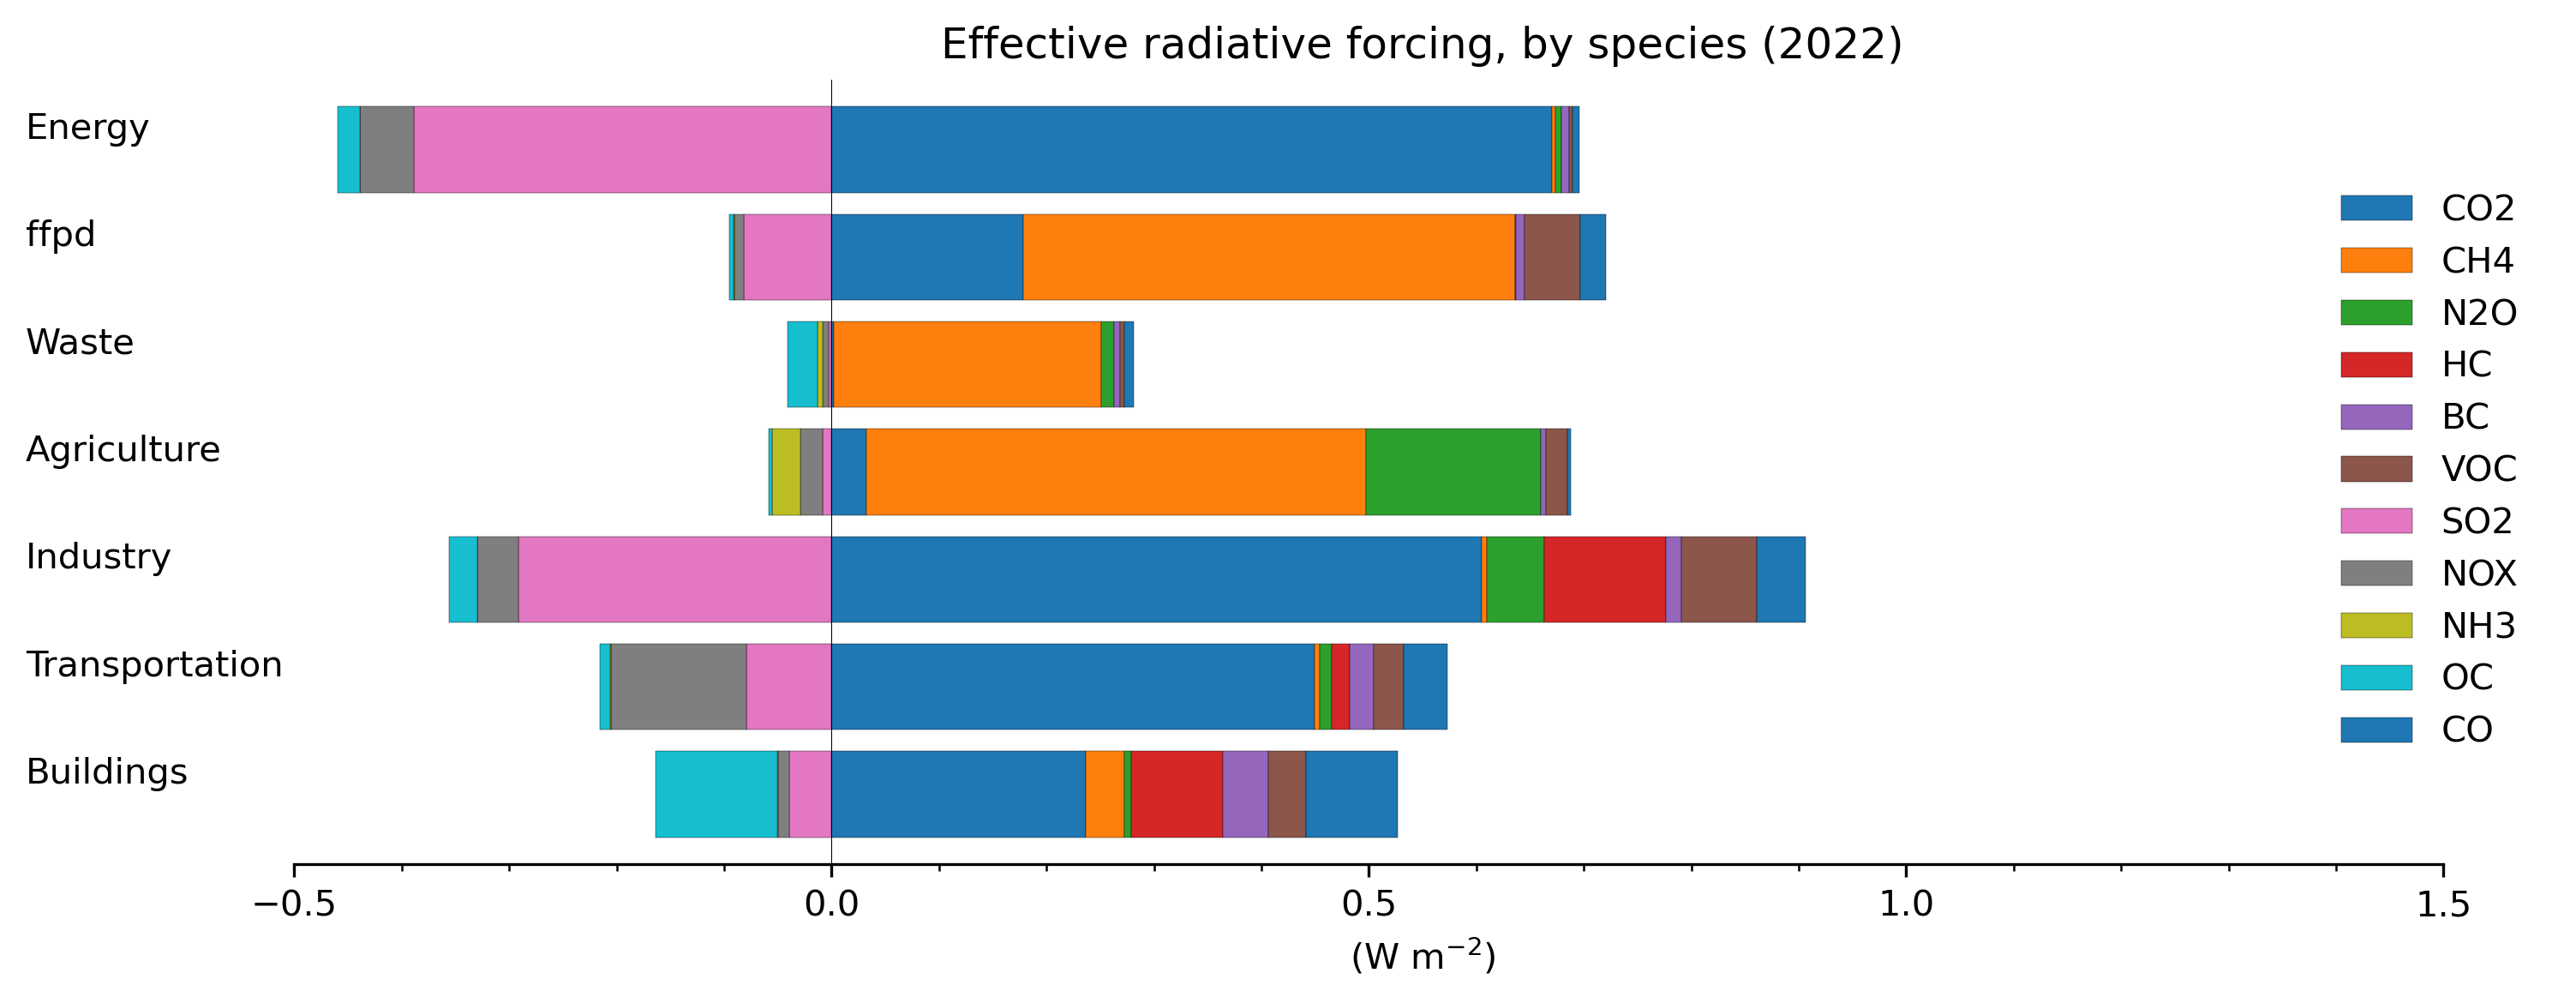

In [1475]:
# Generate Figure of ers by Sector-Gas

index_order2 = df_spec_sector_erf.T.index

sns.set_style()
fig, axs = plt.subplots(1, 1, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}

ax = axs
ax.axvline(x=0., color='k', linewidth=0.25)

df_spec_sector_erf.T.plot.barh(stacked=True, ax=ax, **kws)#color=col_ls, ax=ax, **kws)

tot = df_spec_sector_erf.T.sum(axis=1)  # tab_plt
# xerr = df_err['95-50_period'].reindex(index_order)
y = np.arange(len(tot))
# ax.errorbar(tot, y, xerr=xerr, marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

for lab, y in zip(index_order2, ybar):
    # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
    ax.text(-.75, y - 0.1, lab, ha='left')  # , va='left')
ax.set_title('Effective radiative forcing, by species (2022)')
ax.set_xlabel(r'(W m$^{-2}$)')
# ax.set_xlim(-1.5, 2.6)
# plt.xlim(-1.6, 2.0)
# sns.despine(fig, left=True, trim=True)
ax.legend(loc='lower right', frameon=False)
ax.set_yticks([])

ax.get_legend().remove()

ax.set_xticks(np.arange(-.5, 1.6, .5))
ax.set_xticks(np.arange(-.5, 1.5, .1), minor=True)
ax.set_xlim([-.5,1.6])

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-.5, 1.5)
ax.legend(loc='right', frameon=False)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()
# fig.savefig('ERF_Sector_Gas_CEDS.png')
# fig.savefig('ERF_Sector_Gas_CEDS_ffpd_separated.png')

In [1476]:
 df_spec_sector_erf.T.sum(axis=1) 

sector
Energy            0.236512
ffpd              0.625499
Waste              0.24016
Agriculture       0.629161
Industry          0.550394
Transportation    0.357741
Buildings         0.363301
dtype: object

# Calculate sectoral contribution to del_GSAT
[IPCC AR6 CH6 Fig 12](https://github.com/IPCC-WG1/Chapter-6_Fig12_22_24) \
OpenSCM model dependencies are deprecated so fails, but still require the structure from IPCC to run temperture response (del_T) calculations

In [1477]:
import inspect

import numpy as np
from openscm_units import unit_registry
from scmdata import ScmRun

import openscm_twolayermodel
from openscm_twolayermodel import ImpulseResponseModel, TwoLayerModel
from openscm_twolayermodel.base import Model

from IPython.display import clear_output

In [1478]:
# NBVAL_IGNORE_OUTPUT
openscm_twolayermodel.__version__

'0.2.3'

In [1479]:
inspect.getmro(ImpulseResponseModel)

(openscm_twolayermodel.impulse_response_model.ImpulseResponseModel,
 openscm_twolayermodel.base.TwoLayerVariant,
 openscm_twolayermodel.base.Model,
 abc.ABC,
 object)

In [1480]:
inspect.getmro(TwoLayerModel)

(openscm_twolayermodel.two_layer_model.TwoLayerModel,
 openscm_twolayermodel.base.TwoLayerVariant,
 openscm_twolayermodel.base.Model,
 abc.ABC,
 object)

In [1481]:
run_length = 200

driver = ScmRun(
    data=np.arange(run_length) * 4 / 70,
    index=1850 + np.arange(run_length),
    columns={
        "unit": "W/m^2",
        "model": "idealised",
        "scenario": "1pctCO2",
        "region": "World",
        "variable": "Effective Radiative Forcing",
    },
)
driver

<ScmRun (timeseries: 1, timepoints: 200)>
Time:
	Start: 1850-01-01T00:00:00
	End: 2049-01-01T00:00:00
Meta:
	       model region scenario   unit                     variable
	0  idealised  World  1pctCO2  W/m^2  Effective Radiative Forcing

In [1482]:
type(driver)

scmdata.run.ScmRun

In [1483]:
# NBVAL_IGNORE_OUTPUT
# driver.lineplot()

In [1484]:
# NBVAL_IGNORE_OUTPUT
# two_layer = TwoLayerModel(lambda0=4 / 3 * unit_registry("W/m^2/delta_degC"))
# res_two_layer = two_layer.run_scenarios(driver)

# impulse_response = ImpulseResponseModel(d1=10 * unit_registry("yr"))
# res_impulse_response = impulse_response.run_scenarios(driver)

# res = res_two_layer.append(res_impulse_response)
# res.head()

In [1485]:
# from openscm_twolayermodel import ImpulseResponseModel  # pip install openscm-twolayermodel
# from openscm_units import unit_registry  # pip install openscm-units
# from scmdata import ScmRun  # pip install scmdata

# from IPython.display import clear_output

In [1486]:
# from ar6_ch6_rcmipfigs.utils.badc_csv 
# import read_csv_badc
# from ar6_ch6_rcmipfigs.constants import RESULTS_DIR, INPUT_DATA_DIR_BADC, OUTPUT_DATA_DIR

In [1487]:
# Load in IRF function constants
fn_IRF_constants = (r'C:data\recommended_irf_from_2xCO2_2021_02_25_222758.csv')

### [Source: IPCC AR6 Ch6] General about computing $\Delta T$:

We compute the change in GSAT temperature ($\Delta T$) from the effective radiative forcing (ERF) from MAGICC?????? (#TODO: check model and reference), by integrating with the impulse response function (IRF(t-t'))

(Geoffroy at al 2013).

For any forcing agent $x$, with estimated ERF$_x$, the change in temperature $\Delta T$ is calculated as:

\begin{align*}
\Delta T_x (t) &= \int_0^t ERF_x(t') IRF(t-t') dt' \\
\end{align*}

#### The Impulse response function (IRF):
In these calculations we use:
\begin{align*}
IRF(t) = \frac{q_1}{d_1} \exp\Big(\frac{-t}{d_1}\Big) + \frac{q_2}{d_2} \exp\Big(\frac{-t}{d_2}\Big)
\end{align*}

Where the constants, $q_i$ and $d_i$ are shown below.


In [1488]:
#irf_consts = pd.read_csv(fn_IRF_constants).set_index('id')
irf_consts = read_csv_badc(fn_IRF_constants).set_index('id')

ld1 = 'd1 (yr)'
ld2 = 'd2 (yr)'
lq1 = 'q1 (K / (W / m^2))'
lq2 = 'q2 (K / (W / m^2))'
median = 'median'
perc5 = '5th percentile'
perc95 = '95th percentile'
recommendation = 'recommendation'
irf_consts  # [d1]

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.649789,147.168593,1.31,1.027856,0.880636,3.424102,285.003478,0.443768,0.319591,1.027856,3.0,1.801052,3.93


In [1489]:
#import temperture response data from IPCC AR6 Ch6 (fig6_12_ts15_historic_delta_GSAT)
import xarray as xr
dt = xr.open_dataset(r'C:data\dT_data_hist_recommendation.nc')

df_deltaT = dt['Delta T'].squeeze().drop_vars('percentile').to_dataframe().unstack('variable')['Delta T']
# df_deltaT
df_deltaT

variable,CO2,N2O,CH4,NOx,SO2,BC,OC,NH3,VOC,HC
year,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1751,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1752,0.000128,0.000009,0.000093,-1.241071e-07,-0.000006,0.000003,-0.000014,-5.919502e-07,0.000020,0.000000
1753,0.000351,0.000024,0.000257,-3.421702e-07,-0.000015,0.000008,-0.000039,-1.627299e-06,0.000054,0.000000
1754,0.000647,0.000045,0.000473,-6.295544e-07,-0.000026,0.000014,-0.000071,-2.995111e-06,0.000100,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,0.878750,0.106081,0.579744,-1.413281e-01,-0.636831,0.059531,-0.110717,-1.555949e-02,0.260098,0.096990
2016,0.895436,0.107905,0.584142,-1.404869e-01,-0.619441,0.059081,-0.110830,-1.572659e-02,0.257766,0.097633
2017,0.914430,0.109680,0.588656,-1.395145e-01,-0.601812,0.058537,-0.111010,-1.589720e-02,0.254225,0.098302


In [1490]:
# ds_dt_3[2019]

In [1491]:
# Tune thermal response parameters so that 2019 del_T matches with IPCC AR6 CH6 (~1.23 deg C)
# these adjustments within 1 sigma of average (d1,d2) and d3 in Leach et al., 2021 (https://gmd.copernicus.org/articles/14/3007/2021/)

irf_consts['d1 (yr)'] = 3.424102 + (3.424102*0.8)
irf_consts['d2 (yr)'] = 285.003478 + (285.003478*0.6)

In [1492]:
irf_consts

,C (W yr / m^2 / K),C_d (W yr / m^2 / K),alpha (W / m^2 / K),eta (dimensionless),kappa (W / m^2 / K),d1 (yr),d2 (yr),q1 (K / (W / m^2)),q2 (K / (W / m^2)),efficacy (dimensionless),ecs (K),tcr (K),rf2xCO2 (W / m^2)
id,,,,,,,,,,,,,
recommendation,7.649789,147.168593,1.31,1.027856,0.880636,6.163384,456.005565,0.443768,0.319591,1.027856,3.0,1.801052,3.93


In [1493]:
# lets get the irf values from 0 until i
d1 = float(irf_consts[ld1]) #+ (float(irf_consts[ld1]) * 0.1)
d2 = float(irf_consts[ld2]) #*2#+ (float(irf_consts[ld2]) * 0.2)
q1 = float(irf_consts[lq1])
q2 = float(irf_consts[lq2])
eff = float(irf_consts['efficacy (dimensionless)'])

print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')

d1=6.1633835999999995, d2=456.00556479999995, q1=0.443767728883447, q2=0.3195910497425088


In [1494]:
# name of output variable
name_deltaT = 'Delta T'

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'
percentile = 'percentile'

In [1495]:
IRFpercentiles = [recommendation]
# {'ECS = 2K':0.526, 'ECS = 3.4K':0.884, 'ECS = 5K': 1.136 }

In [1496]:
#integration years
first_y = 1750
last_y = 2022

#reference year
ref_year = 1750

In [1497]:
# variables to plot:
variables_erf_comp = [
    'CO2', 'N2O', 'CH4', 'HC', 'NOx', 'SO2', 'BC', 'OC', 'NH3'
]
# total ERFs for anthropogenic and total:
variables_erf_tot = []
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = []

In [1498]:
# IRF function
def IRF(t, d1, q1, d2, q2):
    """
    Returns the IRF function for:
    :param q2:
    :param d2:
    :param q1:
    :param d1:
    :param t: Time in years
    :return:
    IRF
    """
    #print(f'd1={d1}, d2={d2}, q1={q1}, q2={q2}')
    irf = q1 / d1 * np.exp(-t / d1) + q2 / d2 * np.exp(-t / d2)
    return irf
    # l * (alpha1 * np.exp(-t / tau1) + alpha2 * np.exp(-t / tau2))

In [1499]:
# Generate xarray of ERFs
erf_use.columns = [x.upper() for x in erf_use.columns]
da_ERF = erf_use.iloc[:-3,:].to_xarray().to_array()#'variable'
da_ERF = da_ERF.rename({'index':'year'})
#ds = xr.open_dataset(PATH_DATASET).sel(year=slice(1700, 2200))  # we need only years until 1700
ds = xr.Dataset({'ERF':da_ERF})
ds

<xarray.Dataset>
Dimensions:   (year: 270, variable: 10)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
  * variable  (variable) object 'CO2' 'N2O' 'CH4' 'NOX' ... 'NH3' 'VOC' 'HC'
Data variables:
    ERF       (variable, year) float64 0.0 0.001126 0.002252 ... 0.21 0.2114

In [1500]:
# Generate DataFrame of All Climate Forcers sector allocated ERF
cf_erf = {}
for spec in fracs2.keys():
    cf_erf[spec] = fracs2[spec]#
    cf_erf[spec]['sector'] = df_cf_tot['co2'].sector
    cf_erf[spec] = cf_erf[spec].set_index('sector').T.rename_axis(None, axis=1)
    cf_erf[spec].index =cf_erf[spec].index.astype(int)

In [1501]:
# cf_erf

In [1502]:
# Generate DataFrame of ERF for each LLCF
co2_erf = fracs2['co2']#
co2_erf['sector'] = df_cf_tot['co2'].sector
co2_erf = co2_erf.set_index('sector').T.rename_axis(None, axis=1)
co2_erf.index = co2_erf.index.astype(int)
# co2_erf.index
ch4_erf = fracs2['ch4']#
ch4_erf['sector'] = df_cf_tot['ch4'].sector
ch4_erf = ch4_erf.set_index('sector').T.rename_axis(None, axis=1)
ch4_erf.index = ch4_erf.index.astype(int)

n2o_erf = fracs2['n2o']#
n2o_erf['sector'] = df_cf_tot['n2o'].sector
n2o_erf = n2o_erf.set_index('sector').T.rename_axis(None, axis=1)
n2o_erf.index = n2o_erf.index.astype(int)

hc_erf = fracs2['hc']#
hc_erf['sector'] = df_cf_tot['hc'].sector
hc_erf = hc_erf.set_index('sector').T.rename_axis(None, axis=1)
hc_erf.index = hc_erf.index.astype(int)
# hc_erf

In [1503]:
#build xarray for each climate forcer/species (spec) to run through IRF

ds_specs = {}
for spec in fracs2.keys():
    cf_erf[spec] = fracs2[spec]#
    cf_erf[spec]['sector'] = df_cf_tot['co2'].sector
    cf_erf[spec] = cf_erf[spec].set_index('sector').T.rename_axis(None, axis=1)
    cf_erf[spec].index =cf_erf[spec].index.astype(int)
    da_ERF = cf_erf[spec].to_xarray().to_array()#'variable'
    da_ERF = da_ERF.rename({'index':'year'})
    ds_specs[spec] = xr.Dataset({'ERF':da_ERF})
    ds_specs[spec]['ERF'] = ds_specs[spec].ERF.astype('float')
    ds_specs[spec]['time'] = pd.to_datetime(ds_specs[spec]['year'].to_pandas().index.map(str), format='%Y')
    ds_specs[spec]['delta_t'] = xr.DataArray(np.ones(len(ds_specs[spec]['year'])), dims='year', coords={'year': ds_specs[spec]['year']})

In [1504]:
# test

ds['time'] = pd.to_datetime(ds['year'].to_pandas().index.map(str), format='%Y')
# delta_t is 1 (year)
ds['delta_t'] = xr.DataArray(np.ones(len(ds['year'])), dims='year', coords={'year': ds['year']})


In [1505]:
ds

<xarray.Dataset>
Dimensions:   (year: 270, variable: 10)
Coordinates:
  * year      (year) int64 1750 1751 1752 1753 1754 ... 2015 2016 2017 2018 2019
  * variable  (variable) object 'CO2' 'N2O' 'CH4' 'NOX' ... 'NH3' 'VOC' 'HC'
Data variables:
    ERF       (variable, year) float64 0.0 0.001126 0.002252 ... 0.21 0.2114
    time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2019-01-01
    delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0

In [1506]:
ds2 = ds.copy()

### [Source: IPCC AR6 Ch6] Integrate and compute $\Delta T$:
The code below integrates the read in ERFs with the pre defined impulse response function (IRF).

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

We use the following code cell to calculate $\Delta T$, 

In [1507]:
def integrate_(i, _var, _nvar, ds_in: xr.Dataset, ds_DT, irf_cnst: dict):
    """

    :param i:
    :param _var:
    :param _nvar:
    :param ds_in:
    :param ds_DT:
    :param irf_cnst: dictionary
    :return:
    """
    #print('_var',_var)
    #print('_nvar',_nvar)
    # lets create a ds that goes from 0 to i inclusive
    ds_short = ds_in[{'year': slice(0, i + 1)}].copy()
    #print(ds_short)
    # lets get the current year
    current_year = ds_short['year'][{'year': i}]  # .dt.year
    # lets get a list of years
    _years = ds_short['year']  # .dt.year
    # lets get the year delta until current year(i)
    ds_short['end_year_delta'] = current_year - _years

    # lets get the irf values from 0 until i
    d1 = irf_cnst[ld1]
    d2 = irf_cnst[ld2] #+ (irf_cnst[ld2] * 0.2)
    q1 = irf_cnst[lq1]
    q2 = irf_cnst[lq2]

    ds_short['irf'] = IRF(
        ds_short['end_year_delta'] * ds_short['delta_t'], d1, q1, d2, q2)

    # lets do the famous integral
    ds_short['to_integrate'] = \
        ds_short[_var] * \
        ds_short['irf'] * \
        ds_short['delta_t']

    # lets sum all the values up until i and set
    # this value at ds_DT
    # If whole array is null, set value to nan
    if np.all(ds_short['to_integrate'].isnull()):  # or last_null:
        _val = np.nan
    else:
        # 

        _ds_int = ds_short['to_integrate'].sum(['year'])
        # mask where last value is null (in order to not get intgral 
        _ds_m1 = ds_short['to_integrate'].isel(year=-1)
        # where no forcing data)
        _val = _ds_int.where(_ds_m1.notnull())
    # set value in dataframe:
    ds_DT[_nvar][{'year': i}] = _val


def integrate_to_dT(_ds, from_t, to_t, irf_cnsts, int_var='ERF'):
    """
    Integrate forcing to temperature change.

    :param _ds: dataset containing the forcings
    :param from_t: start year
    :param to_t: end year
    :param int_var: variables to integrate
    :param irf_cnsts: irf constants
    :return:
    """
    # slice dataset
    ds_sl = _ds.sel(year=slice(from_t, to_t))
    len_time = len(ds_sl['year'])
    # lets create a result DS
    ds_DT = ds_sl.copy()

    # lets define the vars of the ds
    namevar = name_deltaT
    # set all values to zero for results dataarray:
    ds_DT[namevar] = ds_DT[int_var] * 0
    # Units Kelvin:
    ds_DT[namevar].attrs['unit'] = 'K'
    if 'unit' in ds_DT[namevar].coords:
        ds_DT[namevar].coords['unit'] = 'K'

    for i in range(len_time):
        # da = ds[var]
        if (i % 20) == 0:
            print('%s of %s done' % (i, len_time))
        integrate_(i, int_var, namevar, ds_sl, ds_DT, irf_cnsts)
    clear_output()
    # fn = 'DT_%s-%s.nc' % (from_t, to_t)
    #fname = OUTPUT_DATA_DIR/ fn#'DT_%s-%s.nc' % (from_t, to_t)
    # save dataset.
    #ds_DT.to_netcdf(fname)
    return ds_DT

In [1508]:
def calc_dGSAT(var, ds, ds_out, scenario='scenario'):
    s_y = int(ds.isel(year=0)['year'].values)
    _erf_tmp = ds['ERF'].sel(variable=var).to_pandas()
    unit = "W/m^2"

    driver = ScmRun(
    
        data=_erf_tmp,
        index=s_y + np.arange(len(_erf_tmp)),
        columns={
            "unit": unit,
            "model": "custom",
            "scenario": scenario,
            "region": "World",
            "variable": "Effective Radiative Forcing",
        },
    )

    impulse_res = ImpulseResponseModel(
        d1=d1 * unit_registry("yr"),
        d2=d2 * unit_registry("yr"),
        q1=q1* unit_registry("delta_degC / (W / m^2)"),
        q2=q2* unit_registry("delta_degC / (W / m^2)"),
        efficacy=eff* unit_registry("dimensionless"),
    )
    dt_tmp = impulse_res.run_scenarios(driver)


    df_tmp= dt_tmp.filter(variable='Surface Temperature').timeseries()#.lineplot()#['Surface']
    #_ds_dT[var] =df_tmp.transpose()
    
    #ds_out[var]  = 
    df_tmp = df_tmp.reset_index().iloc[:,12:].transpose().rename({0:var}, axis=1)#.to_xarray()
    year_index = pd.to_datetime(df_tmp.index).year
    df_tmp['year'] = year_index
    df_tmp = df_tmp.set_index('year')

    ds_out[var] = df_tmp.to_xarray()[var]

    return ds_out

In [1509]:
def calc_GSAT_all_vars(_ds, ds_out, variables=None, scenario='scenario'):
    

    if variables is None:
        variables =_ds['variable'].values
    

    _ds_dT = xr.Dataset()
    for var in variables:
        print(var)
        _ds_dT = calc_dGSAT(var, _ds, _ds_dT, scenario=scenario)
        print()
    # ds_DT = np.array(_ds_dT, name=name_deltaT) #.to_array(name=name_deltaT)
    ds_DT = _ds_dT.toarray(name=name_deltaT)

    #ds_out[name_deltaT] = ds_DT
    

    return ds_DT

In [1510]:
#[NOT USED]
def calc_GSAT_all_scenarios(ds, ds_out, scenarios_l = None):
    

    scenarios_l = None
    if scenarios_l is None:
        scenarios_l = ds[scenario].values
    _ds_dT = xr.Dataset()
    _ds_out = xr.Dataset()
    for scn in scenarios_l:
        print(scn)
        ds_scn = calc_GSAT_all_vars(ds.sel(scenario = scn), _ds_dT, scenario=scn)
        ds_scn = ds_scn.rename(scn)
        _ds_out[scn] = ds_scn
    ds_DT = _ds_out.to_array(dim=scenario, name=name_deltaT)
    ds_out[name_deltaT] = ds_DT
    

    return ds_out

In [1511]:
# [IPCC] Generate dictionary of integrated CFs producing del_T
dic_ds_old = {}
check_irf = {}
for key in IRFpercentiles:
    dic_ds_old[key] = integrate_to_dT(ds, first_y, last_y, irf_consts.loc[key], int_var='ERF')
    # check_irf[key] = irf_consts.loc[key]

In [1512]:
# [IPCC] del_T for each species time series
dic_ds_old['recommendation']['Delta T'].squeeze().to_dataframe().unstack('variable')['Delta T']#.sum(axis=1)

variable,CO2,N2O,CH4,NOX,SO2,BC,OC,NH3,VOC,HC
year,,,,,,,,,,
1750,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1751,0.000082,0.000006,0.000060,-7.948809e-08,-0.000004,0.000002,-0.000009,-3.791321e-07,0.000013,0.000000
1752,0.000233,0.000016,0.000171,-2.272971e-07,-0.000010,0.000005,-0.000026,-1.081096e-06,0.000036,0.000000
1753,0.000444,0.000031,0.000325,-4.325744e-07,-0.000018,0.000010,-0.000049,-2.058023e-06,0.000069,0.000000
1754,0.000706,0.000049,0.000516,-6.874501e-07,-0.000028,0.000015,-0.000078,-3.269211e-06,0.000109,0.000000
...,...,...,...,...,...,...,...,...,...,...
2015,0.888674,0.107448,0.593167,-1.447966e-01,-0.652354,0.060090,-0.111021,-1.585298e-02,0.266190,0.100745
2016,0.906935,0.109230,0.597124,-1.443061e-01,-0.637315,0.059832,-0.111495,-1.603030e-02,0.263429,0.101426
2017,0.925086,0.111025,0.601133,-1.438899e-01,-0.621937,0.059617,-0.111921,-1.621130e-02,0.260637,0.102127


In [1513]:
# Generate dictionary of integrated CFs for each sector producing del_T
dic_ds_cfs = {}
for spec in ds_specs:
    for key in IRFpercentiles:
        dic_ds_cfs[spec,key] = integrate_to_dT(ds_specs[spec], first_y, last_y, irf_consts.loc[key], int_var='ERF')
dic_ds_cfs#['co2']

{('co2',
  'recommendation'): <xarray.Dataset>
 Dimensions:   (year: 273, variable: 7)
 Coordinates:
   * year      (year) int32 1750 1751 1752 1753 1754 ... 2018 2019 2020 2021 2022
   * variable  (variable) object 'Energy' 'ffpd' ... 'Transportation' 'Buildings'
 Data variables:
     ERF       (variable, year) float64 0.0 0.0 0.0 0.0 ... 0.2318 0.2341 0.2364
     time      (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2022-01-01
     delta_t   (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0 1.0
     Delta T   (variable, year) float64 0.0 0.0 0.0 0.0 ... 0.1174 0.1186 0.1198,
 ('ch4',
  'recommendation'): <xarray.Dataset>
 Dimensions:   (year: 273, variable: 7)
 Coordinates:
   * year      (year) int32 1750 1751 1752 1753 1754 ... 2018 2019 2020 2021 2022
   * variable  (variable) object 'Energy' 'ffpd' ... 'Transportation' 'Buildings'
 Data variables:
     ERF       (variable, year) float64 0.0 1.015e-06 ... 0.03627 0.03622
     time      (year) datetime64[ns] 1750-0

In [1514]:
# irf_consts.loc['recommendation']

In [1515]:
# for key in IRFpercentiles:
#     print(irf_consts.loc[key])

In [1516]:
ds['variable'].values

array(['CO2', 'N2O', 'CH4', 'NOX', 'SO2', 'BC', 'OC', 'NH3', 'VOC', 'HC'],
      dtype=object)

In [1517]:
# #check
# for per in IRFpercentiles:
#     dic_ds[per].isel( variable=0)[name_deltaT].plot()

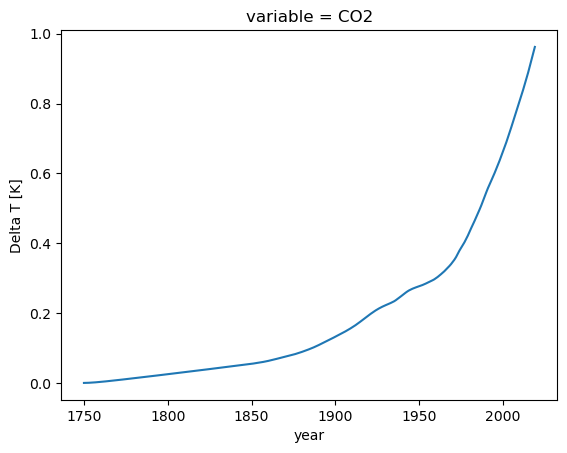

In [1518]:
#check
for per in IRFpercentiles:
     dic_ds_old[per].isel( variable=0)[name_deltaT].plot()

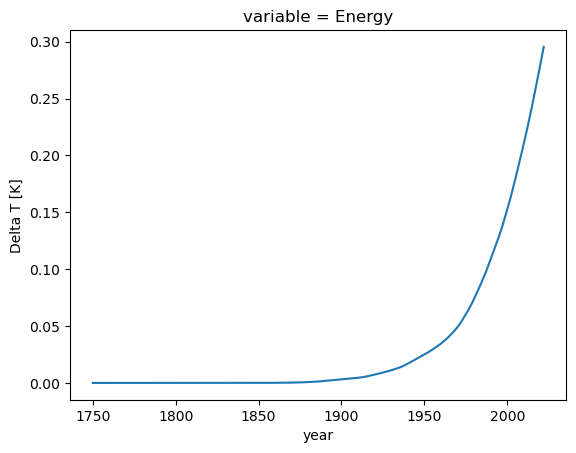

In [1519]:
for per in IRFpercentiles:
     dic_ds_cfs['co2',per].isel( variable=0)[name_deltaT].plot(label = 'energy')

In [1520]:
# temperture xarray to percentiles
ds_tmp = {}
for spec in ds_specs:
    for key in IRFpercentiles:
        ds_tmp[spec] = xr.Dataset(coords=dic_ds_cfs[spec,key].coords)
        ds_tmp[spec][key] = dic_ds_cfs[spec, key]['Delta T']
        ds_specs[spec]['Delta T'] = ds_tmp[spec].to_array('percentile')

    
    # ds_specs[spec]['Delta T'] = dic_ds_cfs[spec]['Delta T'].to_array('percentile')

 # dic_ds_cfs[spec,key]

In [1521]:
ds_specs['co2']

<xarray.Dataset>
Dimensions:     (year: 273, variable: 7, percentile: 1)
Coordinates:
  * year        (year) int32 1750 1751 1752 1753 1754 ... 2019 2020 2021 2022
  * variable    (variable) object 'Energy' 'ffpd' ... 'Buildings'
  * percentile  (percentile) object 'recommendation'
Data variables:
    ERF         (variable, year) float64 0.0 0.0 0.0 ... 0.2318 0.2341 0.2364
    time        (year) datetime64[ns] 1750-01-01 1751-01-01 ... 2022-01-01
    delta_t     (year) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    Delta T     (percentile, variable, year) float64 0.0 0.0 ... 0.1186 0.1198

In [1522]:
# ds_co2['Delta T'].sel(percentile='recommendation')
ds_specs.keys()

dict_keys(['co2', 'ch4', 'n2o', 'hc', 'bc', 'voc', 'so2', 'nox', 'nh3', 'oc', 'co'])

In [1523]:
# Generate dictionary of DataFrames containing del_T for all years, climate forcers/species (spec), and sectors
ds_dt = {} # all del_T (1750-2022)
ds_dt_2022 ={} # present day del_T (2022)
for spec in ds_specs.keys():
    ds_dt[spec] = ds_specs[spec]['Delta T'].sel(percentile='recommendation').to_pandas().transpose()
    # Get values for latest year (2022)
    ds_dt_2022[spec] =  ds_dt[spec].iloc[-1,:]
ds_dt_ = ds_dt.copy()

#generate dictionary of dataframes containing relative contributions of each species/sector to overall del_temp for that year and 21st century (2000-2022)
ds_dt_2 = {} # del_T (2000-2022) by gas
ds_dt_3 = {} # del_T (2000-2022) by year
ds_dt_tot = {} # total annual temp change
ds_dt_4 = {} # trend in del_T relative to total for each year
ds_dt_4_ind = {} # trend in del_T compared to each climate forcers/species (spec)

for spec in ds_dt_.keys():
    ds_dt_2[spec] = ds_dt_[spec].iloc[-23:,:] 
    ds_dt_2[spec] = ds_dt_2[spec].fillna(0)
    for i in np.arange(2000,2023,1):
        ds_dt_yr = []
        for key,df in ds_dt_2.items():
            year_row = df.loc[df.index == i]
            ds_dt_yr.append(year_row)
        ds_dt_3[i] = pd.concat(ds_dt_yr, axis=0, keys = ds_dt_2.keys())#.drop(columns = 'year')
        ds_dt_3[i]['species sum del_T'] = ds_dt_3[i].sum(axis=1)
        ds_dt_3[i].loc['sector sum del_T'] = ds_dt_3[i].sum(axis=0)
        ds_dt_tot[i] = ds_dt_3[i].loc['sector sum del_T','species sum del_T']
        ds_dt_4[i] = ds_dt_3[i].iloc[:-1,:-1].div(ds_dt_3[i].iloc[-1,-1])
        ds_dt_4_ind[i] = ds_dt_3[i].iloc[:-1,:-1].div(ds_dt_3[i].iloc[:-1,-1].values, axis =0) # each cell relative to species total
        ds_dt_4[i]['rel sum compound'] = ds_dt_4[i].sum(axis=1)
        ds_dt_4[i].loc['rel sum sector'] = ds_dt_4[i].sum(axis=0)


# calc trend in rel contribution to temp by species/sector for time period (2000-2022)
from scipy.stats import linregress
dt_rel = {}
for spec in ds_dt_4.keys():
    dt_rel[spec] = ds_dt_4[spec].iloc[:-1,:-1]
    dt_rel[spec].index = [i[0] for i in dt_rel[spec].index]

#build dataframe to store slope of linear regression (trend)
dt_trend = pd.DataFrame(index = dt_rel[2000].index, columns =  dt_rel[2000].columns)

#grab the unique cell for each relative year dataframe (2000-2022), store, and perform linear regression
for row in dt_trend.index:
    for col in dt_trend.columns:
        y = [df.at[row,col] for df in dt_rel.values()]
        x = np.arange(1, len(y) +1)

        slope, intercept, r_value, p_value, std_err = linregress(x,y)

        dt_trend.at[row, col] = slope

# sum of species and sector trends (2000-2022)
dt_trend['species sum trend_rel_del_T'] = dt_trend.sum(axis=1)
dt_trend.loc['sector sum trend_rel_del_T'] = dt_trend.sum(axis=0)


In [1524]:
#Present year (2022) climate forcer temp. effect by sector
ds_dt_3[2022]#.iloc[-1,:-1] / ds_dt_3[2022].iloc[-1,-1]

variable,Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings,species sum del_T
"(co2, 2022)",0.295460,0.085699,0.000694,0.015199,0.295487,0.206459,0.119840,1.018838
"(ch4, 2022)",0.001656,0.239511,0.119887,0.238406,0.001939,0.002519,0.019202,0.623120
"(n2o, 2022)",0.002107,0.000261,0.005316,0.077161,0.027173,0.005305,0.003025,0.120348
"(hc, 2022)",0.000000,0.000000,0.000000,0.000000,0.059799,0.008047,0.037761,0.105607
"(bc, 2022)",0.002984,0.005084,0.002614,0.002627,0.007795,0.012340,0.024793,0.058238
"(voc, 2022)",0.001388,0.027910,0.002438,0.010621,0.036495,0.021119,0.024078,0.124049
"(so2, 2022)",-0.222365,-0.047605,-0.001371,-0.005153,-0.184321,-0.070951,-0.031567,-0.563333
"(nox, 2022)",-0.028060,-0.004441,-0.002697,-0.010534,-0.020625,-0.068846,-0.005569,-0.140772
"(nh3, 2022)",-0.000056,-0.000273,-0.002387,-0.013184,-0.000284,-0.000133,-0.000787,-0.017104
"(oc, 2022)",-0.007494,-0.002337,-0.013507,-0.001821,-0.013764,-0.005335,-0.067656,-0.111913


In [1525]:
ds_dt_3[2019]

variable,Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings,species sum del_T
"(co2, 2019)",0.272883,0.081671,0.000599,0.014580,0.282312,0.193786,0.116162,0.961992
"(ch4, 2019)",0.001529,0.236121,0.114785,0.233729,0.001793,0.002470,0.019170,0.609597
"(n2o, 2019)",0.001871,0.000250,0.004973,0.073203,0.026419,0.005118,0.002931,0.114764
"(hc, 2019)",0.000000,0.000000,0.000000,0.000000,0.060571,0.007765,0.034999,0.103334
"(bc, 2019)",0.002433,0.005286,0.002510,0.002719,0.008094,0.012778,0.025311,0.059132
"(voc, 2019)",0.001295,0.028044,0.002471,0.010502,0.036114,0.023697,0.025552,0.127676
"(so2, 2019)",-0.228046,-0.048912,-0.001288,-0.005293,-0.190975,-0.087053,-0.034551,-0.596119
"(nox, 2019)",-0.029064,-0.004398,-0.002567,-0.010448,-0.020664,-0.070087,-0.005633,-0.142861
"(nh3, 2019)",-0.000049,-0.000260,-0.002293,-0.012765,-0.000282,-0.000136,-0.000784,-0.016569
"(oc, 2019)",-0.006075,-0.002428,-0.013151,-0.001848,-0.013742,-0.005556,-0.069507,-0.112308


### Calculation Explorations

In [1526]:
#to get how much co2 (1800-1899) has contributed to todays warming
# 1. find fraction co2 (1800-1899) still in atmosphere (2022 total)
# 2. find how much that is in warming by multiplying fraction to todays co2 warming
# 3. divide this temp. number by the total temperature to get the contribution to todays warming
co2_from_19th = (carbon_decayedc.iloc[:,50:150].sum().sum() / carbon_decayedc.iloc[:,-2].sum())
print('Fraction of CO2 from the 19th century in the atmosphere 2022 = ', round(co2_from_19th,3))
print()
print('Contribution of 19th century CO2 emissions to net warming (2022) = ', round(co2_from_19th * ds_dt_3[2022].iloc[0,-1],3) \
     ,'degC and in percent = ', round(((co2_from_19th * ds_dt_3[2022].iloc[0,-1])/ds_dt_3[2022].iloc[-1,-1])*100, 3),'%')

Fraction of CO2 from the 19th century in the atmosphere 2022 =  0.015

Contribution of 19th century CO2 emissions to net warming (2022) =  0.016 degC and in percent =  1.16 %


Text(0, 0.5, 'Emissions (kt)')

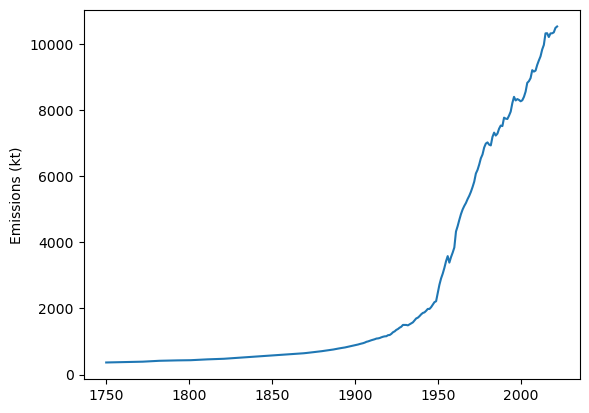

In [1527]:
# plot of N2O emissions (raw)
plt.plot(np.arange(1750,2023,1), n2occ.sum())
plt.ylabel('Emissions (kt)')

Text(0, 0.5, 'Emissions (kt)')

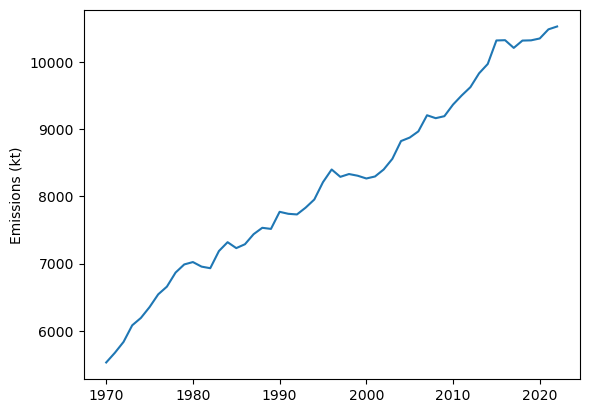

In [1528]:
# plot of N2O emissions (raw)
plt.plot(np.arange(1970,2023,1), n2oc_years_pre.sum())
plt.ylabel('Emissions (kt)')

In [1529]:
#to get how much 2no from ag (1960-1980) has contributed to todays warming
# 1. find fraction of ag from 1960-1980 still in atmosphere (2022 total)
# 2. find how much that is in warming by multiplying fraction to todays N2O warming
# 3. divide this temp. number by the total temperture to get the contribution to todays warming
n2o_from_ag = (n2o_decayedc.iloc[:,210:231].sum(axis=1)/n2o_decayedc.iloc[:,-2].sum())[3]
n2o_from_ag, ((n2o_from_ag * ds_dt_3[2022].iloc[2,-1])/ds_dt_3[2022].iloc[-1,-1])*100, n2o_from_ag * ds_dt_3[2022].iloc[2,-1]

print('Fraction of n2o from Ag 1960-1980 still in atmosphere (2022 total) = ', round(n2o_from_ag,3))
print()
print('Contribution of n2o from Ag 1960-1980 emissions to net warming (2022) = ', round(n2o_from_ag * ds_dt_3[2022].iloc[2,-1],3) \
     ,'degC and in percent = ', round(((n2o_from_ag * ds_dt_3[2022].iloc[2,-1])/ds_dt_3[2022].iloc[-1,-1])*100, 3),'%')

Fraction of n2o from Ag 1960-1980 still in atmosphere (2022 total) =  0.098

Contribution of n2o from Ag 1960-1980 emissions to net warming (2022) =  0.012 degC and in percent =  0.881 %


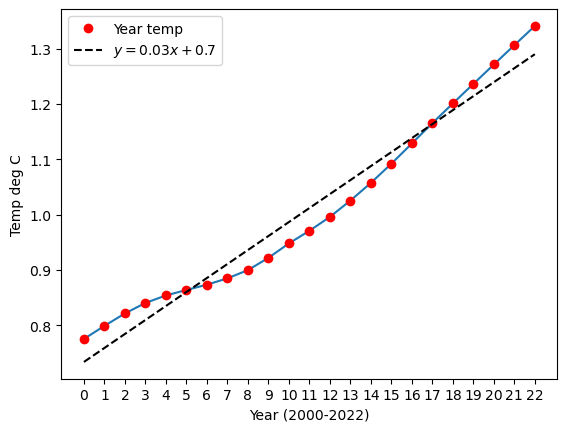

In [1530]:
# Total del_T by year with trend of time period (2000-2022)
plt.plot(np.arange(0,22+1), list(ds_dt_tot.values()))
x = np.arange(0,22+1)
y = list(ds_dt_tot.values())
coef = np.polyfit(np.arange(0,22+1), list(ds_dt_tot.values()),1)
poly1d_fn = np.poly1d(coef) 
m,b = np.poly1d(coef) 
# poly1d_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'ro', label = 'Year temp')
plt.plot( x, poly1d_fn(x), '--k', label=f'$y = {m:.2f}x {b:+.1f}$') #'--k'=black dashed line, 'yo' = yellow circle marker
plt.ylabel('Temp deg C')
plt.xlabel('Year (2000-2022)')
plt.xticks(np.arange(0,22+1))
plt.legend()
# plt.xlim(0, 5)
# plt.ylim(0, 12)

In [1531]:
#Generate DataFrame (table) of del_T for all climate forcers and sectors
del_t_all = pd.concat(ds_dt_2022, axis=1)
del_t_all.columns = [x.upper() for x in del_t_all.columns]
del_t_all = del_t_all.T.rename_axis('Del_T cumulative decayed emissions (1750-2022)', axis = 'columns')
del_t_all['species sum del_T'] = del_t_all.sum(axis=1)
del_t_all.loc['sector sum del_T'] = del_t_all.sum(axis=0)

# Results

In [1532]:
del_t_all#.iloc[:-1,:-1]

Del_T cumulative decayed emissions (1750-2022),Energy,ffpd,Waste,Agriculture,Industry,Transportation,Buildings,species sum del_T
CO2,0.295460,0.085699,0.000694,0.015199,0.295487,0.206459,0.119840,1.018838
CH4,0.001656,0.239511,0.119887,0.238406,0.001939,0.002519,0.019202,0.623120
N2O,0.002107,0.000261,0.005316,0.077161,0.027173,0.005305,0.003025,0.120348
HC,0.000000,0.000000,0.000000,0.000000,0.059799,0.008047,0.037761,0.105607
BC,0.002984,0.005084,0.002614,0.002627,0.007795,0.012340,0.024793,0.058238
VOC,0.001388,0.027910,0.002438,0.010621,0.036495,0.021119,0.024078,0.124049
SO2,-0.222365,-0.047605,-0.001371,-0.005153,-0.184321,-0.070951,-0.031567,-0.563333
NOX,-0.028060,-0.004441,-0.002697,-0.010534,-0.020625,-0.068846,-0.005569,-0.140772
NH3,-0.000056,-0.000273,-0.002387,-0.013184,-0.000284,-0.000133,-0.000787,-0.017104
OC,-0.007494,-0.002337,-0.013507,-0.001821,-0.013764,-0.005335,-0.067656,-0.111913


In [1533]:
tab_plt_dT= del_t_all.iloc[:-1,:-1]

### Generate ERF & del_T Figure by Gas-Sector

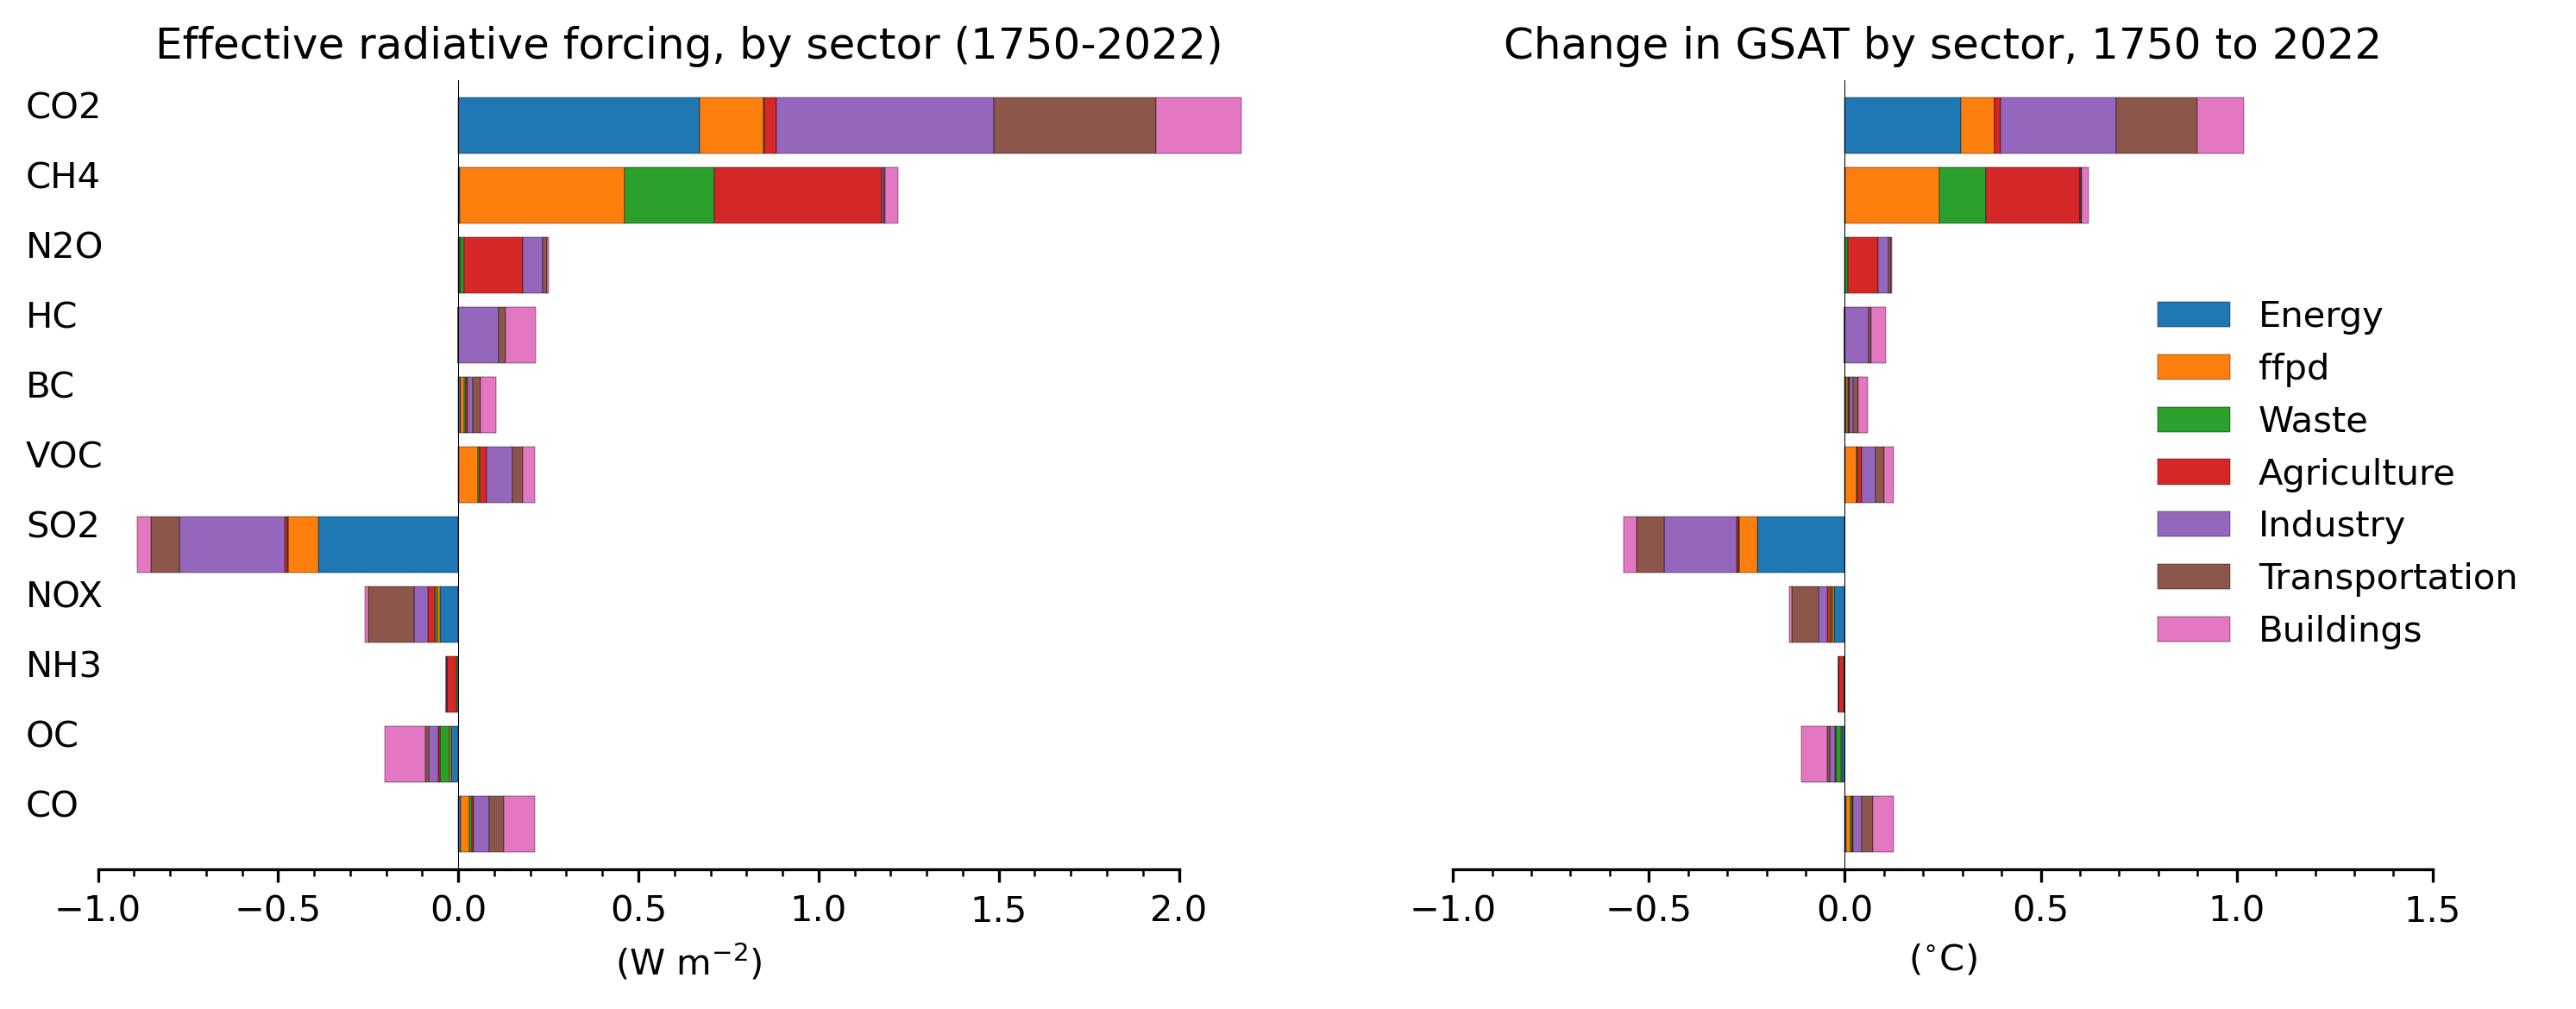

In [1534]:
sns.set_style()
fig, axs = plt.subplots(1, 2, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}

ax = axs[0]
ax.axvline(x=0., color='k', linewidth=0.25)

df_spec_sector_erf.plot.barh(stacked=True, ax=ax, **kws)#color=col_ls, ax=ax, **kws)
# tab_plt_erf.reindex(index_order).plot.barh(stacked=True, color=col_ls, ax=ax, **kws)
# tot = table['Total'][::-1]
# tot = tab_plt_erf.reindex(index_order).sum(axis=1)  # tab_plt

tot = df_spec_sector_erf.sum(axis=1)  # tab_plt
# xerr = df_err['95-50_period'].reindex(index_order)
y = np.arange(len(tot))
# ax.errorbar(tot, y, xerr=xerr, marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

for lab, y in zip(index_order.T, ybar):
    # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
    ax.text(-1.2, y - 0.1, lab, ha='left')  # , va='left')

# for lab, y in zip(index_order2, ybar):
#     # plt.text(-1.55, ybar[i], species[i],  ha='left')#, va='left')
#     ax.text(-.75, y - 0.1, lab, ha='left')  # , va='left')
    
ax.set_title('Effective radiative forcing, by sector (1750-2022)')
ax.set_xlabel(r'(W m$^{-2}$)')
# ax.set_xlim(-1.5, 2.6)
# plt.xlim(-1.6, 2.0)
# sns.despine(fig, left=True, trim=True)
ax.legend(loc='lower right', frameon=False)
ax.set_yticks([])

ax.get_legend().remove()

ax.set_xticks(np.arange(-1, 2.1, .5))
ax.set_xticks(np.arange(-1, 2, .1), minor=True)
ax.invert_yaxis()

ax = axs[1]
ax.axvline(x=0., color='k', linewidth=0.25)

tab_plt_dT.reindex(index_order).plot.barh(stacked=True, ax=ax, **kws)# color=col_ls, ax=ax, **kws)
tot = tab_plt_dT.reindex(index_order).sum(axis=1)
# # xerr =0# df_err['95-50'][::-1]
y = np.arange(len(tot))
# xerr_dT = err_dT[['p50-05', 'p95-50']].reindex(index_order).transpose().values
# ax.errorbar(tot, y,
#             xerr=xerr_dT,
#             # xerr=err_dT[['min 1 sigma','plus 1 sigma']].loc[tot.index].transpose().values,
#             marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

ax.set_title('Change in GSAT by sector, 1750 to 2022')
ax.set_xlabel(r'($^{\circ}$C)')
ax.set_xlim(-1.3, 1.8)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-1., 1.5)
ax.legend(loc='right', frameon=False)

ax.set_xticks(np.arange(-1, 1.5, .5))
# ax.xaxis.set_major_locator(MultipleLocator(.5))

ax.set_xticks(np.arange(-1, 1.6, .5))
ax.set_xticks(np.arange(-1, 1.5, .1), minor=True)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()

# fig.savefig('data_out/ERF_delT_Compound_Sector_ERF_GSAT_1750_2022_CEDS.png')
#fig.savefig('data_out/ERF_delT_Compound_Sector_ERF_GSAT_1750_2022_CEDS_ffpd_separated.png')
# fig.savefig('ERF_Compound_Sector_ERF1750_2019_EDGAR.png')
# fig.savefig('ERF_Compound_Sector_ERF1970_2019.png')

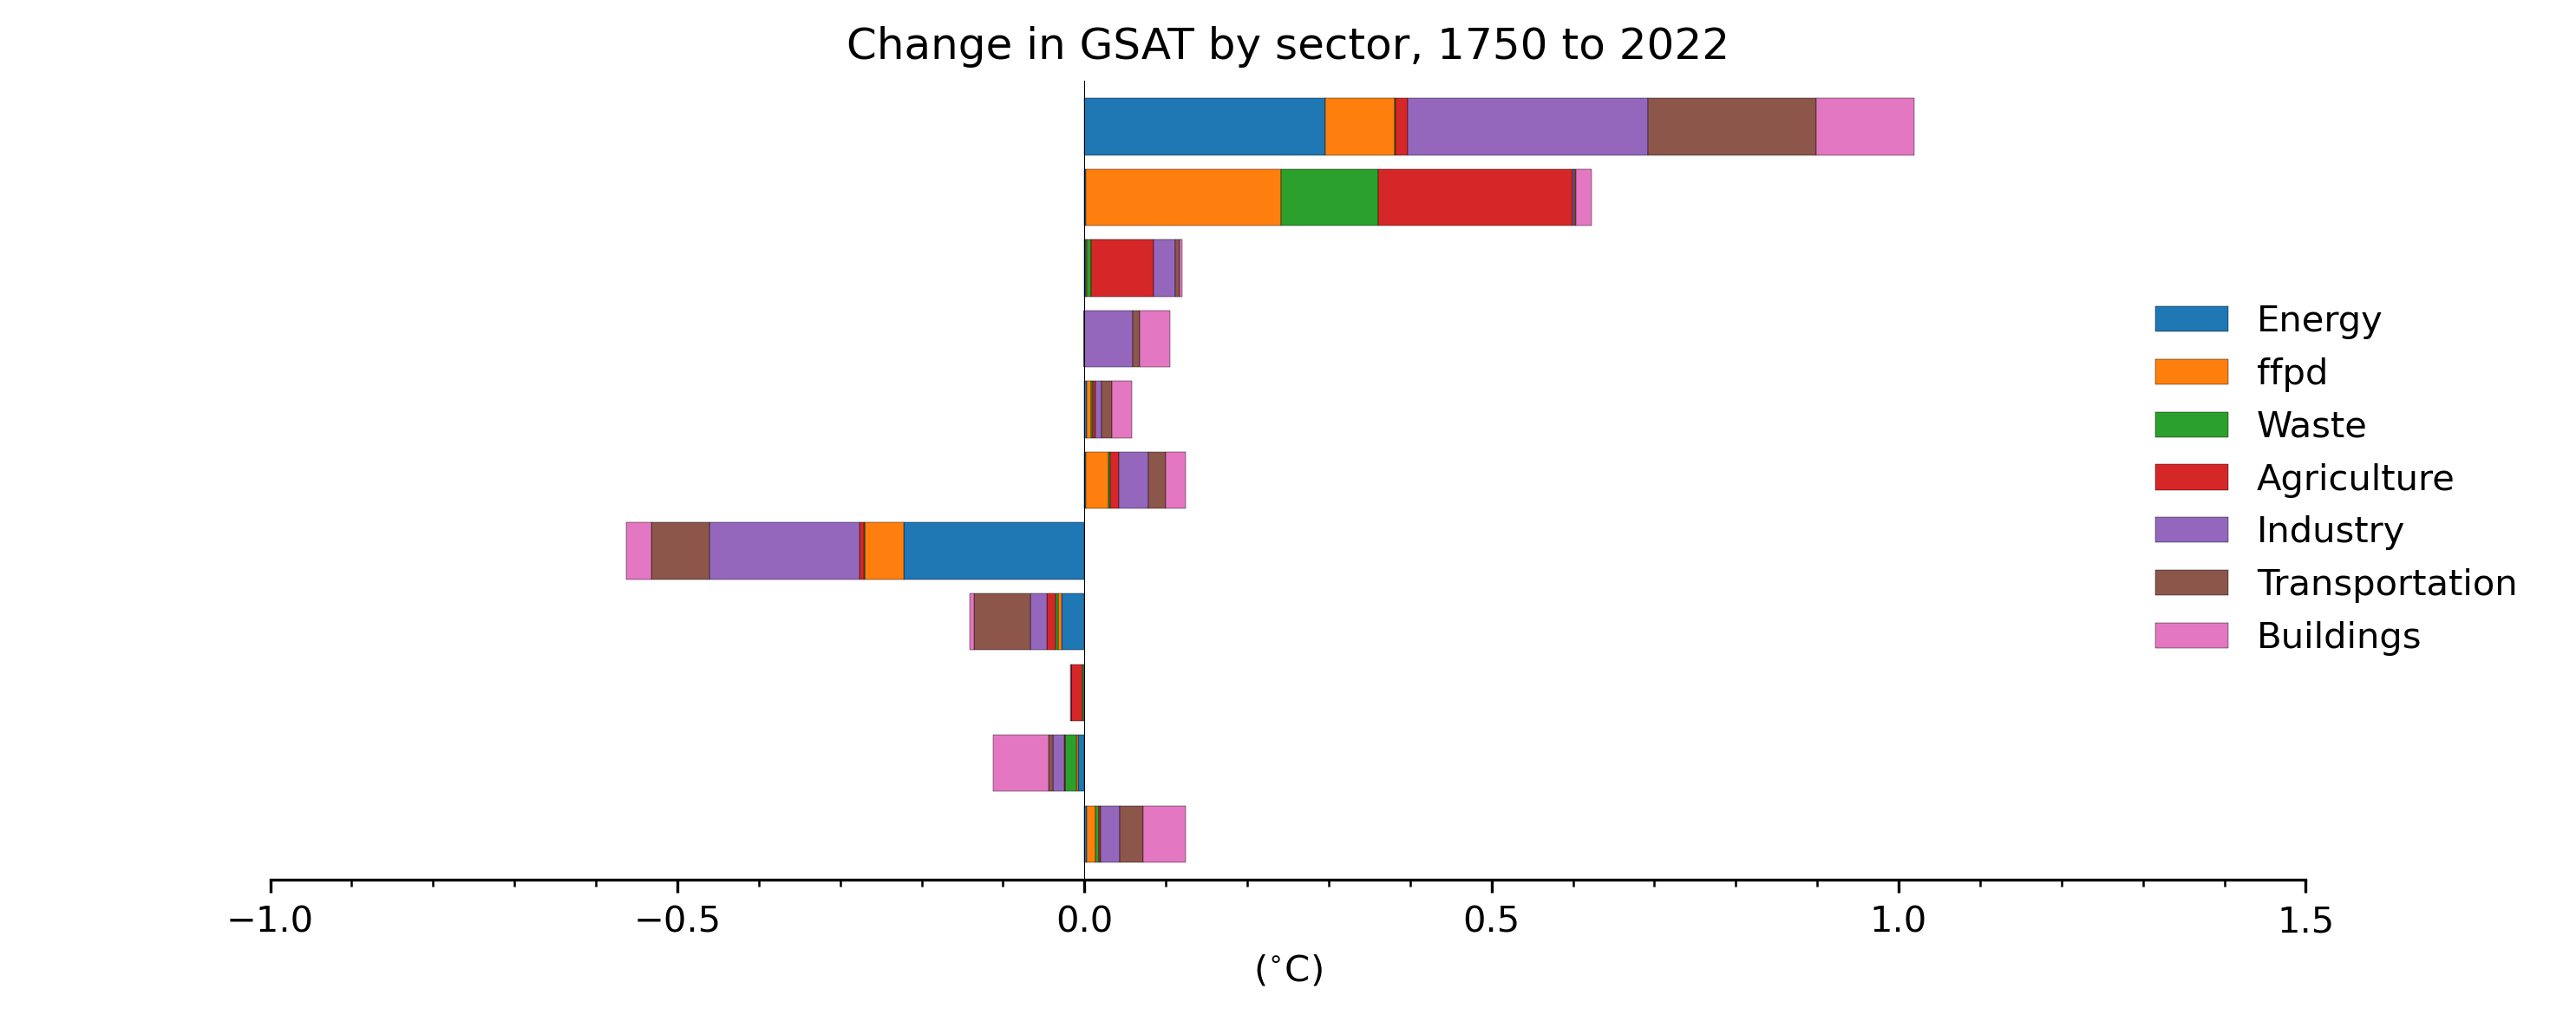

In [1535]:
sns.set_style()
fig, axs = plt.subplots(1, 1, dpi=300, figsize=[10, 4])  # , dpi=150)
width = .8
kws = {
    'width': .8,
    'linewidth': .1,
    'edgecolor': 'k',

}


ax = axs
ax.axvline(x=0., color='k', linewidth=0.25)

tab_plt_dT.reindex(index_order).plot.barh(stacked=True, ax=ax, **kws)# color=col_ls, ax=ax, **kws)
tot = tab_plt_dT.reindex(index_order).sum(axis=1)
# # xerr =0# df_err['95-50'][::-1]
y = np.arange(len(tot))
# xerr_dT = err_dT[['p50-05', 'p95-50']].reindex(index_order).transpose().values
# ax.errorbar(tot, y,
#             xerr=xerr_dT,
#             # xerr=err_dT[['min 1 sigma','plus 1 sigma']].loc[tot.index].transpose().values,
#             marker='d', linestyle='None', color='k', label='Sum', )
# ax.legend(frameon=False)
ax.set_ylabel('')

ax.set_title('Change in GSAT by sector, 1750 to 2022')
ax.set_xlabel(r'($^{\circ}$C)')
ax.set_xlim(-1.3, 1.8)

sns.despine(fig, left=True, trim=True)
ax.spines['bottom'].set_bounds(-1., 1.5)
ax.legend(loc='right', frameon=False)

ax.set_xticks(np.arange(-1, 1.5, .5))
# ax.xaxis.set_major_locator(MultipleLocator(.5))

ax.set_xticks(np.arange(-1, 1.6, .5))
ax.set_xticks(np.arange(-1, 1.5, .1), minor=True)

# fn = output_name + '.png'
# fp = PATH_FIGURE_OUT / fn
# fp.parent.mkdir(parents=True, exist_ok=True)
ax.set_yticks([])
fig.tight_layout()
# plt.savefig(fp, dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.pdf'), dpi=300, bbox_inches='tight')
# plt.savefig(fp.with_suffix('.png'), dpi=300, bbox_inches='tight')
plt.gca().invert_yaxis()

plt.show()

# fig.savefig('data_out/DelT_Compound_Sector_GSAT_1750_2022_CEDS.png')
# fig.savefig('data_out/DelT_Compound_Sector_GSAT_1750_2022_CEDS_ffpd_separated.png')

## Save ERF and del_Temp files

In [1536]:
if choice_ffpd == 0:
    # WITH FFPD
    newpath = r'C:data_out_final' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    newpath = r'C:data_out_final/del_T_years'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
    newpath = r'C:data_out_final/relative_del_T_years'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    newpath = r'C:data_out_final/relative_del_T_years_trend'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    #save ERF for 2022
    erf2.T.to_csv('data_out_final/all_species&sectors_ERF_decay_emiss_cumulative_2022.csv')
    
    #save del_T for 2022
    del_t_all.to_csv('data_out_final/all_species&sectors_del_T_decay_emiss_cumulative_2022.csv')
    
    #save del_T for each year
    for yr in ds_dt_3.keys():
        ds_dt_3[yr].to_csv('data_out_final/del_T_years/del_T_decay_emiss_cumulative_' + str(yr) +'.csv')   
        
    # save rel contributions for each year
    for yr in ds_dt_4.keys():
        ds_dt_4[yr].to_csv('data_out_final/relative_del_T_years/relative_del_T_decay_emiss_cumulative_' + str(yr) +'.csv')
        
    #save trend in rel contributions (2000-2022)
    dt_trend.to_csv('data_out_final/relative_del_T_years_trend/trend_relative_del_T_decay_emiss_cumulative.csv')
else:
    # WITH FFPD SEPARATED
    newpath = r'C:data_out_final/ffpd_sep' 
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
    newpath = r'C:data_out_final/ffpd_sep/del_T_years'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
    newpath = r'C:data_out_final/ffpd_sep/relative_del_T_years'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    
    newpath = r'C:data_out_final/ffpd_sep/relative_del_T_years_trend'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
        
    # save ERF for 2022
    erf2.T.to_csv('data_out_final/ffpd_sep/all_species&sectors_ERF_decay_emiss_cumulative_2022.csv')
    
    #save del_T for 2022
    del_t_all.to_csv('data_out_final/ffpd_sep/all_species&sectors_del_T_decay_emiss_cumulative_2022.csv')
    
    #save del_T for each year
    for yr in ds_dt_3.keys():
        ds_dt_3[yr].to_csv('data_out_final/ffpd_sep/del_T_years/del_T_decay_emiss_cumulative_' + str(yr) +'.csv')   
        
    # save rel contributions for each year
    for yr in ds_dt_4.keys():
        ds_dt_4[yr].to_csv('data_out_final/ffpd_sep/relative_del_T_years/relative_del_T_decay_emiss_cumulative_' + str(yr) +'.csv')
        
    #save trend in rel contributions (2000-2022)
    dt_trend.to_csv('data_out_final/ffpd_sep/relative_del_T_years_trend/trend_relative_del_T_decay_emiss_cumulative.csv')

In [1537]:
raise SystemExit("Stop here")

SystemExit: Stop here

# END 